# Module 2 Project

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Project Overview

    1) Establish business questions to explore
    2) Open, explore, and perform necessary cleaning on provided data sets. Determine need for additional data and acquire it via API calls and web scraping. Decide on most robust data to use as the "master" set.
    3) Merge data sets into larger data sets as needed. Clean further until working with robust data.
    4) EDA on data sets including visualizations

# Business Exploration Questions

1. What are the primary factors influencing housing prices in the King County metro area?
2. Can we effectively use a regression model based system for realtors to determine a proper list price?
3. Is a model-based system more accurate for determining list price than the traditional comps-based system?
4. What easy-to-use features can we add to our model to increase its accuracy?

# Notebook Preparation

## Recommended Extensions

Recommended to also install the nbextensions "Table of Contents 2" and "Collapsible Headings" for easier navigation through this notebook.

Gitbhub here: https://github.com/ipython-contrib/jupyter_contrib_nbextensions


Ensure seaborn is updated to recent version

## Importing Modules

In [1]:
import csv

from joblib import dump

import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import statsmodels.api as sm
from statsmodels.formula.api import ols
#from statsmodels.formula.api import wls

import scipy.stats as stats
from scipy.stats import norm

from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR

from sklearn.feature_selection import RFECV, RFE

from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn import neighbors
from math import sqrt
import itertools

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Point,Polygon
import geopandas as gpd
import descartes
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## Notebook Functions

In [2]:
# function that looks up a segment that a data entry belongs to
def make_group(x, frame, column):
    y = frame.loc[(frame.index == x)][column]
    z = np.array(y)
    z[0]
    return z[0]

# Preprocessing

In [3]:
# load and look at our king county housing data
df = pd.read_csv('kc_house_data.csv')
df

id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
2      5631500400   2/25/2015  180000.0         2       1.00          770   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
4      1954400510   2/18/2015  510000.0         3       2.00         1680   
...           ...         ...       ...       ...        ...          ...   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21595   291310100   1/16/2015  400000.0         3       2.50         1600   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0          5650     1.0         NaN   0.0          3      7        1180   
1          7242     2.0         0.0   0.0          3      7        2170   
2         10000     1.0         0.0   0.0          3      6         770   
3          5000     1.0         0.0   0.0          5      7        1050   
4          8080     1.0         0.0   0.0          3      8        1680   
...         ...     ...         ...   ...        ...    ...         ...   
21592      1131     3.0         0.0   0.0          3      8        1530   
21593      5813     2.0         0.0   0.0          3      8        2310   
21594      1350     2.0         0.0   0.0          3      7        1020   
21595      2388     2.0         NaN   0.0          3      8        1600   
21596      1076     2.0         0.0   0.0          3      7        1020   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0               0.0      1955           0.0    98178  47.5112 -122.257   
1             400.0      1951        1991.0    98125  47.7210 -122.319   
2               0.0      1933           NaN    98028  47.7379 -122.233   
3             910.0      1965           0.0    98136  47.5208 -122.393   
4               0.0      1987           0.0    98074  47.6168 -122.045   
...             ...       ...           ...      ...      ...      ...   
21592           0.0      2009           0.0    98103  47.6993 -122.346   
21593           0.0      2014           0.0    98146  47.5107 -122.362   
21594           0.0      2009           0.0    98144  47.5944 -122.299   
21595           0.0      2004           0.0    98027  47.5345 -122.069   
21596           0.0      2008           0.0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21592           1530        1509  
21593           1830        7200  
21594           1020        2007  
21595           1410        1287  
21596           1020        1357  

[21597 rows x 21 columns]

In [4]:
# what are the columns in our data?

df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Outliers

In [5]:
# looking for outliers in the percentiles

df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21534.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233863      3.409825   
std    4.141264e+04      0.539683      0.086825      0.765686      0.650546   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068500e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above      yr_built  yr_renovated       zipcode  \
count  21597.000000  21597.000000  21597.000000  17755.000000  21597.000000   
mean       7.657915   1788.596842   1970.999676     83.636778  98077.951845   
std        1.173200    827.759761     29.375234    399.946414     53.513072   
min        3.000000    370.000000   1900.000000      0.000000  98001.000000   
25%        7.000000   1190.000000   1951.000000      0.000000  98033.000000   
50%        7.000000   1560.000000   1975.000000      0.000000  98065.000000   
75%        8.000000   2210.000000   1997.000000      0.000000  98118.000000   
max       13.000000   9410.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000   21597.000000   21597.000000  
mean      47.560093   -122.213982    1986.620318   12758.283512  
std        0.138552      0.140724     685.230472   27274.441950  
min       47.155900   -122.519000     399.000000     651.000000  
25%       47.471100   -122.328000    1490.000000    5100.000000  
50%       47.571800   -122.231000    1840.000000    7620.000000  
75%       47.678000   -122.125000    2360.000000   10083.000000  
max       47.777600   -121.315000    6210.000000  871200.000000

We see potential outliers in price, sqft_lot, sqft_living, and bedrooms.

I also see a possible significant outlier in longitude. We will look at what that means visually.

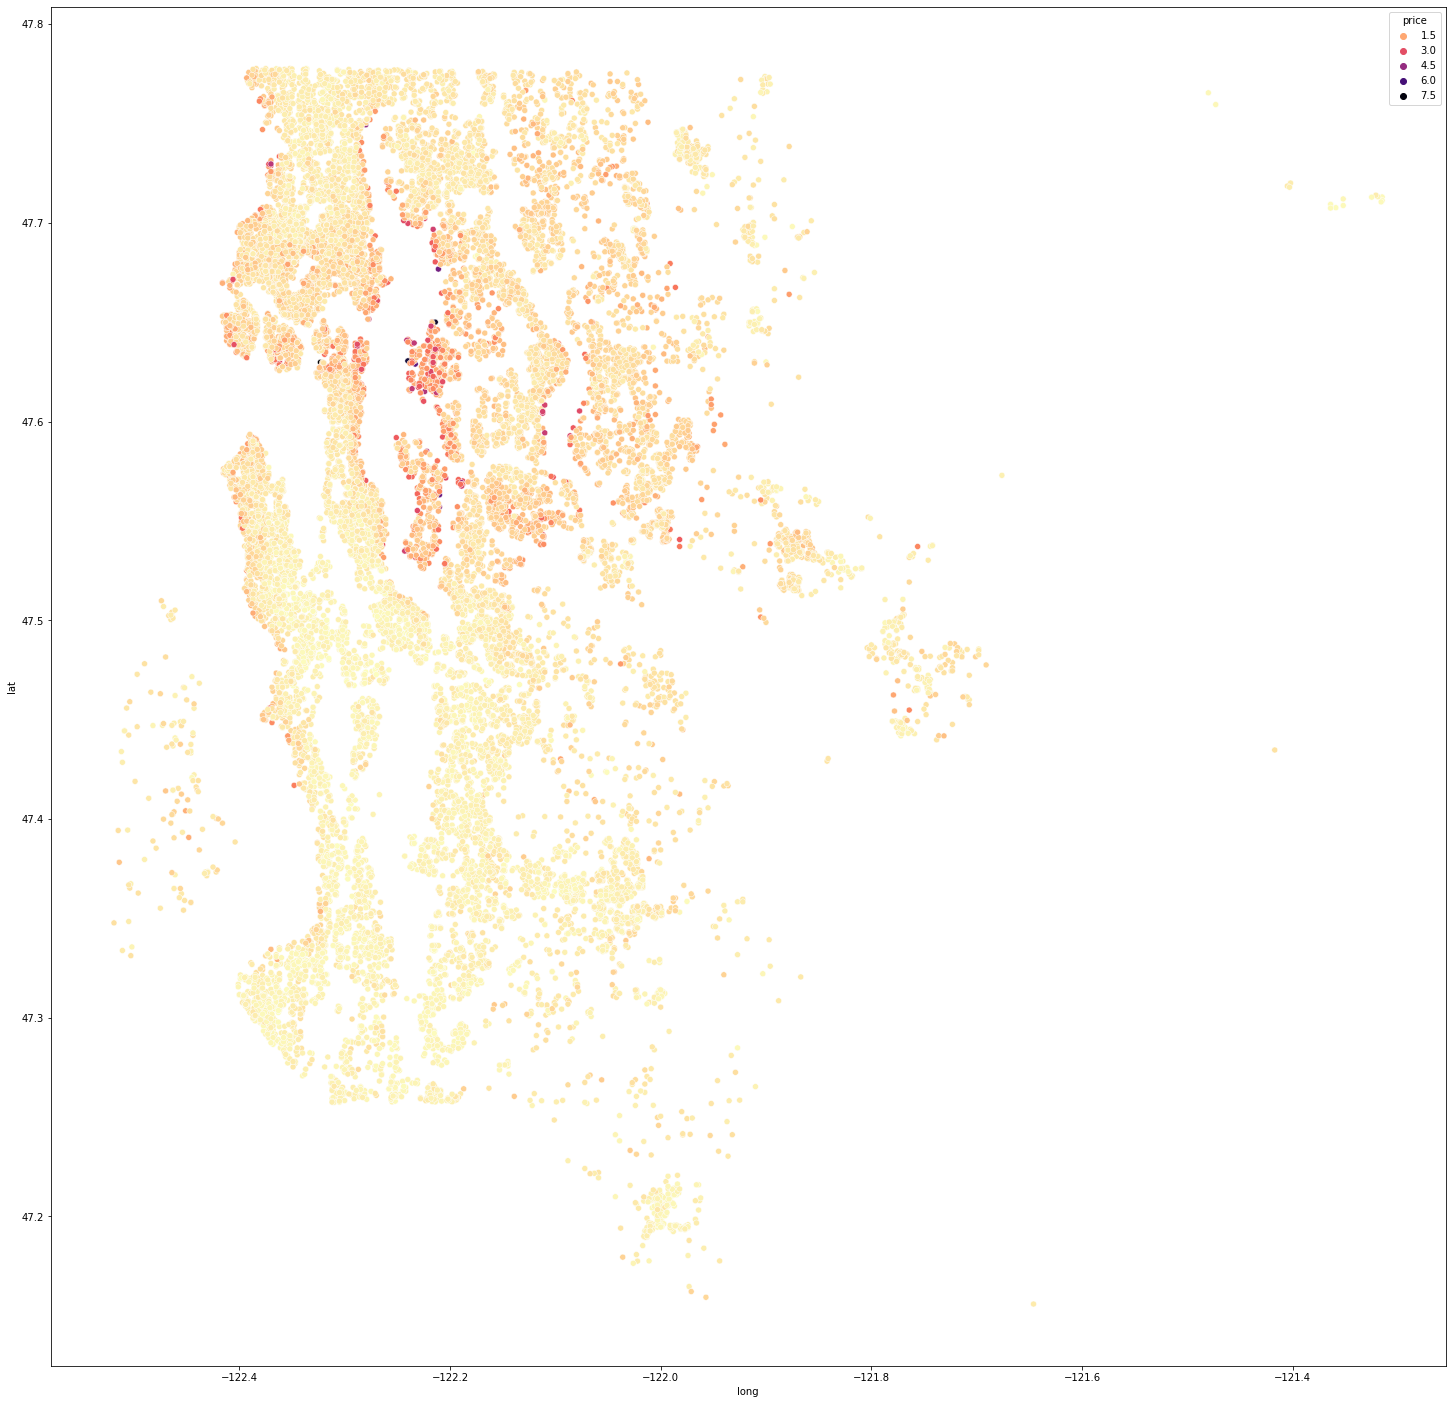

In [6]:
# plotting latitude and longitude as a visual scatter plot

plt.figure(figsize=(25,25))

sns.scatterplot(data=df, x="long", y="lat", hue="price", palette="magma_r");

Using latitude and longitude, we make a visual map of the King County area that lets us see the map outliers. We can see that there are a few sales in locations that are outliers in some way - still in King County but very far away from the metro area on which we are focusing. Sales that are too far outside of our comparison area geographically may add noise to our model. So I'm going to drop the longitude outliers as well. 

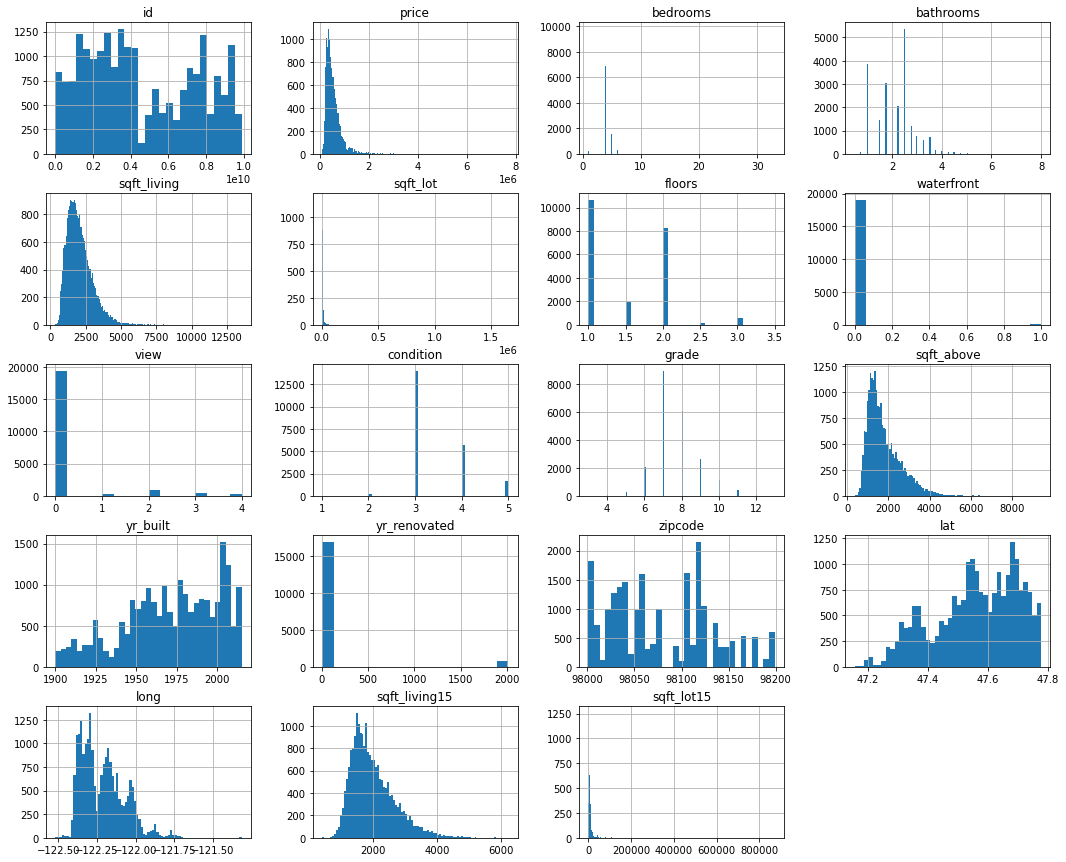

In [7]:
# check how our histograms are looking

df.hist(figsize=(18,15), bins='auto');


In [8]:
# A lot of our variables are not normally shaped, so we can't reliably remove outliers via standard deviation.
# We will use IQR to remove our outliers with the following function

def iqr_outliers(column):
    """return the lower range and upper range for the data based on IQR*1.75"""
    Q1,Q3 = np.percentile(column , [25,75])
    iqr = Q3 - Q1
    lower_range = Q1 - (1.5 * iqr)
    upper_range = Q3 + (1.5 * iqr)
    return lower_range,upper_range  

In [9]:
# determing our IQR for price, lot size, sq footage and longitude

pricelower,priceupper = iqr_outliers(df.price)
lotlower,lotupper = iqr_outliers(df.sqft_lot)
sqftlower, sqftupper = iqr_outliers(df.sqft_living)
longlower, longupper = iqr_outliers(df.long)


# dropping the things outside of our lower and upper range

df.drop(df[ (df.price > priceupper) | (df.price < pricelower) ].index , inplace=True)
df.drop(df[ (df.sqft_lot > lotupper) | (df.sqft_lot < lotlower) ].index , inplace=True)
df.drop(df[ (df.sqft_living > sqftupper) | (df.sqft_living < sqftlower) ].index , inplace=True)
df.drop(df[ (df.long > longupper) | (df.long < longlower) ].index , inplace=True)


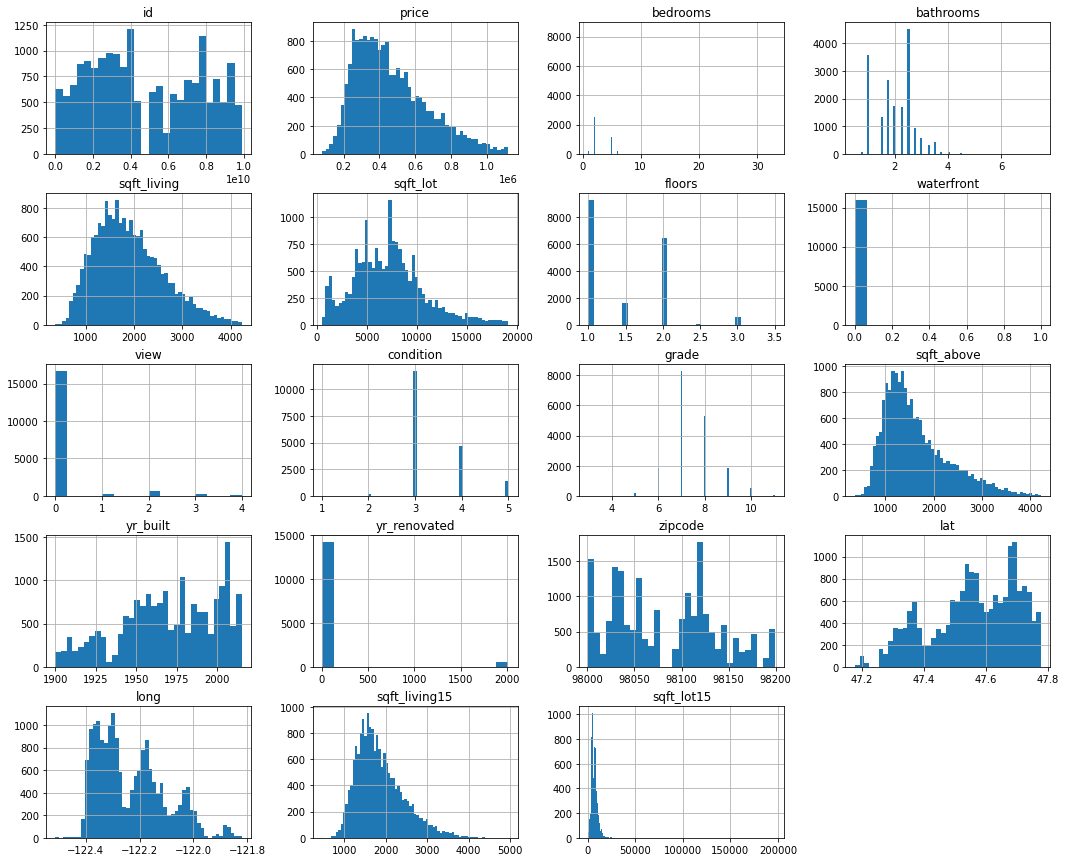

In [10]:
# checking our new histograms

df.hist(figsize=(18,15), bins='auto');

Our data is still largely not normally distributed, but using our IQR has gotten rid of some severely skewing outliers in the price, long and aqft_living categories and ESPECIALLY in the sqft_lot category.

In [11]:
# looking again at our percentile outliers

df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  1.806400e+04  1.806400e+04  18064.000000  18064.000000  18064.000000   
mean   4.734869e+09  4.661867e+05      3.310950      2.022545   1901.211581   
std    2.863577e+09  2.030986e+05      0.908795      0.698204    705.998664   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.310050e+09  3.100000e+05      3.000000      1.500000   1370.000000   
50%    4.051100e+09  4.259980e+05      3.000000      2.000000   1800.000000   
75%    7.504000e+09  5.870000e+05      4.000000      2.500000   2340.000000   
max    9.900000e+09  1.120000e+06     33.000000      7.500000   4230.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  18064.000000  18064.000000  16041.000000  18010.000000  18064.000000   
mean    7228.931577      1.473622      0.001683      0.152860      3.410430   
std     3531.260521      0.543144      0.040993      0.598097      0.649636   
min      520.000000      1.000000      0.000000      0.000000      1.000000   
25%     4800.000000      1.000000      0.000000      0.000000      3.000000   
50%     7158.500000      1.000000      0.000000      0.000000      3.000000   
75%     9199.250000      2.000000      0.000000      0.000000      4.000000   
max    19141.000000      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above      yr_built  yr_renovated       zipcode  \
count  18064.000000  18064.000000  18064.000000  14835.000000  18064.000000   
mean       7.463961   1640.353908   1969.980071     72.252174  98081.761570   
std        0.971570    670.235221     29.902053    372.847802     54.100966   
min        3.000000    370.000000   1900.000000      0.000000  98001.000000   
25%        7.000000   1150.000000   1950.000000      0.000000  98033.000000   
50%        7.000000   1470.000000   1971.000000      0.000000  98074.000000   
75%        8.000000   1990.000000   1997.000000      0.000000  98119.000000   
max       11.000000   4230.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15  
count  18064.000000  18064.000000   18064.000000   18064.000000  
mean      47.560709   -122.231837    1862.605403    7235.137954  
std        0.138559      0.125532     575.085271    4356.270638  
min       47.177500   -122.512000     460.000000     651.000000  
25%       47.473800   -122.337000    1440.000000    4939.750000  
50%       47.570850   -122.268000    1750.000000    7200.000000  
75%       47.680500   -122.152000    2190.000000    8894.250000  
max       47.777600   -121.821000    4950.000000  196591.000000

In [12]:
#check what is going on with the sqft_lot15 outliers by sorting descending

df.sort_values('sqft_lot15', ascending=False)

id        date     price  bedrooms  bathrooms  sqft_living  \
4607   3523029059   7/31/2014  181000.0         2       1.50         1560   
9436   3523029077   10/7/2014  297000.0         3       1.00         1340   
8112   1923039089   6/10/2014  285000.0         2       2.00         1651   
7086   8656800020   2/12/2015  309000.0         3       2.50         1450   
13153  1523069197    5/3/2014  379880.0         3       2.50         1650   
...           ...         ...       ...       ...        ...          ...   
20999  8562780530   3/28/2015  338500.0         2       2.25         1150   
20891  8562780540  12/22/2014  325000.0         2       2.25         1150   
513    2827100070   11/5/2014  290000.0         4       1.00         1330   
20733  2827100075   7/27/2014  286308.0         2       1.50         1220   
19653  7899800863   10/1/2014  299900.0         3       2.50         1210   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
4607      10807     1.0         0.0   0.0          2      7        1560   
9436      18000     1.0         0.0   0.0          4      7        1340   
8112      18200     1.0         0.0   0.0          3      6        1651   
7086      11480     2.0         NaN   0.0          3      7        1450   
13153     14054     1.0         0.0   0.0          4      7        1130   
...         ...     ...         ...   ...        ...    ...         ...   
20999       711     2.0         0.0   0.0          3      7        1150   
20891       711     2.0         0.0   0.0          3      7        1150   
513        8184     1.5         0.0   0.0          3      7        1330   
20733      1036     3.0         0.0   0.0          3      7        1220   
19653      2046     2.0         0.0   0.0          3      9         920   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
4607            0.0      1949           0.0    98070  47.4444 -122.509   
9436            0.0      1924           NaN    98070  47.4443 -122.509   
8112            0.0      1946           0.0    98070  47.4621 -122.461   
7086            0.0      1990           0.0    98014  47.6720 -121.864   
13153         520.0      1986           0.0    98027  47.4821 -122.017   
...             ...       ...           ...      ...      ...      ...   
20999           0.0      2013           NaN    98027  47.5323 -122.071   
20891           0.0      2013           NaN    98027  47.5323 -122.070   
513             0.0      1949           0.0    98133  47.7343 -122.347   
20733           0.0      2006           0.0    98133  47.7348 -122.347   
19653         290.0      2008           NaN    98106  47.5212 -122.357   

       sqft_living15  sqft_lot15  
4607            1660      196591  
9436            1660      196591  
8112            1510       89595  
7086            2080       87991  
13153           1940       87555  
...              ...         ...  
20999           1150         748  
20891           1150         748  
513             1220         660  
20733           1210         659  
19653           1070         651  

[18064 rows x 21 columns]

In [13]:
# there is something off about these two large and nearly identical entries at the top of the list. We are going to drop these two rows.

df.drop(df[df['sqft_lot15'] == 196591].index, axis=0, inplace = True)

In [14]:
#check what is going on with the weird bedroom value by sorting descending

df.sort_values('bedrooms', ascending=False)

id        date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895   6/25/2014  640000.0        33       1.75         1620   
8748   1773100755   8/21/2014  520000.0        11       3.00         3000   
15147  5566100170  10/29/2014  650000.0        10       2.00         3610   
19239  8812401450  12/29/2014  660000.0        10       3.00         2920   
4092   1997200215    5/7/2014  599999.0         9       4.50         3830   
...           ...         ...       ...       ...        ...          ...   
10779  9269200520  10/16/2014  310000.0         1       1.00          670   
465    8658300340   5/23/2014   80000.0         1       0.75          430   
19402  3163600076   7/30/2014  152275.0         1       1.00         1020   
5565   1735800050    4/9/2015  142500.0         1       1.00          690   
10469  7129304375   7/14/2014  202000.0         1       0.75          590   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
15856      6000     1.0         0.0   0.0          5      7        1040   
8748       4960     2.0         0.0   0.0          3      7        2400   
15147     11914     2.0         0.0   0.0          4      7        3010   
19239      3745     2.0         0.0   0.0          4      7        1860   
4092       6988     2.5         0.0   0.0          3      7        2450   
...         ...     ...         ...   ...        ...    ...         ...   
10779      4920     1.0         0.0   0.0          3      5         670   
465        5050     1.0         NaN   0.0          2      4         430   
19402      6871     1.0         0.0   0.0          3      6        1020   
5565       6825     1.0         0.0   0.0          4      5         690   
10469      5650     1.0         0.0   0.0          3      6         590   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
15856         580.0      1947           0.0    98103  47.6878 -122.331   
8748          600.0      1918        1999.0    98106  47.5560 -122.363   
15147         600.0      1958           0.0    98006  47.5705 -122.175   
19239        1060.0      1913           0.0    98105  47.6635 -122.320   
4092         1380.0      1938           0.0    98103  47.6927 -122.338   
...             ...       ...           ...      ...      ...      ...   
10779           0.0      1920           NaN    98126  47.5342 -122.373   
465             0.0      1912           0.0    98014  47.6499 -121.909   
19402           0.0      1937           NaN    98146  47.5051 -122.338   
5565            0.0      1917           0.0    98002  47.3109 -122.225   
10469           0.0      1944           0.0    98118  47.5181 -122.267   

       sqft_living15  sqft_lot15  
15856           1330        4700  
8748            1420        4960  
15147           2040       11914  
19239           1810        3745  
4092            1460        6291  
...              ...         ...  
10779           1050        4920  
465             1200        7500  
19402           1260        6933  
5565            1330        5381  
10469            980        5650  

[18062 rows x 21 columns]

In [15]:
# this value of 33 in 1620 square feet is obviously a mistake. We're going to impute the mean into this field.

# 11 bedrooms in 3000sf, 10 bedrooms in 2920sf, 10 bedrooms in 3610sf are also obviously mistakes
# We're going to impute the mean into the fields for 10 and 11 bedrooms as well.

bedroom_mean = round(df['bedrooms'].mean(), 0)
bedroom_mean
df.loc[df['bedrooms'] == 33.0, 'bedrooms'] = bedroom_mean
df.loc[df['bedrooms'] == 11.0, 'bedrooms'] = bedroom_mean
df.loc[df['bedrooms'] == 10.0, 'bedrooms'] = bedroom_mean

df.sort_values('bedrooms', ascending=False)

# fixed our bedroom outliers by imputing the mean
# I remain suspicious of these 9-bedroom entries, but we'll decline from manipulating them further

id        date     price  bedrooms  bathrooms  sqft_living  \
4092   1997200215    5/7/2014  599999.0         9        4.5         3830   
4231   2902200015    1/6/2015  700000.0         9        3.0         3680   
18428  8823901445   3/13/2015  934000.0         9        3.0         2820   
8537    424049043   8/11/2014  450000.0         9        7.5         4050   
9443   2769600590  10/16/2014  900000.0         8        4.0         4020   
...           ...         ...       ...       ...        ...          ...   
9509   6450301220   9/16/2014  264000.0         1        1.0          710   
16411  7625700020   9/29/2014  340000.0         1        1.0          640   
9536   2658000115   6/18/2014  190000.0         1        1.0          720   
11727  1352300990   8/26/2014  126000.0         1        1.0          610   
7010    203100460   9/24/2014  400000.0         1        1.0          530   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
4092       6988     2.5         0.0   0.0          3      7        2450   
4231       4400     2.0         0.0   0.0          3      7        2830   
18428      4480     2.0         0.0   0.0          3      7        1880   
8537       6504     2.0         0.0   0.0          3      7        4050   
9443       7500     1.0         0.0   0.0          3      8        2010   
...         ...     ...         ...   ...        ...    ...         ...   
9509       4725     1.0         NaN   0.0          3      6         710   
16411      4800     1.0         0.0   0.0          3      6         640   
9536       4800     1.0         0.0   0.0          3      6         720   
11727      4400     1.0         0.0   0.0          3      5         610   
7010      13679     1.0         0.0   0.0          4      6         530   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
4092         1380.0      1938           0.0    98103  47.6927 -122.338   
4231          850.0      1908           0.0    98102  47.6374 -122.324   
18428         940.0      1918           0.0    98105  47.6654 -122.307   
8537            0.0      1996           0.0    98144  47.5923 -122.301   
9443         2010.0      1968           0.0    98107  47.6732 -122.363   
...             ...       ...           ...      ...      ...      ...   
9509            0.0      1939           0.0    98133  47.7328 -122.340   
16411           0.0      1918           NaN    98136  47.5551 -122.382   
9536            0.0      1914           0.0    98118  47.5303 -122.270   
11727           0.0      1922           0.0    98055  47.4865 -122.197   
7010            0.0      1949           0.0    98053  47.6422 -121.954   

       sqft_living15  sqft_lot15  
4092            1460        6291  
4231            1960        2450  
18428           2460        4400  
8537            1448        3866  
9443            1560        3737  
...              ...         ...  
9509             900        5250  
16411           1250        2847  
9536            1240        4860  
11727           1090        4930  
7010            1930       20624  

[18062 rows x 21 columns]

In [16]:
df

# confirming we still have a lot of data to work with - over 18k entries

id        date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520  10/13/2014  221900.0         3       1.00         1180   
1      6414100192   12/9/2014  538000.0         3       2.25         2570   
2      5631500400   2/25/2015  180000.0         2       1.00          770   
3      2487200875   12/9/2014  604000.0         4       3.00         1960   
4      1954400510   2/18/2015  510000.0         3       2.00         1680   
...           ...         ...       ...       ...        ...          ...   
21592   263000018   5/21/2014  360000.0         3       2.50         1530   
21593  6600060120   2/23/2015  400000.0         4       2.50         2310   
21594  1523300141   6/23/2014  402101.0         2       0.75         1020   
21595   291310100   1/16/2015  400000.0         3       2.50         1600   
21596  1523300157  10/15/2014  325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0          5650     1.0         NaN   0.0          3      7        1180   
1          7242     2.0         0.0   0.0          3      7        2170   
2         10000     1.0         0.0   0.0          3      6         770   
3          5000     1.0         0.0   0.0          5      7        1050   
4          8080     1.0         0.0   0.0          3      8        1680   
...         ...     ...         ...   ...        ...    ...         ...   
21592      1131     3.0         0.0   0.0          3      8        1530   
21593      5813     2.0         0.0   0.0          3      8        2310   
21594      1350     2.0         0.0   0.0          3      7        1020   
21595      2388     2.0         NaN   0.0          3      8        1600   
21596      1076     2.0         0.0   0.0          3      7        1020   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0               0.0      1955           0.0    98178  47.5112 -122.257   
1             400.0      1951        1991.0    98125  47.7210 -122.319   
2               0.0      1933           NaN    98028  47.7379 -122.233   
3             910.0      1965           0.0    98136  47.5208 -122.393   
4               0.0      1987           0.0    98074  47.6168 -122.045   
...             ...       ...           ...      ...      ...      ...   
21592           0.0      2009           0.0    98103  47.6993 -122.346   
21593           0.0      2014           0.0    98146  47.5107 -122.362   
21594           0.0      2009           0.0    98144  47.5944 -122.299   
21595           0.0      2004           0.0    98027  47.5345 -122.069   
21596           0.0      2008           0.0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  
0               1340        5650  
1               1690        7639  
2               2720        8062  
3               1360        5000  
4               1800        7503  
...              ...         ...  
21592           1530        1509  
21593           1830        7200  
21594           1020        2007  
21595           1410        1287  
21596           1020        1357  

[18062 rows x 21 columns]

### Missing Data

In [17]:
# look for nulls

df.isna().sum()

# all of our null values are in columns that I want to be binary flags. So, will change all non-null values > 0 in those
# columns to 1, and all null values to 0.
# this will turn waterfront, view and renovated into dichotomous choice flags

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2023
view               54
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3228
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [18]:
# change all non-null values > 0 in those columns to 1

df.loc[df['waterfront'] > 0, 'waterfront'] = 1
df.loc[df['view'] > 0, 'view'] = 1
df.loc[df['yr_renovated'] > 0, 'yr_renovated'] = 1

# now anything that is not a 1 becomes a 0

df.loc[df['waterfront']!= 1, 'waterfront'] = 0
df.loc[df['view'] != 1, 'view'] = 0
df.loc[df['yr_renovated'] != 1, 'yr_renovated'] = 0

# since we're making it a binary flag, we'll rename yr_renovated to renovated
df = df.rename(columns={'yr_renovated' : 'renovated'})

In [19]:
# we've removed the null values from our three binary columns

df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
renovated        0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [20]:
# check data types

df.dtypes

# date and sqft_basement need to be fixed. This explains why the basement variable didn't show
# up in our histogram

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
renovated        float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [21]:
#Checking all top occuring for each column to find weird entries

for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize=True).head(), '\n\n')

id 
 795000620     0.000166
6791200120    0.000111
2231500030    0.000111
3262300940    0.000111
5249801440    0.000111
Name: id, dtype: float64 


date 
 6/23/2014    0.006478
6/25/2014    0.006145
4/14/2015    0.005979
4/28/2015    0.005979
4/27/2015    0.005869
Name: date, dtype: float64 


price 
 350000.0    0.008526
450000.0    0.008194
325000.0    0.007696
425000.0    0.007585
550000.0    0.007585
Name: price, dtype: float64 


bedrooms 
 3    0.473148
4    0.301960
2    0.140350
5    0.062784
6    0.010464
Name: bedrooms, dtype: float64 


bathrooms 
 2.50    0.250969
1.00    0.198317
1.75    0.147990
2.00    0.095892
2.25    0.094840
Name: bathrooms, dtype: float64 


sqft_living 
 1400    0.007142
1440    0.006865
1300    0.006810
1010    0.006755
1660    0.006755
Name: sqft_living, dtype: float64 


sqft_lot 
 5000    0.018769
6000    0.015059
4000    0.013177
7200    0.011294
4800    0.006422
Name: sqft_lot, dtype: float64 


floors 
 1.0    0.516443
2.0    0.357934
1.5    

In [22]:
# basement has a weird entry of '?' which we will convert to a 0, and then
# converting our sqft_basement to a float,
# and our date to a proper date

df.loc[df['sqft_basement'] == '?', 'sqft_basement'] = 0
df['sqft_basement'] = df['sqft_basement'].astype(float)
df['date'] = pd.to_datetime(df['date'])

# we're now going to extract just the month from our datetime, and store that in a new column
# we won't be using our entire date - we're interested in the month that houses are sold
df['month_sold'] = pd.DatetimeIndex(df['date']).month

In [23]:
# data types are now fixed

df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront              float64
view                    float64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement           float64
yr_built                  int64
renovated               float64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
month_sold                int64
dtype: object

In [24]:
# now that its data type is correct, we see that most properties don't have basements. Because of this,
# we will add basement to our binary flag group, and just list if it has a basement or not.

df.loc[df['sqft_basement'] > 0, 'sqft_basement'] = 1
df.loc[df['sqft_basement'] != 1, 'sqft_basement'] = 0

# we'll also change the name of our column to basement
df = df.rename(columns={'sqft_basement' : 'basement'})

In [25]:
# We're trying out engineering a feature that penalizes or rewards being the smallest or biggest
# property in the neighborhood, as generally you don't want to be either. This is attempting 
# to impose a categorical relationship on how the property relates to its neighbors

df['comparative_sf'] = 0
df.loc[df['sqft_living'] <= (df['sqft_living15']*.75), 'comparative_sf'] = '1'
df.loc[(df['sqft_living'] > (df['sqft_living15']*.75)) & (df['sqft_living'] < (df['sqft_living15']*1.25)), 'comparative_sf'] = '2'
df.loc[df['sqft_living'] >= (df['sqft_living15']*1.25), 'comparative_sf'] = '3'

In [26]:
df

id       date     price  bedrooms  bathrooms  sqft_living  \
0      7129300520 2014-10-13  221900.0         3       1.00         1180   
1      6414100192 2014-12-09  538000.0         3       2.25         2570   
2      5631500400 2015-02-25  180000.0         2       1.00          770   
3      2487200875 2014-12-09  604000.0         4       3.00         1960   
4      1954400510 2015-02-18  510000.0         3       2.00         1680   
...           ...        ...       ...       ...        ...          ...   
21592   263000018 2014-05-21  360000.0         3       2.50         1530   
21593  6600060120 2015-02-23  400000.0         4       2.50         2310   
21594  1523300141 2014-06-23  402101.0         2       0.75         1020   
21595   291310100 2015-01-16  400000.0         3       2.50         1600   
21596  1523300157 2014-10-15  325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0          5650     1.0         0.0   0.0          3      7        1180   
1          7242     2.0         0.0   0.0          3      7        2170   
2         10000     1.0         0.0   0.0          3      6         770   
3          5000     1.0         0.0   0.0          5      7        1050   
4          8080     1.0         0.0   0.0          3      8        1680   
...         ...     ...         ...   ...        ...    ...         ...   
21592      1131     3.0         0.0   0.0          3      8        1530   
21593      5813     2.0         0.0   0.0          3      8        2310   
21594      1350     2.0         0.0   0.0          3      7        1020   
21595      2388     2.0         0.0   0.0          3      8        1600   
21596      1076     2.0         0.0   0.0          3      7        1020   

       basement  yr_built  renovated  zipcode      lat     long  \
0           0.0      1955        0.0    98178  47.5112 -122.257   
1           1.0      1951        1.0    98125  47.7210 -122.319   
2           0.0      1933        0.0    98028  47.7379 -122.233   
3           1.0      1965        0.0    98136  47.5208 -122.393   
4           0.0      1987        0.0    98074  47.6168 -122.045   
...         ...       ...        ...      ...      ...      ...   
21592       0.0      2009        0.0    98103  47.6993 -122.346   
21593       0.0      2014        0.0    98146  47.5107 -122.362   
21594       0.0      2009        0.0    98144  47.5944 -122.299   
21595       0.0      2004        0.0    98027  47.5345 -122.069   
21596       0.0      2008        0.0    98144  47.5941 -122.299   

       sqft_living15  sqft_lot15  month_sold comparative_sf  
0               1340        5650          10              2  
1               1690        7639          12              3  
2               2720        8062           2              1  
3               1360        5000          12              3  
4               1800        7503           2              2  
...              ...         ...         ...            ...  
21592           1530        1509           5              2  
21593           1830        7200           2              3  
21594           1020        2007           6              2  
21595           1410        1287           1              2  
21596           1020        1357          10              2  

[18062 rows x 23 columns]

### Scale Target to consistent time scale

Our last action is to bring all of our home sale prices to the same time scale. It's easy to ignore that these homes were sold over the space of a year, but a year is a long time for real estate. King County median prices increased 9.05% from May 2014 to May 2015, and we need to account for this kind of change in our model. We'll do this by appreciating all sale prices into May 2015 using an appreciation rate over the year of 9.05%, and dividing into months (more granularity is possible of course)

In [27]:
df.loc[(df['date']>'2014-05-01') & (df['date']<'2014-06-01'), 'time_series'] = 12
df.loc[(df['date']>='2014-06-01') & (df['date']<'2014-07-01'), 'time_series'] = 11
df.loc[(df['date']>='2014-07-01') & (df['date']<'2014-08-01'), 'time_series'] = 10
df.loc[(df['date']>='2014-08-01') & (df['date']<'2014-09-01'), 'time_series'] = 9
df.loc[(df['date']>='2014-09-01') & (df['date']<'2014-10-01'), 'time_series'] = 8
df.loc[(df['date']>='2014-10-01') & (df['date']<'2014-11-01'), 'time_series'] = 7
df.loc[(df['date']>='2014-11-01') & (df['date']<'2014-12-01'), 'time_series'] = 6
df.loc[(df['date']>='2014-12-01') & (df['date']<'2015-01-01'), 'time_series'] = 5
df.loc[(df['date']>='2015-01-01') & (df['date']<'2015-02-01'), 'time_series'] = 4
df.loc[(df['date']>='2015-02-01') & (df['date']<'2015-03-01'), 'time_series'] = 3
df.loc[(df['date']>='2015-03-01') & (df['date']<'2015-04-01'), 'time_series'] = 2
df.loc[(df['date']>='2015-04-01') & (df['date']<'2015-05-01'), 'time_series'] = 1
df.loc[(df['date']>='2015-05-01') & (df['date']<'2015-06-01'), 'time_series'] = 0

# adjusting up our sale prices to account for appreciation
monthly_appreciation = .0905/12
df['adj_price'] = round(df['price']*(1+((monthly_appreciation/12)*df['time_series'])), 0)

In [28]:
df.drop('price', axis=1, inplace=True)

# we're renaming our adjusted price column to be price
df.rename(columns={"adj_price": "price"}, inplace=True)
df

id       date  bedrooms  bathrooms  sqft_living  sqft_lot  \
0      7129300520 2014-10-13         3       1.00         1180      5650   
1      6414100192 2014-12-09         3       2.25         2570      7242   
2      5631500400 2015-02-25         2       1.00          770     10000   
3      2487200875 2014-12-09         4       3.00         1960      5000   
4      1954400510 2015-02-18         3       2.00         1680      8080   
...           ...        ...       ...        ...          ...       ...   
21592   263000018 2014-05-21         3       2.50         1530      1131   
21593  6600060120 2015-02-23         4       2.50         2310      5813   
21594  1523300141 2014-06-23         2       0.75         1020      1350   
21595   291310100 2015-01-16         3       2.50         1600      2388   
21596  1523300157 2014-10-15         2       0.75         1020      1076   

       floors  waterfront  view  condition  grade  sqft_above  basement  \
0         1.0         0.0   0.0          3      7        1180       0.0   
1         2.0         0.0   0.0          3      7        2170       1.0   
2         1.0         0.0   0.0          3      6         770       0.0   
3         1.0         0.0   0.0          5      7        1050       1.0   
4         1.0         0.0   0.0          3      8        1680       0.0   
...       ...         ...   ...        ...    ...         ...       ...   
21592     3.0         0.0   0.0          3      8        1530       0.0   
21593     2.0         0.0   0.0          3      8        2310       0.0   
21594     2.0         0.0   0.0          3      7        1020       0.0   
21595     2.0         0.0   0.0          3      8        1600       0.0   
21596     2.0         0.0   0.0          3      7        1020       0.0   

       yr_built  renovated  zipcode      lat     long  sqft_living15  \
0          1955        0.0    98178  47.5112 -122.257           1340   
1          1951        1.0    98125  47.7210 -122.319           1690   
2          1933        0.0    98028  47.7379 -122.233           2720   
3          1965        0.0    98136  47.5208 -122.393           1360   
4          1987        0.0    98074  47.6168 -122.045           1800   
...         ...        ...      ...      ...      ...            ...   
21592      2009        0.0    98103  47.6993 -122.346           1530   
21593      2014        0.0    98146  47.5107 -122.362           1830   
21594      2009        0.0    98144  47.5944 -122.299           1020   
21595      2004        0.0    98027  47.5345 -122.069           1410   
21596      2008        0.0    98144  47.5941 -122.299           1020   

       sqft_lot15  month_sold comparative_sf  time_series     price  
0            5650          10              2          7.0  222876.0  
1            7639          12              3          5.0  539691.0  
2            8062           2              1          3.0  180339.0  
3            5000          12              3          5.0  605898.0  
4            7503           2              2          3.0  510962.0  
...           ...         ...            ...          ...       ...  
21592        1509           5              2         12.0  362715.0  
21593        7200           2              3          3.0  400754.0  
21594        2007           6              2         11.0  404881.0  
21595        1287           1              2          4.0  401006.0  
21596        1357          10              2          7.0  326430.0  

[18062 rows x 24 columns]

In [29]:
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

### Study Target Variable

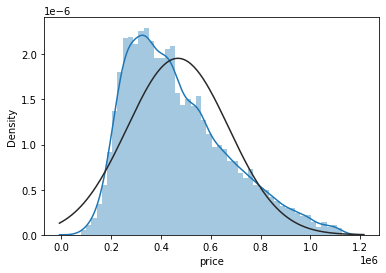

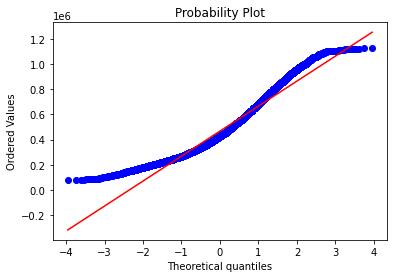

In [30]:
#histogram and normal probability plot
sns.distplot(df['price'], fit=norm);
fig = plt.figure()

res = stats.probplot(df['price'], plot=plt)

# our sales price histogram is positively skewed and has a high peak
# Our QQ-plot shows that we have heavy tails with right skew

In [31]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

# price is moderately skewed right, almost highly skewed
# some positive kurtosis, indicating more in the tails. We can see those tails in the right skew.

Skewness: 0.780069
Kurtosis: 0.078753


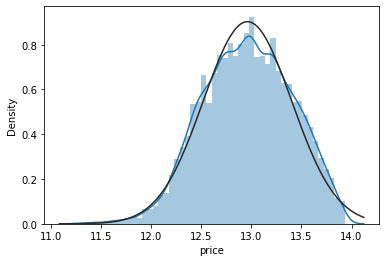

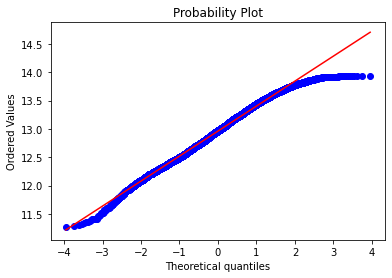

In [32]:
# log transform our target price to improve normality of distribution
df_target_log = np.log(df['price'])

#histogram and normal probability plot
sns.distplot(df_target_log, fit=norm);
fig = plt.figure()
res = stats.probplot(df_target_log, plot=plt)

# Our target price is more normally distributed now
# transforming it gives more of a left skew

### Separate Continuous and Categorical

In [33]:
# prepare our categories for data transformation by separating into our data types -
# our target dependent variable, categorical variables, and continuous/ordinal variables

target = ['price']
categoricals = ['price', 'yr_built', 'month_sold', 'zipcode', 'waterfront', 'renovated','basement', 'comparative_sf'] # , 'lat'
continuous = ['sqft_living', 'sqft_lot', 'floors', 'bedrooms', 'bathrooms', 'condition', 'grade', 'sqft_living15', 'sqft_lot15', 'sqft_above']

## Process Categoricals

In [34]:
df_categoricals = df[categoricals]

df_categoricals

price  yr_built  month_sold  zipcode  waterfront  renovated  \
0      222876.0      1955          10    98178         0.0        0.0   
1      539691.0      1951          12    98125         0.0        1.0   
2      180339.0      1933           2    98028         0.0        0.0   
3      605898.0      1965          12    98136         0.0        0.0   
4      510962.0      1987           2    98074         0.0        0.0   
...         ...       ...         ...      ...         ...        ...   
18057  362715.0      2009           5    98103         0.0        0.0   
18058  400754.0      2014           2    98146         0.0        0.0   
18059  404881.0      2009           6    98144         0.0        0.0   
18060  401006.0      2004           1    98027         0.0        0.0   
18061  326430.0      2008          10    98144         0.0        0.0   

       basement comparative_sf  
0           0.0              2  
1           1.0              3  
2           0.0              1  
3           1.0              3  
4           0.0              2  
...         ...            ...  
18057       0.0              2  
18058       0.0              3  
18059       0.0              2  
18060       0.0              2  
18061       0.0              2  

[18062 rows x 8 columns]

Let's look at mean price by month and see if there are any better insights.

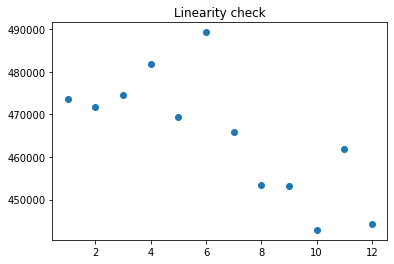

In [35]:
monthly_prices = df_categoricals.groupby('month_sold')['price'].mean()
month = df_categoricals['month_sold'].unique()

plt.scatter(month, monthly_prices)
plt.title("Linearity check")
plt.show()


Our average per month is all over. We are going to keep this as a categorical.

In [36]:
# binning our latitude into equally sized bins, where each bin has the same number of entries

#df_categoricals["lat_block"], lat_bins = pd.qcut(df_categoricals['lat'], q=40, retbins=True)

In [37]:
# binning our year built into equally sized bins, where each bin has the same number of entries

df_categoricals["year_block"], year_bins = pd.qcut(df_categoricals['yr_built'], q=25, retbins=True)

In [38]:
# identifying our categorical columns to one-hot encode
categorical = ['zipcode', 'waterfront', 'renovated', 'basement', 'month_sold', 'year_block', 'comparative_sf'] #  , 'lat_block'

# prepare a new dataframe that has the correct categorical columns (we aren't dropping from our df_categoricals dataframe,
# because we will be using that later still)
df_categorical_preprocess = df_categoricals[categorical]

# telling Pandas that these columns are categoricals
for item in categorical:
    df_categorical_preprocess[item] = df_categorical_preprocess[item].astype('category')

# adding price to our dataframe so that we can do some visualizations    
df_categorical_preprocess['price'] = df['price']

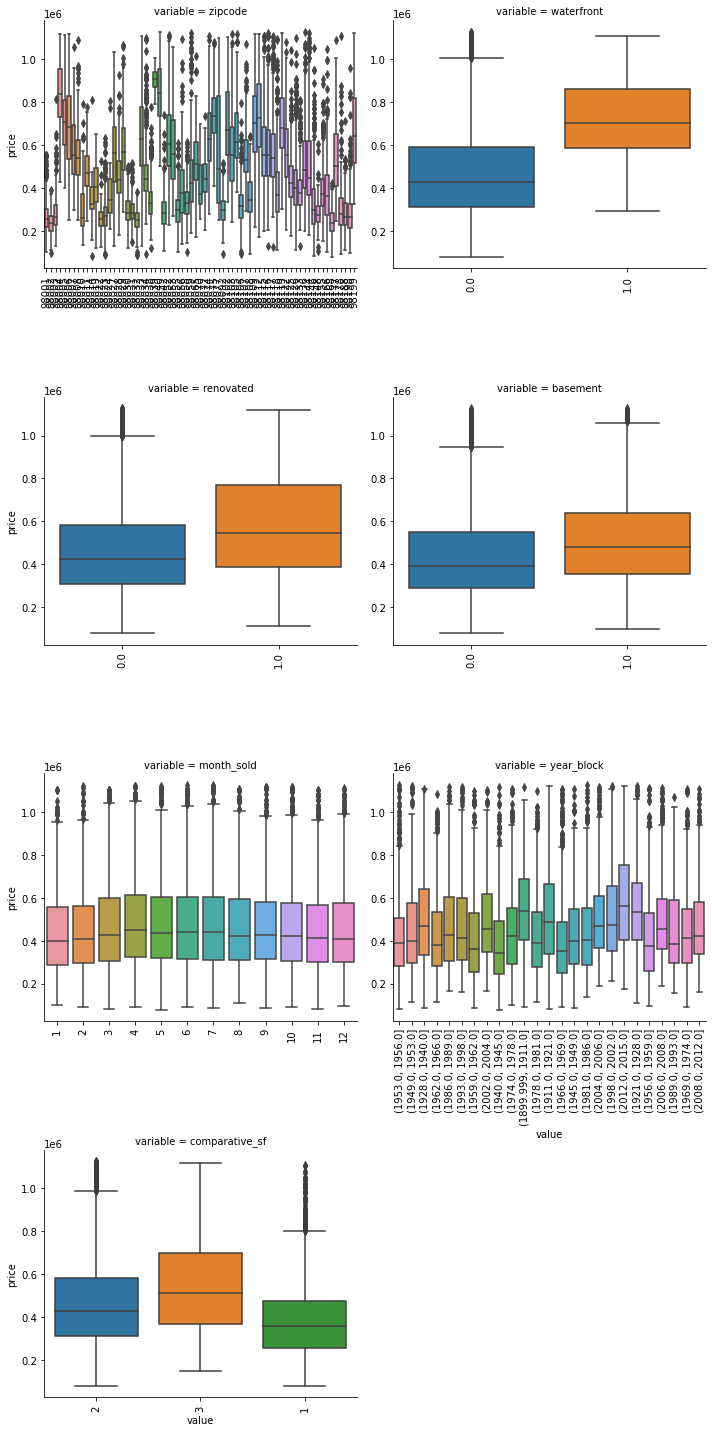

In [39]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(df_categorical_preprocess, id_vars=['price'], value_vars=categorical)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "price")

Comparative_lot, which is a variable that we produced, does not look very important. But we'll save that for our model to determine. We can visually see the impact of several of our other categorical variables. Ultimately we can see with our own eyes why many of these categories work better as very large one-hot-encoded items rather than ordinal continuous variables, even with polynomial relationship.

In [40]:
# make a processed bins file for use with linear regression
df_categoricals_processed = pd.get_dummies(df_categorical_preprocess[categorical], prefix=categorical, drop_first=True)

In [41]:
df_categoricals_processed

zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              0              0              0              0   
18061              0              0              0              0   

       zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              0              0              0              0   
18061              0              0              0              0   

       zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              0              0              0              0   
18061              0              0              0              0   

       zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              1   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              0              0              1              0   
18061              0              0              0              0   

       zipcode_98029  zipcode_98030  zipcode_98031  zipcode_98032  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
1

## Create Holdout Data

In [42]:
# set our random seed for the notebook. We could randomize this each time the notebook is run, or whatevever,
# but ultimately we want all of our train/test splits to use the same data
randomstate = 55

In [43]:
# prepare our holdout sets. We're making two separate predictor frames because the continuous variables 
# require processing after we pull this apart, so we're keeping them separate from the categoricals for now.

x_continuous = df[continuous]
x_categorical = df_categoricals_processed
y = np.log(df[target])

In [44]:
# creating our train/validation sets and our test sets

x_train_cont, x_test_cont, y_train_val, y_test = train_test_split(x_continuous, y, test_size=0.2, random_state=randomstate)
x_train_cat, x_test_cat, y_train_val, y_test = train_test_split(x_categorical, y, test_size=0.2, random_state=randomstate)

In [45]:
x_train_cont.reset_index(inplace=True)
x_train_cont.drop('index', axis=1, inplace=True)

x_test_cont.reset_index(inplace=True)
x_test_cont.drop('index', axis=1, inplace=True)

x_train_cat.reset_index(inplace=True)
x_train_cat.drop('index', axis=1, inplace=True)

x_test_cat.reset_index(inplace=True)
x_test_cat.drop('index', axis=1, inplace=True)

y_train_val.reset_index(inplace=True)
y_train_val.drop('index', axis=1, inplace=True)

y_test.reset_index(inplace=True)
y_test.drop('index', axis=1, inplace=True)

## Process Continuous/Ordinal

### Study Correlations/Multicollinearity

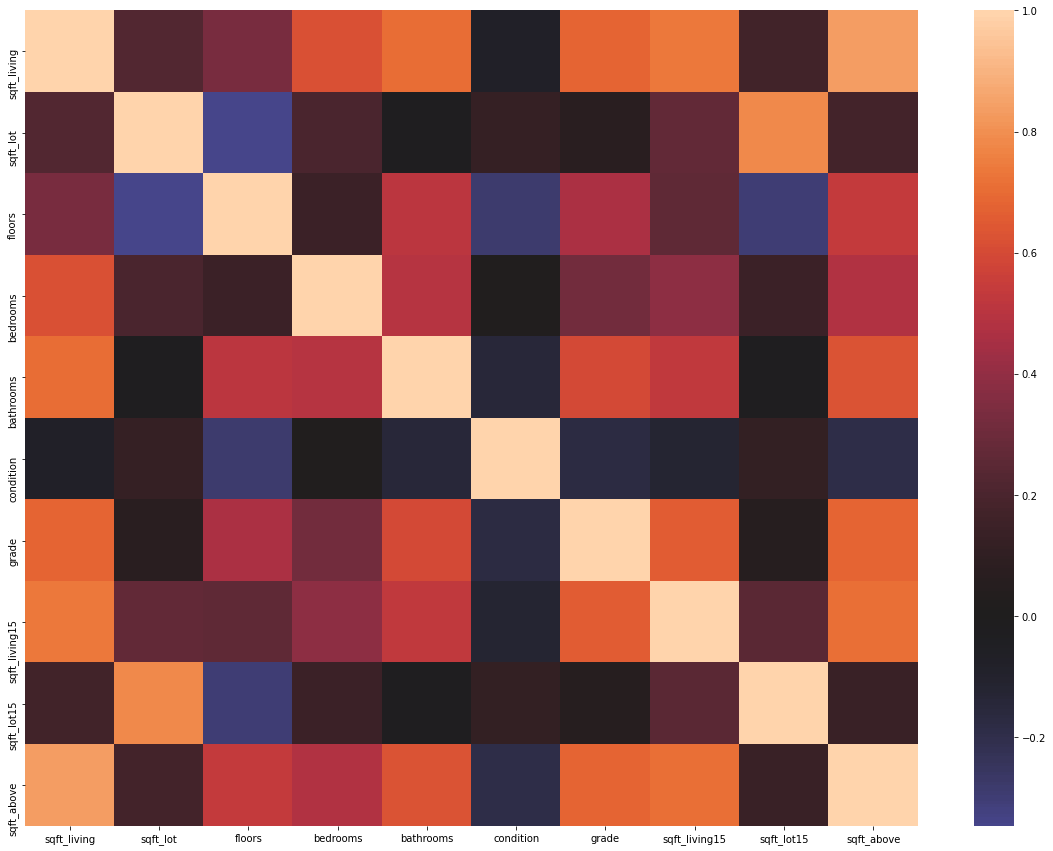

In [46]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(x_train_cont.corr(), center=0);

plt.show()

In [47]:
x_train_cont.corr()

sqft_living  sqft_lot    floors  bedrooms  bathrooms  \
sqft_living       1.000000  0.226591  0.330553  0.616530   0.705691   
sqft_lot          0.226591  1.000000 -0.346728  0.197539  -0.020042   
floors            0.330553 -0.346728  1.000000  0.147108   0.510309   
bedrooms          0.616530  0.197539  0.147108  1.000000   0.494153   
bathrooms         0.705691 -0.020042  0.510309  0.494153   1.000000   
condition        -0.071131  0.123601 -0.286327  0.021726  -0.143227   
grade             0.680005  0.065557  0.462257  0.313726   0.598633   
sqft_living15     0.738399  0.270059  0.261499  0.388848   0.522793   
sqft_lot15        0.173394  0.783623 -0.297761  0.144434  -0.018815   
sqft_above        0.838151  0.177362  0.533451  0.482191   0.625538   

               condition     grade  sqft_living15  sqft_lot15  sqft_above  
sqft_living    -0.071131  0.680005       0.738399    0.173394    0.838151  
sqft_lot        0.123601  0.065557       0.270059    0.783623    0.177362  
floors         -0.286327  0.462257       0.261499   -0.297761    0.533451  
bedrooms        0.021726  0.313726       0.388848    0.144434    0.482191  
bathrooms      -0.143227  0.598633       0.522793   -0.018815    0.625538  
condition       1.000000 -0.174058      -0.120215    0.115159   -0.185765  
grade          -0.174058  1.000000       0.655681    0.055555    0.682100  
sqft_living15  -0.120215  0.655681       1.000000    0.243899    0.713906  
sqft_lot15      0.115159  0.055555       0.243899    1.000000    0.139181  
sqft_above     -0.185765  0.682100       0.713906    0.139181    1.000000

In [48]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = x_train_cont.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation
df_correlations[df_correlations.correlation>.70]


level_0        level_1  correlation
pairs                                                                  
(sqft_above, sqft_living)        sqft_above    sqft_living     0.838151
(sqft_living, sqft_above)       sqft_living     sqft_above     0.838151
(sqft_lot15, sqft_lot)           sqft_lot15       sqft_lot     0.783623
(sqft_lot, sqft_lot15)             sqft_lot     sqft_lot15     0.783623
(sqft_living, sqft_living15)    sqft_living  sqft_living15     0.738399
(sqft_living15, sqft_living)  sqft_living15    sqft_living     0.738399
(sqft_above, sqft_living15)      sqft_above  sqft_living15     0.713906
(sqft_living15, sqft_above)   sqft_living15     sqft_above     0.713906
(sqft_living, bathrooms)        sqft_living      bathrooms     0.705691
(bathrooms, sqft_living)          bathrooms    sqft_living     0.705691

we're going to drop sqft_above and sqft_lot15 and just keep the base sqft_living and sqft_lot. We're also going to drop sqft_living15 which fell JUST under the threshold of collinearity, based on the fact that a realtor does not easily have that information available to use in our predictive model. 

In [49]:
x_train_cont.drop(['sqft_above', 'sqft_lot15', 'sqft_living15'], axis=1, inplace=True)

In [50]:
x_train_cont['price'] = y_train_val

### Check Linearity of Continuous Predictors

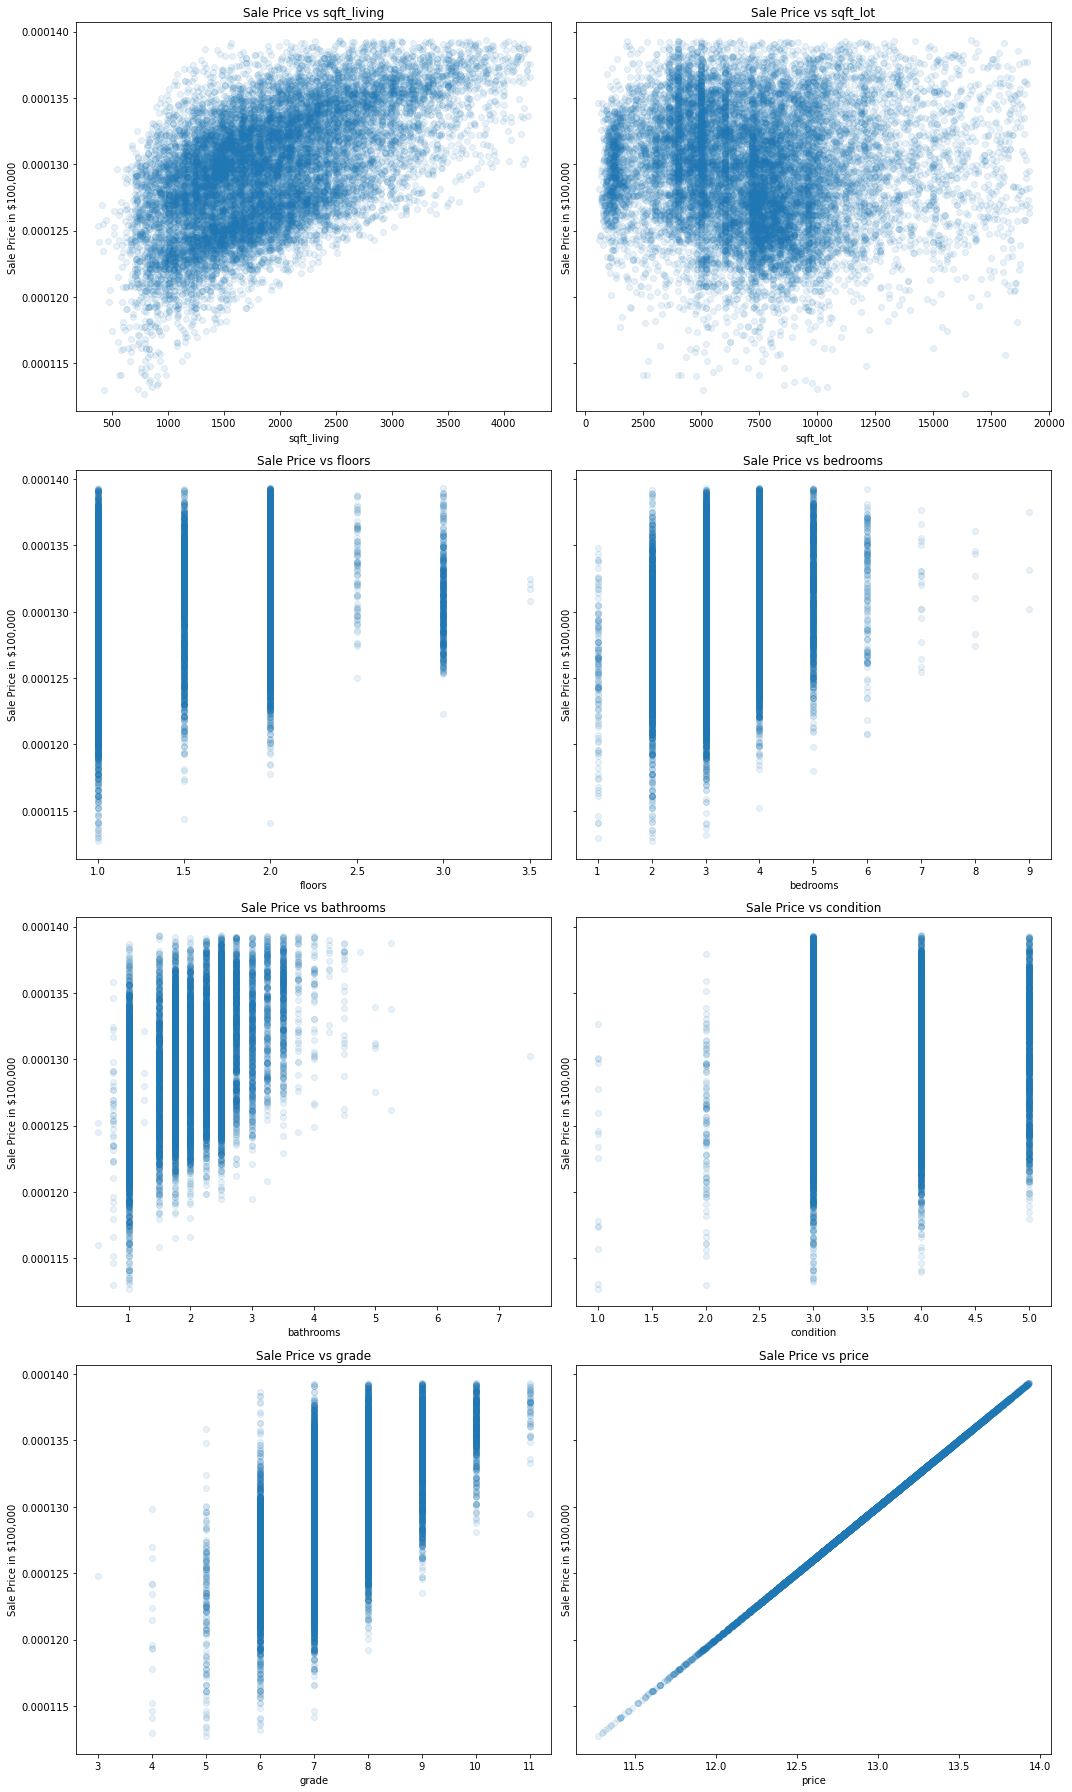

In [51]:
# check linearity

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,25), sharey=True)

for ax, column in zip(axes.flatten(), x_train_cont.columns):
    ax.scatter(x_train_cont[column], x_train_cont['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()


    * sqft_living, grade have a very strong visual relationship with price
    * bedrooms, bathrooms have a moderate visual relationship with price
    * floors, condition, sqft_lot do not appear to have a strong relationship with price

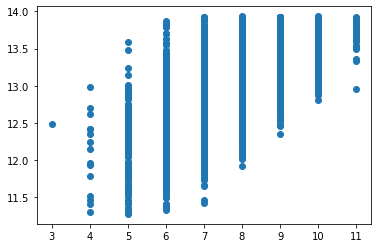

In [52]:
# grade has a very strong relationship to price

plt.scatter(x=x_train_cont['grade'], y=x_train_cont['price']);

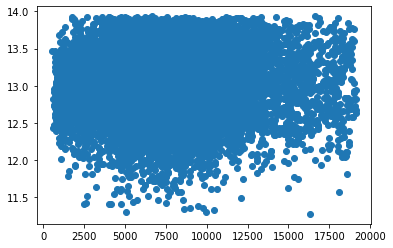

In [53]:
plt.scatter(x=x_train_cont['sqft_lot'], y=x_train_cont['price']);

# this variable does not appear to have a very linear relationship with the target variable.

Fun fact - "grade" was not well defined in the features list. I looked it up and found that grade is "	Classification by construction quality which refers to the types of materials used and the quality of workmanship. Buildings of better quality (higher grade) cost more to build per unit of measure and command higher value." So, it's the quality of building materials, and DEFINITELY worth keeping in our model.

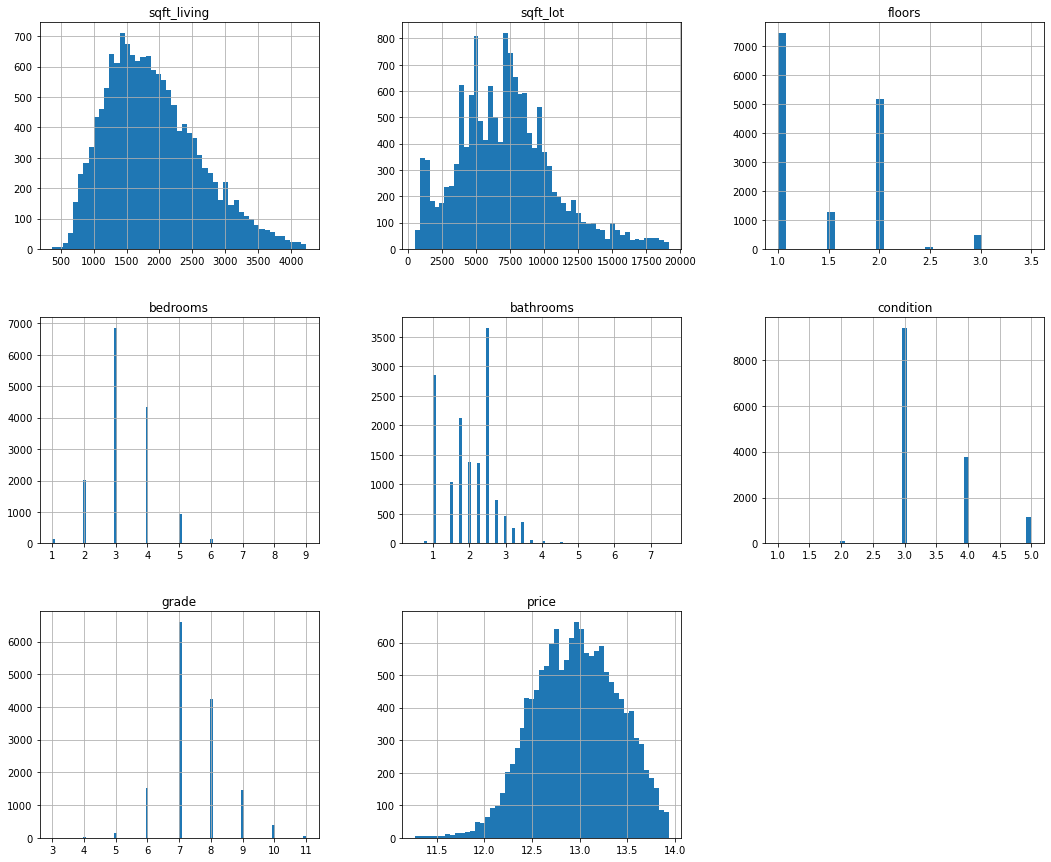

In [54]:
# check out our histograms

x_train_cont.hist(figsize=(18,15), bins='auto');


### Transform and Standardize

In [55]:
# We're going to transform all of these.

# log features
#log_names = [f'{column}' for column in x_train_cont.columns]

#x_train_cont_log = np.log(x_train_cont)
#x_train_cont_log.columns = log_names

In [56]:
# check out our histograms for our transformed data

#x_train_cont_log.hist(figsize=(18,15), bins='auto');

# looks more normal

In [57]:
# check linearity

'''
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), x_train_cont_log.columns):
    ax.scatter(x_train_cont_log[column], x_train_cont['price']/100000, label=column, alpha=.1)
    ax.set_title(f'Sale Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Sale Price in $100,000')

fig.tight_layout()
'''

"\nfig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,15), sharey=True)\n\nfor ax, column in zip(axes.flatten(), x_train_cont_log.columns):\n    ax.scatter(x_train_cont_log[column], x_train_cont['price']/100000, label=column, alpha=.1)\n    ax.set_title(f'Sale Price vs {column}')\n    ax.set_xlabel(column)\n    ax.set_ylabel('Sale Price in $100,000')\n\nfig.tight_layout()\n"

In [58]:
#plt.scatter(x=x_train_cont_log['sqft_lot'], y=x_train_cont['price']);

# log transforming sqft_lot did not help much. This variable simply does not appear to have a great linear relationship with our target variable.

In [59]:
#plt.scatter(x=x_train_cont_log['age_mean'], y=x_train_cont['price']);

# transformation has done nothing for age. It doesn't appear to have any relationship to price.

In [60]:
#plt.scatter(x=x_train_cont_log['zip_mean'], y=x_train_cont['price']);

# fairly strong relationship

In [61]:
x_train_cont.drop('price', axis=1, inplace=True)

In [62]:
# standardize all of our values with scikit-learn StandardScaler

scaler = StandardScaler()

#transformed_scaled_continuous = pd.DataFrame(scaler.fit_transform(x_train_cont_log),columns = x_train_cont_log.columns)
transformed_scaled_continuous = pd.DataFrame(scaler.fit_transform(x_train_cont),columns = x_train_cont.columns)

In [63]:
transformed_scaled_continuous

sqft_living  sqft_lot    floors  bedrooms  bathrooms  condition  \
0        -0.244450 -1.743650  3.713471 -0.355831   1.393722  -0.630748   
1         1.046022  0.330819 -0.873997  0.783158   1.036147  -0.630748   
2        -0.315355 -0.893871  0.960990 -0.355831   0.678572  -0.630748   
3        -0.754966 -0.631943  0.960990 -0.355831   0.320998  -0.630748   
4         0.507143  1.491797 -0.873997  1.922147  -0.036577   0.903800   
...            ...       ...       ...       ...        ...        ...   
14444     0.847488  0.299388 -0.873997 -0.355831  -0.394151   0.903800   
14445    -0.981862  0.713093 -0.873997 -1.494819  -0.394151  -0.630748   
14446    -0.145183 -0.773526  0.960990  0.783158   0.320998   0.903800   
14447     2.478303  3.112353  0.960990  0.783158   2.824020  -0.630748   
14448     0.351152  0.071440  0.960990 -0.355831   0.678572  -0.630748   

          grade  
0      0.549761  
1      0.549761  
2     -0.475736  
3     -0.475736  
4      0.549761  
...         ...  
14444 -0.475736  
14445 -0.475736  
14446  0.549761  
14447  1.575259  
14448  0.549761  

[14449 rows x 7 columns]

## Final Prep for Linear Regression

In [64]:
X_train_val = transformed_scaled_continuous.join([x_train_cat], how='inner')

In [65]:
X_train_val

sqft_living  sqft_lot    floors  bedrooms  bathrooms  condition  \
0        -0.244450 -1.743650  3.713471 -0.355831   1.393722  -0.630748   
1         1.046022  0.330819 -0.873997  0.783158   1.036147  -0.630748   
2        -0.315355 -0.893871  0.960990 -0.355831   0.678572  -0.630748   
3        -0.754966 -0.631943  0.960990 -0.355831   0.320998  -0.630748   
4         0.507143  1.491797 -0.873997  1.922147  -0.036577   0.903800   
...            ...       ...       ...       ...        ...        ...   
14444     0.847488  0.299388 -0.873997 -0.355831  -0.394151   0.903800   
14445    -0.981862  0.713093 -0.873997 -1.494819  -0.394151  -0.630748   
14446    -0.145183 -0.773526  0.960990  0.783158   0.320998   0.903800   
14447     2.478303  3.112353  0.960990  0.783158   2.824020  -0.630748   
14448     0.351152  0.071440  0.960990 -0.355831   0.678572  -0.630748   

          grade  zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0      0.549761              0              0              0              0   
1      0.549761              0              0              0              0   
2     -0.475736              0              0              0              0   
3     -0.475736              0              0              0              0   
4      0.549761              0              0              0              0   
...         ...            ...            ...            ...            ...   
14444 -0.475736              0              0              0              0   
14445 -0.475736              0              0              0              0   
14446  0.549761              0              0              0              0   
14447  1.575259              0              0              0              0   
14448  0.549761              0              0              0              0   

       zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
14444              0              0              0              0   
14445              0              0              0              0   
14446              0              0              0              0   
14447              1              0              0              0   
14448              0              0              0              0   

       zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              1              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
14444              0              0              0              0   
14445              0              0              0              0   
14446              0              0              0              0   
14447              0              0              0              0   
14448              0              0              0              0   

       zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
14444              0        

### Process Holdout

In [66]:
x_test_cont.drop(['sqft_above', 'sqft_lot15', 'sqft_living15'], axis=1, inplace=True)

In [67]:
x_test_cont

sqft_living  sqft_lot  floors  bedrooms  bathrooms  condition  grade
0            2110     16200     1.0         4       2.25          3      8
1            2030      7350     1.0         4       1.75          3      8
2            2290      6300     1.5         4       1.00          4      7
3            1070      6110     1.0         3       1.75          4      7
4            1530      1786     2.0         3       3.25          3      8
...           ...       ...     ...       ...        ...        ...    ...
3608         1360     10726     1.0         3       1.50          4      7
3609         1370      9460     1.0         2       1.00          3      6
3610         1480      7560     1.5         4       1.00          3      7
3611         1060      7868     1.0         2       1.00          3      7
3612         1600      2538     2.0         3       1.75          3      7

[3613 rows x 7 columns]

In [68]:
# We're going to transform all of these.

# log features
#log_names = [f'{column}' for column in x_test_cont.columns]

#holdout_log = np.log(x_test_cont)
#holdout_log.columns = log_names

In [69]:
# standardize all of our values with scikit-learn StandardScaler

#holdout_scaled = pd.DataFrame(scaler.transform(holdout_log),columns = holdout_log.columns)
holdout_scaled = pd.DataFrame(scaler.transform(x_test_cont),columns = x_test_cont.columns)

In [70]:
X_test = holdout_scaled.join([x_test_cat])

In [71]:
X_test

sqft_living  sqft_lot    floors  bedrooms  bathrooms  condition  \
0        0.294428  2.539509 -0.873997  0.783158   0.320998  -0.630748   
1        0.180980  0.033496 -0.873997  0.783158  -0.394151  -0.630748   
2        0.549686 -0.263828  0.043497  0.783158  -1.466875   0.903800   
3       -1.180396 -0.317629 -0.873997 -0.355831  -0.394151   0.903800   
4       -0.528070 -1.542036  0.960990 -0.355831   1.751296  -0.630748   
...           ...       ...       ...       ...        ...        ...   
3608    -0.769147  0.989462 -0.873997 -0.355831  -0.751726   0.903800   
3609    -0.754966  0.630975 -0.873997 -1.494819  -1.466875  -0.630748   
3610    -0.598975  0.092960  0.043497  0.783158  -1.466875  -0.630748   
3611    -1.194577  0.180175 -0.873997 -1.494819  -1.466875  -0.630748   
3612    -0.428803 -1.329096  0.960990 -0.355831  -0.394151  -0.630748   

         grade  zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0     0.549761              0              0              0              0   
1     0.549761              0              0              0              0   
2    -0.475736              0              0              0              0   
3    -0.475736              1              0              0              0   
4     0.549761              0              0              0              0   
...        ...            ...            ...            ...            ...   
3608 -0.475736              0              0              0              0   
3609 -1.501233              0              0              1              0   
3610 -0.475736              0              0              0              0   
3611 -0.475736              0              0              0              0   
3612 -0.475736              0              0              0              0   

      zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0                 0              0              0              0   
1                 0              0              1              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609              0              0              0              0   
3610              0              0              0              0   
3611              0              0              0              0   
3612              0              0              0              0   

      zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609              0              0              0              0   
3610              0              0              0              0   
3611              0              0              0              0   
3612              0              0              0              0   

      zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609          

In [72]:
test_actual = np.exp(y_test['price']).astype(int)
test_actual

0       491232
1       565709
2       829147
3       195122
4       562112
         ...  
3608    370464
3609    720905
3610    441936
3611    295320
3612    846062
Name: price, Length: 3613, dtype: int32

# Model Explorations

We're going to evaluate a few different variations of our linear regression model, as well as a few more complex model types. In order to keep track of our results, we'll be making a dictionary to store our model accuracy results.

In [73]:
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = []

## Base Linear Regression Model

Run a base model with no cross-validation or specific feature selection to see our base model scores.

In [74]:
predictors_train = sm.add_constant(X_train_val)
model = sm.OLS(y_train_val, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     709.1
Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:57:03   Log-Likelihood:                 4983.6
No. Observations:               14449   AIC:                            -9735.
Df Residuals:                   14333   BIC:                            -8856.
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          12.5885      0.016    774.451      0.000      12.557      12.620
sqft_living                     0.1798      0.003     57.515      0.000       0.174       0.186
sqft_lot                        0.0232      0.002     10.513      0.000       0.019       0.028
floors                         -0.0135      0.002     -5.386      0.000      -0.018      -0.009
bedrooms                        0.0004      0.002      0.208      0.835      -0.003       0.004
bathrooms                       0.0216      0.003      8.359      0.000       0.017       0.027
condition                       0.0376      0.002     22.553      0.000       0.034       0.041
grade                           0.1017      0.002     41.146      0.000       0.097       0.107
zipcode_98002                  -0.0372      0.018     -2.030      0.042      -0.073      -0.001
zipcode_98003                   0.0219      0.016      1.332      0.183      -0.010       0.054
zipcode_98004                   1.0589      0.020     53.161      0.000       1.020       1.098
zipcode_98005                   0.7716      0.022     35.766      0.000       0.729       0.814
zipcode_98006                   0.6352      0.016     40.927      0.000       0.605       0.666
zipcode_98007                   0.6500      0.021     31.437      0.000       0.609       0.691
zipcode_98008                   0.6758      0.017     39.842      0.000       0.643       0.709
zipcode_98010                   0.1447      0.031      4.609      0.000       0.083       0.206
zipcode_98011                   0.4581      0.019     24.681      0.000       0.422       0.495
zipcode_98014                   0.3253      0.031     10.492      0.000       0.265       0.386
zipcode_98019                   0.3157      0.020     15.597      0.000       0.276       0.355
zipcode_98022                   0.0010      0.019      0.051      0.960      -0.037       0.039
zipcode_98023                  -0.0278      0.014     -1.923      0.054      -0.056       0.001
zipcode_98024                   0.3455      0.039      8.786      0.000       0.268       0.423
zipcode_98027                   0.5816      0.017     34.419      0.000       0.548       0.615
zipcode_98028                   0.4195      0.017     25.113      0.000       0.387       0.452
zipcode_98029                   0.6041      0.016     37.351      0.000       0.572       0.636
zipcode_98030                   0.0381      0.017      2.239      0.025       0.005       0.071
zipcode_98031                   0.0700      0.017      4.220      0.000       0.037       0.102
zipcode_98032                  -0.0130      0.021     -0.604      0.546      -0.055       0.029
zipcode_98033                   0.7448      0.015     48.296      0.000       0.715       0.775
zipcode_980

Perform cross-validation with our base model over 5 splits and get our mean R^2.

In [75]:
model = LinearRegression()
model.fit(X_train_val, y_train_val)
cv_5 = cross_val_score(model, X_train_val, y_train_val, cv=5)
r2 = cv_5.mean()
r2

0.8472457282860182

In [76]:
# How many predictors are in our base model?
print("{} predictors used for this model".format(X_train_val.shape[1]))

115 predictors used for this model


In [77]:
# apply our model to our test set and get predicted values
test_predictions = model.predict(X_test)
test_predictions

# reverse log transform our predicted values
test_predictions_unscaled = np.exp(test_predictions)
test_predictions_unscaled = test_predictions_unscaled.flatten().astype(int)

residuals = test_actual - test_predictions_unscaled

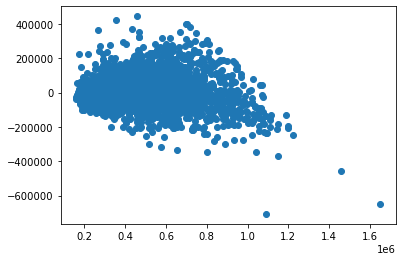

In [78]:
plt.scatter(test_predictions_unscaled, residuals)

# our residuals show some heteroskedasticity
# but our model's Durbin-Watson score falls between 1 and 2, which is still acceptable
# Just BARELY - at 1.983

In [79]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
mae

58842.39

In [80]:
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)
rmse

13383.61

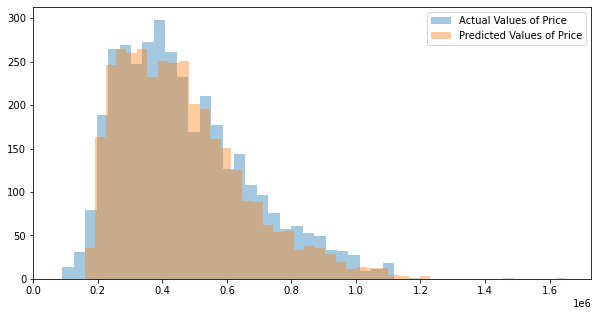

In [81]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(test_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [82]:
models['Models'].append('Basic LR')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

### Study Residuals

In [83]:
# We need our statsmodels model again to plot residuals
predictors_train = sm.add_constant(X_train_val)
model = sm.OLS(y_train_val, predictors_train).fit()

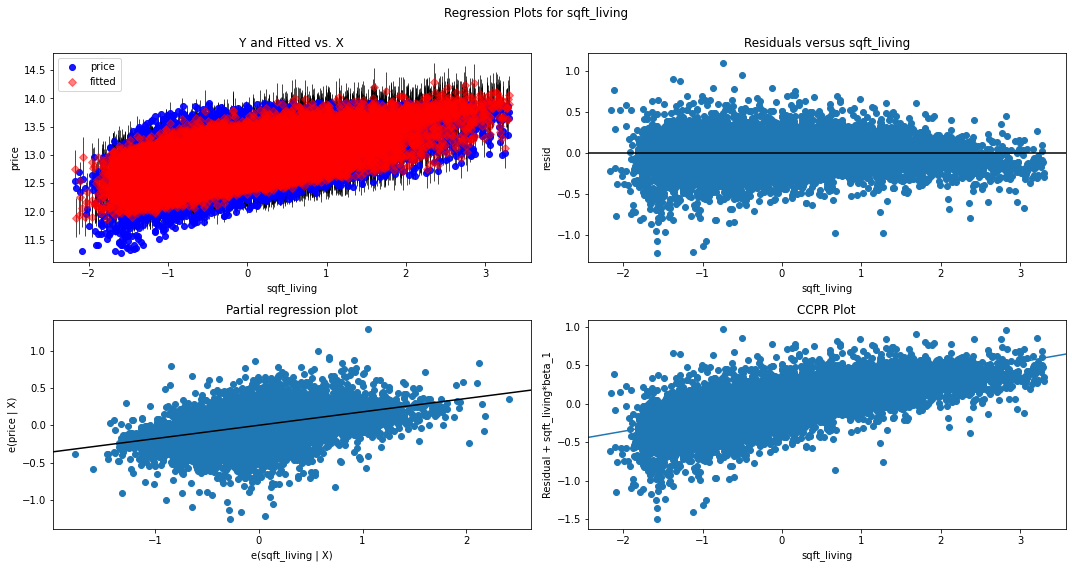

In [84]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

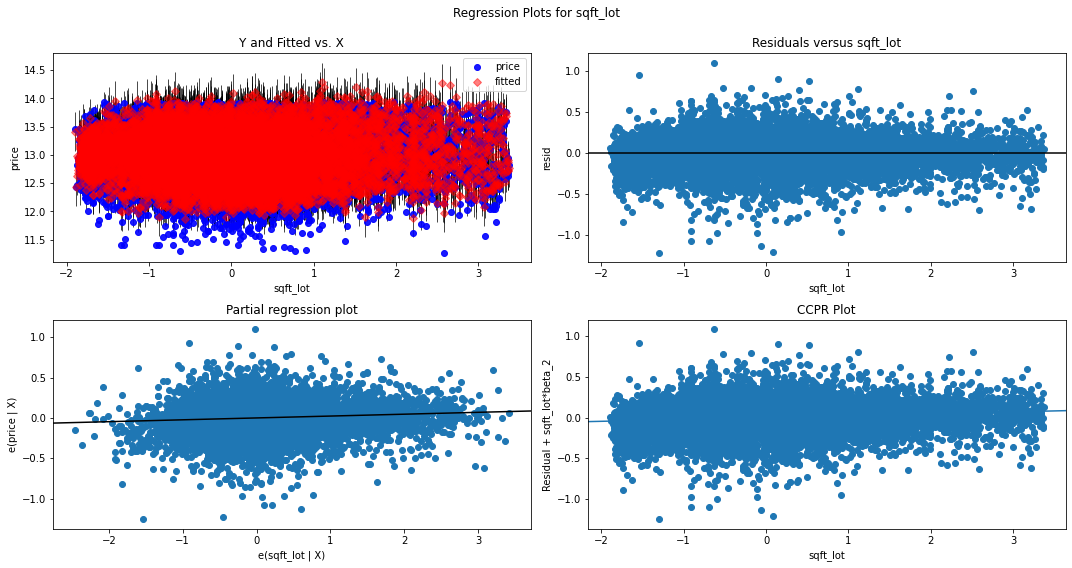

In [85]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_lot", fig=fig)
plt.show()

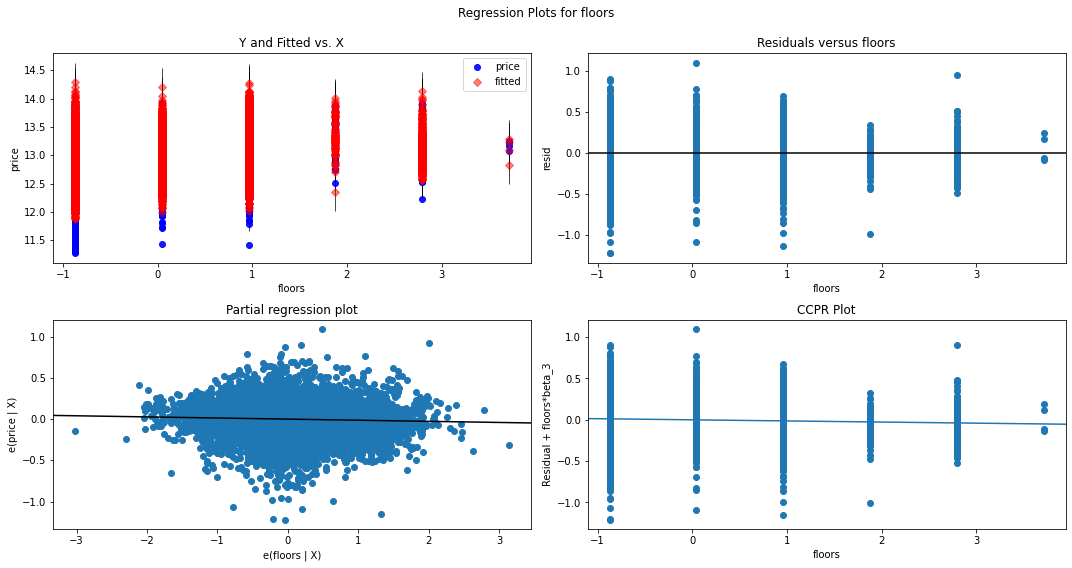

In [86]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "floors", fig=fig)
plt.show()

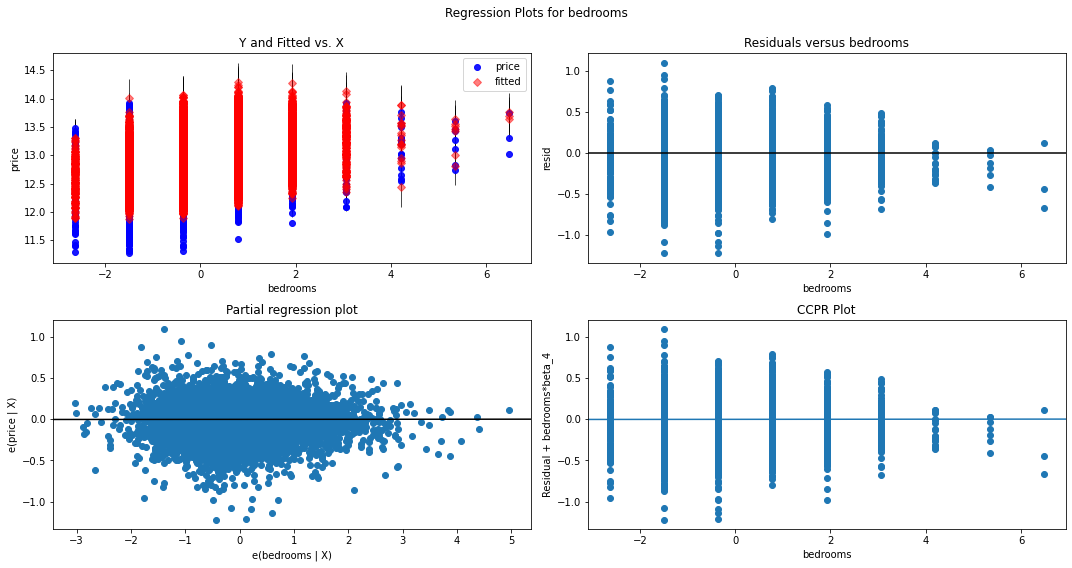

In [87]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bedrooms", fig=fig)
plt.show()

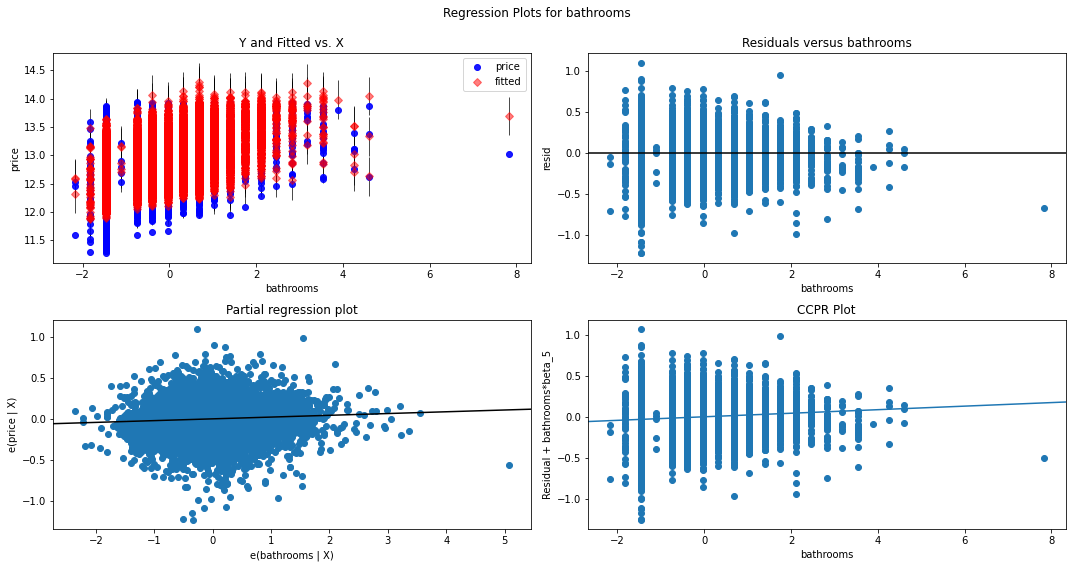

In [88]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "bathrooms", fig=fig)
plt.show()

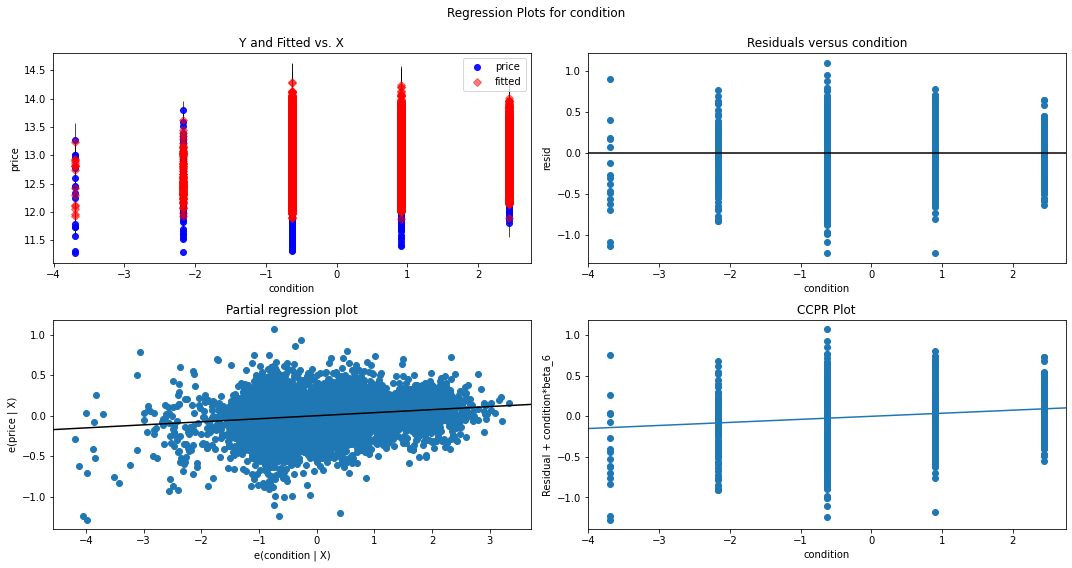

In [89]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "condition", fig=fig)
plt.show()

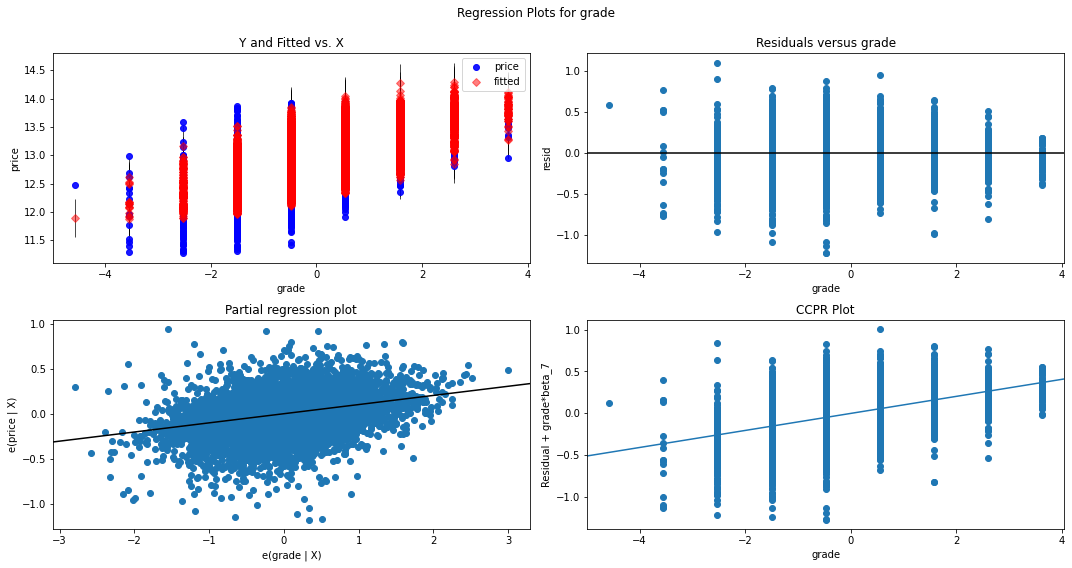

In [90]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "grade", fig=fig)
plt.show()

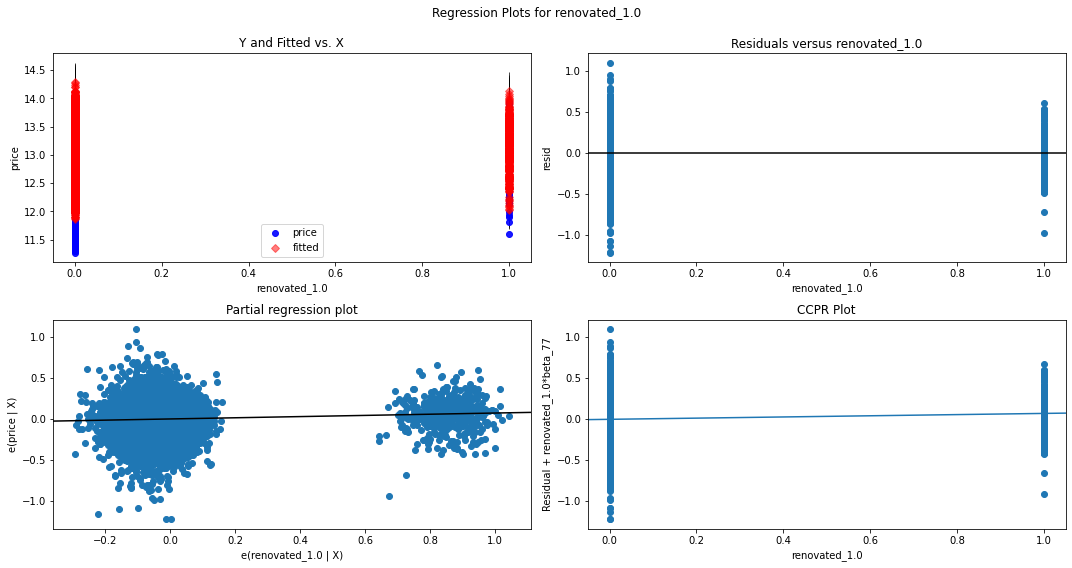

In [91]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "renovated_1.0", fig=fig)
plt.show()

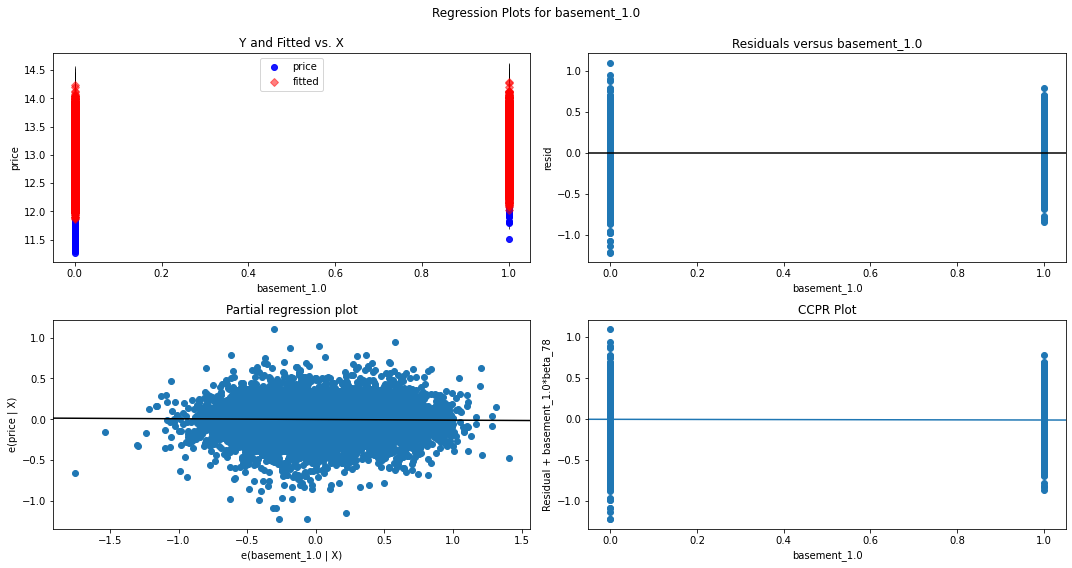

In [92]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "basement_1.0", fig=fig)
plt.show()

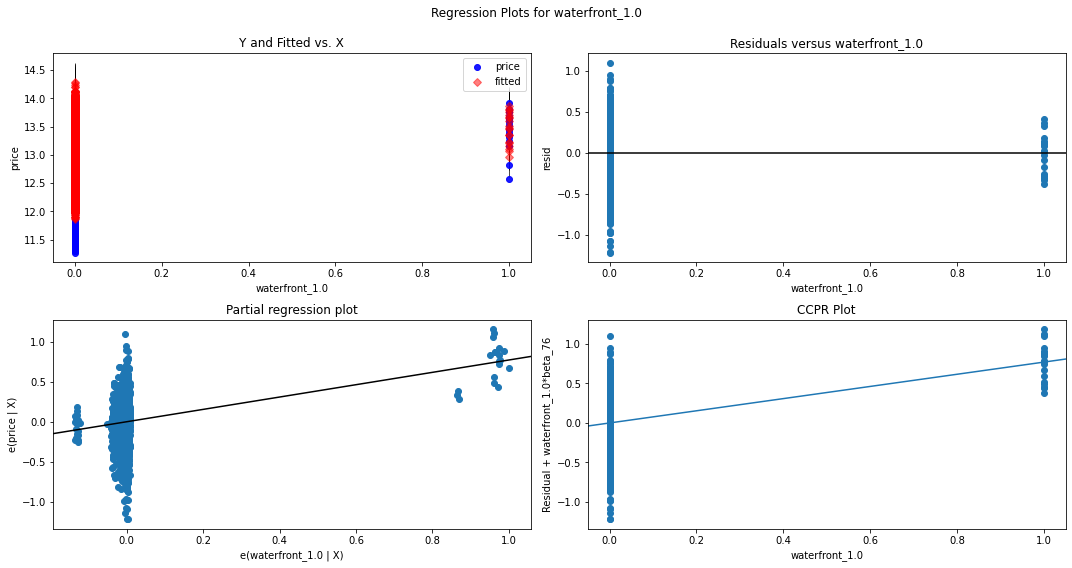

In [93]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "waterfront_1.0", fig=fig)
plt.show()

### Find/Add Interactions

I wrote a function which finds all of the feature combinations possible in our dataset. Then for each combination, the function runs a linear regression with cross validation on 5 folds and gets the r^2 score for the regression including that feature combination. All scores are recorded and r^2 score improvement is assessed, with the resulting table giving the increase in model improvement from a feature combo. 

In [94]:
def test_feature_combinations(price, variables):
    
    """Function takes in target price and a dataframe of independent variables, and 
    tests model improvement for each combination of variables"""
    
    # select our estimator and our cross validation plan
    regression = LinearRegression()
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    
    # prepare our scoring dataframe
    scoring_df = pd.DataFrame()
    
    # prepare our lists to store our features and scores as we iterate
    scores = []
    feature1 = []
    feature2 = []
    
    # Get a list of all of our features, and remove our target variable 'price' from the list
    features = list(variables.columns)

    # make a list of all of our possible feature combinations
    feature_combos = itertools.combinations(features, 2)
    feature_combos = list(feature_combos)
    
    # set our y-value as our target variable
    y = price
    
    # prepare our x-value with our independent variables. We do an initial split here in order to run a 
    # linear regression to get a base r^2 on our basic model without interactions
    X = variables
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
    base_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)   
    print("Model base score is ",base_score)
    
    # now we run the regression on each feature combo
    for feature in feature_combos:
        feat1, feat2 = feature[0], feature[1]
        
        # create the test interaction on our data set
        variables['test_interaction'] = variables[feat1] * variables[feat2]
        # create a new X which includes the test interaction and drops our target value
        X = variables
        # make a new split so that our x-splits include the test interaction
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)
        
        # Run a linear regression with cross-val just like our base model, and append the score to our scores list
        new_score = round(np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=cv)), 4)
        scores.append(new_score)
        # put feature 1 on a list
        feature1.append(feat1)
        # put feature 2 on a list
        feature2.append(feat2)
        print(feat1, feat2, new_score)
        
        
    
    # load all of our lists into the scoring dataframe
    scoring_df['feature1'] = feature1
    scoring_df['feature2'] = feature2
    scoring_df['scores'] = scores
    scoring_df['improvement'] = scoring_df['scores'] - base_score
    variables.drop('test_interaction', axis=1, inplace=True)
    
    # return our scoring dataframe to the function
    return scoring_df

In [95]:
# running our function on our continuous variables to look for improvement
# our R2 is much lower for model base score because we aren't including our categorical variables in this improvement assessment

scoring_df = test_feature_combinations(y_train_val, transformed_scaled_continuous)

Model base score is  0.4652
sqft_living sqft_lot 0.4669
sqft_living floors 0.4672
sqft_living bedrooms 0.4652
sqft_living bathrooms 0.4657
sqft_living condition 0.469
sqft_living grade 0.4676
sqft_lot floors 0.4651
sqft_lot bedrooms 0.4659
sqft_lot bathrooms 0.4678
sqft_lot condition 0.4655
sqft_lot grade 0.4656
floors bedrooms 0.4651
floors bathrooms 0.4662
floors condition 0.4693
floors grade 0.466
bedrooms bathrooms 0.4653
bedrooms condition 0.4658
bedrooms grade 0.4653
bathrooms condition 0.47
bathrooms grade 0.4661
condition grade 0.4679


In [96]:
# showing our improvement scores for our interactions

scoring_df.sort_values('improvement', ascending=False)

feature1   feature2  scores  improvement
18    bathrooms  condition  0.4700       0.0048
13       floors  condition  0.4693       0.0041
4   sqft_living  condition  0.4690       0.0038
20    condition      grade  0.4679       0.0027
8      sqft_lot  bathrooms  0.4678       0.0026
5   sqft_living      grade  0.4676       0.0024
1   sqft_living     floors  0.4672       0.0020
0   sqft_living   sqft_lot  0.4669       0.0017
12       floors  bathrooms  0.4662       0.0010
19    bathrooms      grade  0.4661       0.0009
14       floors      grade  0.4660       0.0008
7      sqft_lot   bedrooms  0.4659       0.0007
16     bedrooms  condition  0.4658       0.0006
3   sqft_living  bathrooms  0.4657       0.0005
10     sqft_lot      grade  0.4656       0.0004
9      sqft_lot  condition  0.4655       0.0003
15     bedrooms  bathrooms  0.4653       0.0001
17     bedrooms      grade  0.4653       0.0001
2   sqft_living   bedrooms  0.4652       0.0000
6      sqft_lot     floors  0.4651      -0.0001
11       floors   bedrooms  0.4651      -0.0001

We won't add any interactions. None of these improvements were significant enough.

## Linear Regression - Feature Selectors

### Forward-Backward Selector

First we'll try a simple forward-backward feature selection model based on p-value, using a statsmodel OLS linear regression model.

This model gives us a list of the important features based on their p-value.

This model takes quite some time to run, so is commented out with the results replicated in markdown following.

In [97]:
'''
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = included[pvalues.argmax()]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


result = stepwise_selection(X_train_val, y_train_val, verbose=True)

print('resulting features:', result)
'''

result = ['grade', 'sqft_living', 'zipcode_98023', 'condition', 'zipcode_98092', 'zipcode_98004', 'zipcode_98002', 'zipcode_98058', 'zipcode_98178', 'year_block_(1921.0, 1928.0]', 'zipcode_98133', 'waterfront_1.0', 'zipcode_98040', 'year_block_(1911.0, 1921.0]', 'year_block_(1928.0, 1940.0]', 'zipcode_98119', 'month_sold_4', 'zipcode_98112', 'zipcode_98199', 'zipcode_98033', 'zipcode_98115', 'zipcode_98103', 'zipcode_98117', 'zipcode_98105', 'zipcode_98107', 'zipcode_98109', 'zipcode_98122', 'zipcode_98102', 'zipcode_98116', 'comparative_sf_3', 'zipcode_98005', 'zipcode_98136', 'zipcode_98052', 'zipcode_98008', 'zipcode_98006', 'zipcode_98053', 'renovated_1.0', 'zipcode_98039', 'zipcode_98144', 'zipcode_98029', 'zipcode_98007', 'month_sold_3', 'zipcode_98125', 'zipcode_98177', 'zipcode_98034', 'zipcode_98074', 'zipcode_98027', 'zipcode_98075', 'zipcode_98126', 'zipcode_98118', 'sqft_lot', 'year_block_(2012.0, 2015.0]', 'zipcode_98155', 'zipcode_98011', 'zipcode_98065', 'zipcode_98072', 'zipcode_98028', 'comparative_sf_2', 'bathrooms', 'zipcode_98077', 'zipcode_98059', 'zipcode_98108', 'zipcode_98106', 'zipcode_98056', 'zipcode_98166', 'zipcode_98019', 'zipcode_98146', 'zipcode_98014', 'zipcode_98024', 'zipcode_98038', 'zipcode_98070', 'year_block_(2006.0, 2008.0]', 'zipcode_98055', 'year_block_(2004.0, 2006.0]', 'year_block_(1974.0, 1978.0]', 'year_block_(1962.0, 1966.0]', 'year_block_(1966.0, 1969.0]', 'year_block_(1959.0, 1962.0]', 'year_block_(1956.0, 1959.0]', 'year_block_(1969.0, 1974.0]', 'year_block_(1978.0, 1981.0]', 'floors', 'year_block_(1953.0, 1956.0]', 'zipcode_98148', 'month_sold_2', 'month_sold_5', 'zipcode_98010', 'year_block_(1949.0, 1953.0]', 'zipcode_98198', 'zipcode_98188', 'zipcode_98031', 'zipcode_98168', 'basement_1.0', 'year_block_(2008.0, 2012.0]']

['grade', 'sqft_living', 'year_block_(1914.0, 1925.0]', 'lat_block_(47.375, 47.394]', 'lat_block_(47.394, 47.43]', 'lat_block_(47.43, 47.451]', 'condition', 'lat_block_(47.451, 47.474]', 'lat_block_(47.363, 47.375]', 'lat_block_(47.35, 47.363]', 'lat_block_(47.489, 47.5]', 'lat_block_(47.474, 47.489]', 'lat_block_(47.5, 47.512]', 'lat_block_(47.331, 47.35]', 'zipcode_98004', 'zipcode_98106', 'year_block_(1925.0, 1939.0]', 'lat_block_(47.655, 47.666]', 'lat_block_(47.633, 47.643]', 'lat_block_(47.674, 47.68]', 'lat_block_(47.643, 47.655]', 'lat_block_(47.666, 47.674]', 'lat_block_(47.68, 47.686]', 'zipcode_98040', 'waterfront_1.0', 'lat_block_(47.607, 47.621]', 'lat_block_(47.621, 47.633]', 'lat_block_(47.686, 47.692]', 'zipcode_98116', 'zipcode_98074', 'lat_block_(47.593, 47.607]', 'lat_block_(47.692, 47.698]', 'zipcode_98006', 'zipcode_98136', 'lat_block_(47.582, 47.593]', 'lat_block_(47.698, 47.707]', 'zipcode_98168', 'lat_block_(47.707, 47.718]', 'sqft_lot', 'zipcode_98027', 'zipcode_98014', 'year_block_(2011.0, 2015.0]', 'bedrooms', 'zipcode_98059', 'zipcode_98166', 'lat_block_(47.718, 47.727]', 'lat_block_(47.571, 47.582]', 'lat_block_(47.554, 47.564]', 'lat_block_(47.564, 47.571]', 'comparative_sf_3', 'lat_block_(47.547, 47.554]', 'zipcode_98108', 'lat_block_(47.54, 47.547]', 'lat_block_(47.727, 47.736]', 'lat_block_(47.532, 47.54]', 'zipcode_98177', 'zipcode_98032', 'renovated_1.0', 'zipcode_98019', 'zipcode_98075', 'lat_block_(47.524, 47.532]', 'lat_block_(47.736, 47.747]', 'lat_block_(47.747, 47.764]', 'lat_block_(47.764, 47.778]', 'lat_block_(47.512, 47.524]', 'basement_1.0', 'bathrooms', 'zipcode_98133', 'year_block_(1971.0, 1977.0]', 'year_block_(1962.0, 1967.0]', 'year_block_(1977.0, 1981.0]', 'year_block_(1959.0, 1962.0]', 'year_block_(1954.0, 1959.0]', 'year_block_(1967.0, 1971.0]', 'month_sold_4', 'zipcode_98112', 'zipcode_98119', 'zipcode_98102', 'zipcode_98109', 'zipcode_98024', 'zipcode_98010', 'zipcode_98038', 'month_sold_5', 'month_sold_6', 'zipcode_98039', 'zipcode_98103', 'zipcode_98117', 'zipcode_98115', 'comparative_lot_3', 'year_block_(2007.0, 2011.0]', 'zipcode_98122', 'zipcode_98199', 'zipcode_98105', 'zipcode_98107', 'zipcode_98033', 'month_sold_7', 'month_sold_3', 'zipcode_98188', 'zipcode_98070', 'zipcode_98198', 'floors', 'year_block_(1950.0, 1954.0]', 'month_sold_8', 'zipcode_98005', 'zipcode_98146', 'zipcode_98126', 'zipcode_98144', 'zipcode_98029', 'zipcode_98028', 'zipcode_98056', 'month_sold_9', 'year_block_(1981.0, 1987.0]', 'year_block_(1987.0, 1991.0]', 'year_block_(1945.0, 1950.0]', 'year_block_(1991.0, 1997.0]']

In [98]:
# Run our linear regression again, using only the features recommended by our feature selector

X_train_refined = X_train_val[result]
X_test_refined = X_test[result]

predictors_int = sm.add_constant(X_train_refined)
model = sm.OLS(y_train_val, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     863.1
Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:57:16   Log-Likelihood:                 4943.0
No. Observations:               14449   AIC:                            -9696.
Df Residuals:                   14354   BIC:                            -8976.
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          12.5541      0.007   1742.625      0.000      12.540      12.568
grade                           0.0985      0.002     41.954      0.000       0.094       0.103
sqft_living                     0.1842      0.003     64.845      0.000       0.179       0.190
zipcode_98023                  -0.0489      0.010     -4.788      0.000      -0.069      -0.029
condition                       0.0397      0.002     24.821      0.000       0.037       0.043
zipcode_98092                  -0.0351      0.013     -2.709      0.007      -0.060      -0.010
zipcode_98004                   1.0446      0.017     61.206      0.000       1.011       1.078
zipcode_98002                  -0.0544      0.015     -3.579      0.000      -0.084      -0.025
zipcode_98058                   0.1377      0.011     12.457      0.000       0.116       0.159
zipcode_98178                   0.1305      0.013      9.944      0.000       0.105       0.156
year_block_(1921.0, 1928.0]     0.0544      0.008      6.968      0.000       0.039       0.070
zipcode_98133                   0.4180      0.010     40.760      0.000       0.398       0.438
waterfront_1.0                  0.7761      0.040     19.162      0.000       0.697       0.855
zipcode_98040                   0.8563      0.017     50.913      0.000       0.823       0.889
year_block_(1911.0, 1921.0]     0.0342      0.008      4.162      0.000       0.018       0.050
year_block_(1928.0, 1940.0]     0.0240      0.008      2.949      0.003       0.008       0.040
zipcode_98119                   0.9117      0.017     54.265      0.000       0.879       0.945
month_sold_4                    0.0785      0.005     16.300      0.000       0.069       0.088
zipcode_98112                   0.9051      0.017     53.997      0.000       0.872       0.938
zipcode_98199                   0.8100      0.013     61.426      0.000       0.784       0.836
zipcode_98033                   0.7276      0.012     62.987      0.000       0.705       0.750
zipcode_98115                   0.7637      0.010     74.528      0.000       0.744       0.784
zipcode_98103                   0.7799      0.010     77.802      0.000       0.760       0.800
zipcode_98117                   0.7647      0.010     73.351      0.000       0.744       0.785
zipcode_98105                   0.8557      0.016     53.971      0.000       0.825       0.887
zipcode_98107                   0.8108      0.013     60.482      0.000       0.785       0.837
zipcode_98109                   0.9384      0.022     43.039      0.000       0.896       0.981
zipcode_98122                   0.7726      0.013     58.251      0.000       0.747       0.799
zipcode_98102                   0.9130      0.022     42.306      0.000       0.871       0.955
zipcode_981

In [99]:
print("{} predictors used".format(len(result)))

94 predictors used


In [100]:
model = LinearRegression()
model.fit(X_train_refined, y_train_val)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

cv_5 = cross_val_score(model, X_train_refined, y_train_val, cv=cv)
r2 = cv_5.mean()
r2

0.8471293346796218

In [101]:
# apply our model to our test set and get predicted values
test_predictions_refined = model.predict(X_test_refined)

# reverse log transform our predicted values
test_predictions_refined_unscaled = np.exp(test_predictions_refined)
test_predictions_refined_unscaled=test_predictions_refined_unscaled.flatten()

residuals = test_actual - test_predictions_refined_unscaled

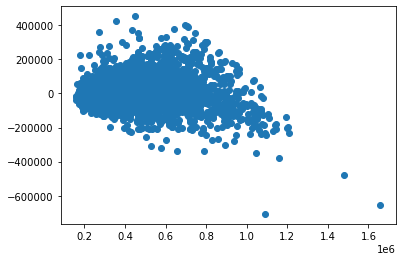

In [102]:
plt.scatter(test_predictions_refined_unscaled, residuals)

# our residuals show some heteroskedasticity
# but our model's Durbin-Watson score falls between 1 and 2, which is still acceptable
# Just BARELY - at 1.983

In [103]:
mae = round(mean_absolute_error(test_actual, test_predictions_refined_unscaled), 2)
mae

58933.09

In [104]:
rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_refined_unscaled)), 2)
rmse

84940.65

In [105]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(test_predictions_refined_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [106]:
models['Models'].append('Forw-Back Selector')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

### Permutation Importance

Next we will study feature selection via permutation importance, using a sklearn LinearRegression model and the library eli5. For permutation importance, each column is individually scrambled, and the resulting error informs the feature weight. If the scramble causes high error in the results, the feature is considered important. If the scramble causes low error, the feature is considered unimportant.

This model gives us a list of important features based on how much error scrambling their columns produces.

In [107]:
import eli5
from eli5.sklearn import PermutationImportance

regressor = LinearRegression()
regressor.fit(X_train_val, y_train_val)

perm = PermutationImportance(regressor, random_state=1).fit(X_train_val, y_train_val)
eli5.show_weights(perm, feature_names = X_train_val.columns.tolist())

In [108]:
# sorted list of relative feature importance via permutation importance - bottom 30 features

eli = pd.DataFrame(zip(X_train_val.columns.tolist(), perm.feature_importances_))
eli.sort_values(1, ascending=False, inplace=True)
eli.reset_index(inplace=True)
eli.drop('index', axis=1, inplace=True)
eli.tail(30)


0             1
85                 zipcode_98031  7.679929e-04
86                 zipcode_98148  7.553640e-04
87   year_block_(1945.0, 1949.0]  6.908955e-04
88                 zipcode_98010  5.774607e-04
89                 zipcode_98188  5.184957e-04
90   year_block_(2008.0, 2012.0]  4.825149e-04
91                 zipcode_98042  4.124884e-04
92                  month_sold_2  3.998364e-04
93                 zipcode_98168  3.920515e-04
94                  month_sold_5  3.314970e-04
95                 zipcode_98023  2.097971e-04
96   year_block_(1928.0, 1940.0]  1.648253e-04
97                 zipcode_98030  1.592522e-04
98                  basement_1.0  1.576759e-04
99                  month_sold_6  1.406173e-04
100                zipcode_98002  1.096680e-04
101                zipcode_98003  8.633901e-05
102  year_block_(1921.0, 1928.0]  7.739653e-05
103                 month_sold_8  5.120788e-05
104                month_sold_10  3.197444e-05
105                zipcode_98092  2.577453e-05
106                 month_sold_7  5.944290e-06
107  year_block_(2012.0, 2015.0]  4.507628e-06
108  year_block_(1911.0, 1921.0]  4.441866e-06
109                month_sold_11  3.713220e-06
110                zipcode_98032  2.428386e-06
111                 month_sold_9  2.347066e-06
112                     bedrooms  1.543289e-07
113                month_sold_12  3.375268e-08
114                zipcode_98022 -1.082478e-06

One thing that permutation importance does NOT do is help us pick how many features we should use. So we will just use 109, like our forward-backward selector.

In [109]:
result_eli5 = list(eli[:95][0])

In [110]:
# Run our linear regression again, using the features recommended by our feature selector

X_eli5 = X_train_val[result_eli5]

predictors_int = sm.add_constant(X_eli5)
model = sm.OLS(y_train_val, predictors_int).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     855.6
Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:57:20   Log-Likelihood:                 4955.0
No. Observations:               14449   AIC:                            -9718.
Df Residuals:                   14353   BIC:                            -8990.
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          12.5838      0.008   1668.617      0.000      12.569      12.599
sqft_living                     0.1788      0.003     62.717      0.000       0.173       0.184
zipcode_98103                   0.7851      0.010     80.982      0.000       0.766       0.804
zipcode_98115                   0.7729      0.010     78.058      0.000       0.754       0.792
zipcode_98117                   0.7734      0.010     76.347      0.000       0.753       0.793
zipcode_98052                   0.6395      0.010     66.640      0.000       0.621       0.658
zipcode_98033                   0.7500      0.011     66.384      0.000       0.728       0.772
grade                           0.1022      0.002     43.304      0.000       0.098       0.107
zipcode_98199                   0.8172      0.013     63.323      0.000       0.792       0.842
zipcode_98107                   0.8149      0.013     61.722      0.000       0.789       0.841
zipcode_98116                   0.7433      0.012     60.676      0.000       0.719       0.767
zipcode_98004                   1.0619      0.017     62.853      0.000       1.029       1.095
zipcode_98122                   0.7703      0.013     58.953      0.000       0.745       0.796
zipcode_98034                   0.5515      0.010     56.562      0.000       0.532       0.571
zipcode_98006                   0.6401      0.011     56.349      0.000       0.618       0.662
zipcode_98105                   0.8603      0.016     55.072      0.000       0.830       0.891
zipcode_98119                   0.9081      0.017     54.572      0.000       0.875       0.941
zipcode_98112                   0.9042      0.017     54.632      0.000       0.872       0.937
zipcode_98125                   0.5628      0.011     50.977      0.000       0.541       0.584
zipcode_98136                   0.6884      0.013     52.278      0.000       0.663       0.714
zipcode_98144                   0.6113      0.012     50.047      0.000       0.587       0.635
zipcode_98040                   0.8762      0.017     52.556      0.000       0.844       0.909
zipcode_98008                   0.6813      0.013     51.421      0.000       0.655       0.707
zipcode_98029                   0.6099      0.012     49.692      0.000       0.586       0.634
zipcode_98074                   0.5453      0.011     48.751      0.000       0.523       0.567
zipcode_98053                   0.6607      0.014     47.500      0.000       0.633       0.688
zipcode_98118                   0.4398      0.010     43.840      0.000       0.420       0.459
zipcode_98126                   0.5217      0.012     44.635      0.000       0.499       0.545
zipcode_98133                   0.4347      0.010     43.387      0.000       0.415       0.454
zipcode_980

In [111]:
model = LinearRegression()
model.fit(X_eli5, y_train_val)
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

cv_5 = cross_val_score(model, X_eli5, y_train_val, cv=cv)
r2 = cv_5.mean()
r2

0.8473973268865136

In [112]:
X_test_eli5 = X_test[result_eli5]

eli5_predictions = model.predict(X_test_eli5)

eli5_predictions_unscaled = np.exp(eli5_predictions)
eli5_predictions_unscaled = eli5_predictions_unscaled.flatten().astype(int)

residuals = test_actual - eli5_predictions_unscaled

In [113]:
mae = round(mean_absolute_error(test_actual, eli5_predictions_unscaled), 2)
mae

59077.17

In [114]:
rmse = round(np.sqrt(mean_squared_error(test_actual, eli5_predictions_unscaled)), 2)
rmse

14203.78

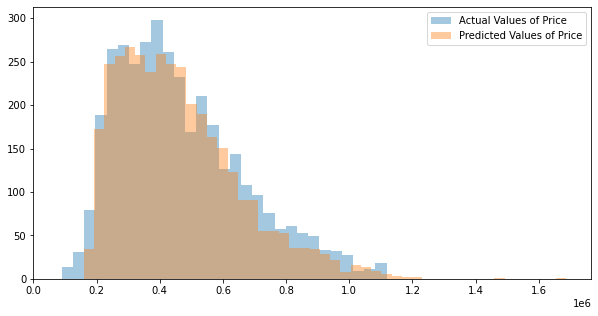

In [115]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(eli5_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

This also did not improve on our basic linear regression using all features.

In [116]:
models['Models'].append('Permutation Importance')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

### Recursive Feature Elimination with Cross Validation - Linear Regression

RFECV uses the model's scores to determine how many and which features should be included in the model. It also has integrated cross-validation, so it's a great one-step tool. RFECV is not a model itself! It takes an estimator as a parameter to use in its testing.

In [117]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

model = LinearRegression()
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error')

rfecv.fit(X_train_val, y_train_val)

RFECV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=1),
      estimator=LinearRegression(), scoring='neg_mean_absolute_error')

In [118]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 111


In [119]:
dset = pd.DataFrame()
dset['attr'] = X_train_val.columns
dset['used'] = rfecv.support_

# The fearures that RFECV did not use
dset[dset['used']==False]

attr   used
3        bedrooms  False
18  zipcode_98022  False
85   month_sold_9  False
88  month_sold_12  False

In [120]:
# make a list of the features used in the rfecv
rfecv_result = list(dset[(dset['used'] == True)]['attr'])

In [121]:
# Run our linear regression again in statsmodels, using the features recommended by our feature selector

X_train_rfecv = X_train_val[rfecv_result]
X_test_rfecv = X_test[rfecv_result]

predictors_int = sm.add_constant(X_train_rfecv)
model = sm.OLS(y_train_val, predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     734.9
Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:57:37   Log-Likelihood:                 4983.6
No. Observations:               14449   AIC:                            -9743.
Df Residuals:                   14337   BIC:                            -8894.
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          12.5884      0.014    924.183      0.000      12.562      12.615
sqft_living                     0.1800      0.003     61.555      0.000       0.174       0.186
sqft_lot                        0.0232      0.002     10.517      0.000       0.019       0.028
floors                         -0.0134      0.002     -5.385      0.000      -0.018      -0.009
bathrooms                       0.0217      0.003      8.574      0.000       0.017       0.027
condition                       0.0376      0.002     22.600      0.000       0.034       0.041
grade                           0.1016      0.002     41.509      0.000       0.097       0.106
zipcode_98002                  -0.0375      0.017     -2.201      0.028      -0.071      -0.004
zipcode_98003                   0.0216      0.015      1.428      0.153      -0.008       0.051
zipcode_98004                   1.0585      0.019     56.289      0.000       1.022       1.095
zipcode_98005                   0.7712      0.021     37.515      0.000       0.731       0.811
zipcode_98006                   0.6348      0.014     45.168      0.000       0.607       0.662
zipcode_98007                   0.6497      0.020     33.136      0.000       0.611       0.688
zipcode_98008                   0.6754      0.016     43.178      0.000       0.645       0.706
zipcode_98010                   0.1443      0.031      4.710      0.000       0.084       0.204
zipcode_98011                   0.4578      0.017     26.381      0.000       0.424       0.492
zipcode_98014                   0.3249      0.030     10.732      0.000       0.266       0.384
zipcode_98019                   0.3153      0.019     16.481      0.000       0.278       0.353
zipcode_98023                  -0.0281      0.013     -2.183      0.029      -0.053      -0.003
zipcode_98024                   0.3452      0.039      8.907      0.000       0.269       0.421
zipcode_98027                   0.5812      0.016     37.300      0.000       0.551       0.612
zipcode_98028                   0.4191      0.015     27.281      0.000       0.389       0.449
zipcode_98029                   0.6037      0.015     40.903      0.000       0.575       0.633
zipcode_98030                   0.0378      0.016      2.412      0.016       0.007       0.068
zipcode_98031                   0.0697      0.015      4.591      0.000       0.040       0.099
zipcode_98032                  -0.0132      0.020     -0.646      0.519      -0.053       0.027
zipcode_98033                   0.7444      0.014     53.437      0.000       0.717       0.772
zipcode_98034                   0.5461      0.013     42.768      0.000       0.521       0.571
zipcode_98038                   0.1515      0.013     11.935      0.000       0.127       0.176
zipcode_980

In [122]:
# getting the r2 score of our best feature set
r2 = model.rsquared
r2

0.8505100112130453

RFECV still includes features with a p-value over .05. Overall though, accuracy is just about the same as the other feature selection methods that we have tried.

We can plot the change in our R^2 score as we add features to the model. We can see that around 110 features, there isn't a lot of improvement to the model.

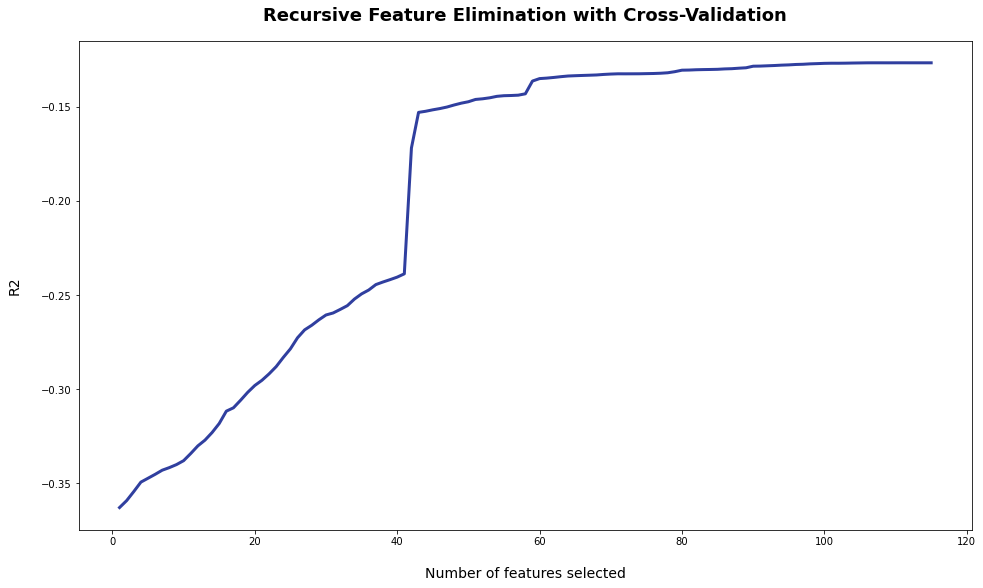

In [123]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('R2', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [124]:
rfecv_predictions = rfecv.predict(X_test)

rfecv_predictions_unscaled = np.exp(rfecv_predictions)
rfecv_predictions_unscaled = rfecv_predictions_unscaled.flatten().astype(int)

residuals = test_actual - rfecv_predictions_unscaled

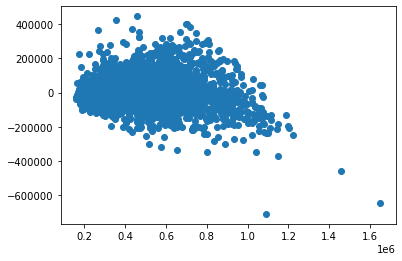

In [125]:
plt.scatter(rfecv_predictions_unscaled, residuals)

# our residuals show some heteroskedasticity
# but our model's Durbin-Watson score falls between 1 and 2, which is still acceptable
# Just BARELY - at 1.983

In [126]:
mae = round(mean_absolute_error(test_actual, rfecv_predictions_unscaled), 2)
mae

58842.36

In [127]:
rmse = round(np.sqrt(mean_squared_error(test_actual, rfecv_predictions_unscaled)), 2)
rmse

13416.2

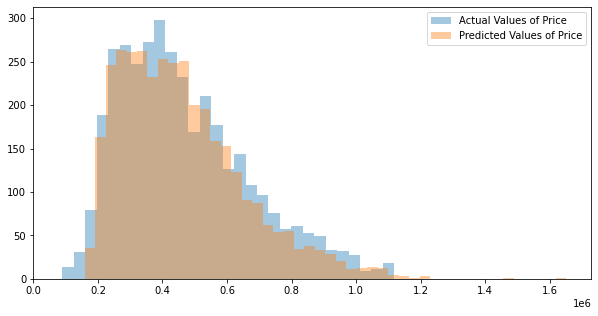

In [128]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(rfecv_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [129]:
models['Models'].append('RFECV')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

### Visualizing R2 at different features selected (OLS LR)

In [130]:
'''
# explore the number of selected features for RFE

# get a list of these_models to evaluate
def get_models():
    these_models = dict()
    for i in range(70, 151):
        rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
        these_models[str(i)] = rfe
    return these_models

# evaluate a given model using cross-validation and return r2 score for model
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, scoring='r2', cv=5, n_jobs=-1, error_score='raise')
    return scores

these_models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in these_models.items():
    scores = evaluate_model(model, X_train_val, y_train_val)
    results.append(scores)
    names.append(name)
    print('>%s features: %.3f R^squared' % (name, mean(scores)))

'''

"\n# explore the number of selected features for RFE\n\n# get a list of these_models to evaluate\ndef get_models():\n    these_models = dict()\n    for i in range(70, 151):\n        rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)\n        these_models[str(i)] = rfe\n    return these_models\n\n# evaluate a given model using cross-validation and return r2 score for model\ndef evaluate_model(model, X, y):\n    scores = cross_val_score(model, X, y, scoring='r2', cv=5, n_jobs=-1, error_score='raise')\n    return scores\n\nthese_models = get_models()\n\n# evaluate the models and store results\nresults, names = list(), list()\nfor name, model in these_models.items():\n    scores = evaluate_model(model, X_train_val, y_train_val)\n    results.append(scores)\n    names.append(name)\n    print('>%s features: %.3f R^squared' % (name, mean(scores)))\n\n"

There isn't really improvement past 134 features.

In [131]:
# plot model performance for comparison

#fig = plt.figure(figsize=(20,10))
#plt.boxplot(results, labels=names, showmeans=True)
#plt.show()

## Custom LAD Regression Model

Least Absolute Deviations model (uses MAE to optimize model)

Written by Robert Kubler: https://towardsdatascience.com/build-your-own-custom-scikit-learn-regression-5d0d718f289

In [132]:
# Prepare our custom LAD regression, using the features recommended by our forward-backward feature selector

X_train_refined = X_train_val[result]
X_test_refined = X_test[result]

In [133]:
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class LADRegression(BaseEstimator, RegressorMixin):
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        
        d = X.shape[1]
        mae_loss = lambda coefs: np.mean(np.abs(y - X@coefs[:-1] - coefs[-1]))
        *self.coef_, self.intercept_ = minimize(mae_loss, x0=np.array((d+1)*[0.])).x # the heavy lifting
        
        return self
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        return X@self.coef_ + self.intercept_

In [134]:
model = LADRegression()

model.fit(X_train_refined, y_train_val)

LADRegression()

In [135]:
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

cv_5 = cross_val_score(model, X_train_refined, y_train_val, cv=cv)
r2 = cv_5.mean()
r2

0.8453141020573479

In [136]:
predictions_LAD = model.predict(X_test_refined)
predictions_LAD_unscaled = np.exp(predictions_LAD).flatten().astype(int)

residuals = test_actual - predictions_LAD_unscaled

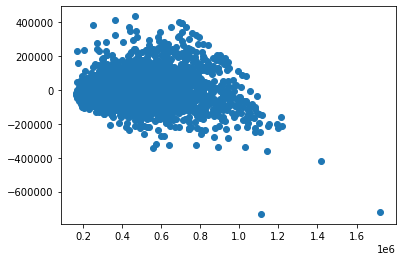

In [137]:
plt.scatter(predictions_LAD_unscaled, residuals)

# our residuals show some heteroskedasticity
# but our model's Durbin-Watson score falls between 1 and 2, which is still acceptable
# Just BARELY - at 1.983

In [138]:
mae = round(mean_absolute_error(test_actual, predictions_LAD_unscaled), 2)
mae

58831.36

In [139]:
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_LAD_unscaled)), 2)
rmse

14507.51

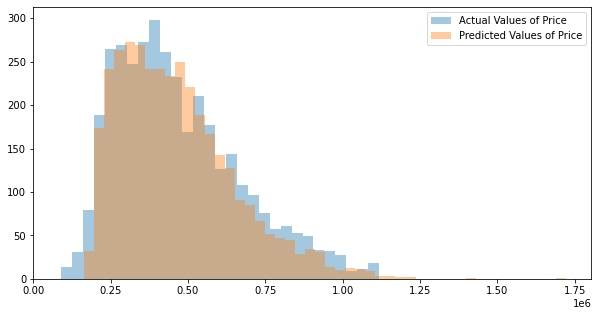

In [140]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_LAD_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [141]:
models['Models'].append('LAD Regression')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

## Regularization models

### Lasso Regression

Lasso is a regularized model. These models try to simplify the model, in order to prevent overfitting, make the model more interpretable, and simplify feature selection. Lasso will try to solve the regression using fewer features in the final model, and therefore minimizing complexity. 

Lasso assigns penalties to strong coefficients that the model may overemphasize. Some coefficients therefore end up being reduced to 0, and removed from the model.

In [142]:
parameters = {'alpha':[1, 0.1, 0.001, 0.0005]}
lasso = Lasso()
grid = GridSearchCV(lasso, parameters, scoring='neg_mean_absolute_error',cv=5)
grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1, 0.1, 0.001, 0.0005]},
             scoring='neg_mean_absolute_error')

In [143]:
print("Best parameters set found on train set: \n")
print(grid.best_params_)
print("\nGrid scores on train set:\n")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))


Best parameters set found on train set: 

{'alpha': 0.0005}

Grid scores on train set:

-0.363 (+/-0.010) for {'alpha': 1}
-0.294 (+/-0.006) for {'alpha': 0.1}
-0.149 (+/-0.002) for {'alpha': 0.001}
-0.138 (+/-0.002) for {'alpha': 0.0005}


In [144]:
lasso = Lasso(alpha = [0.0005])
lasso.fit(X_train_val, y_train_val)
cv_5 = cross_val_score(lasso, X_train_refined, y_train_val, cv=5)
r2 = cv_5.mean()
r2

0.8148092457403282

In [145]:
coef = pd.Series(lasso.coef_, index = X_train_val.columns)

In [146]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 100 variables and eliminated the other 15 variables


In [147]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

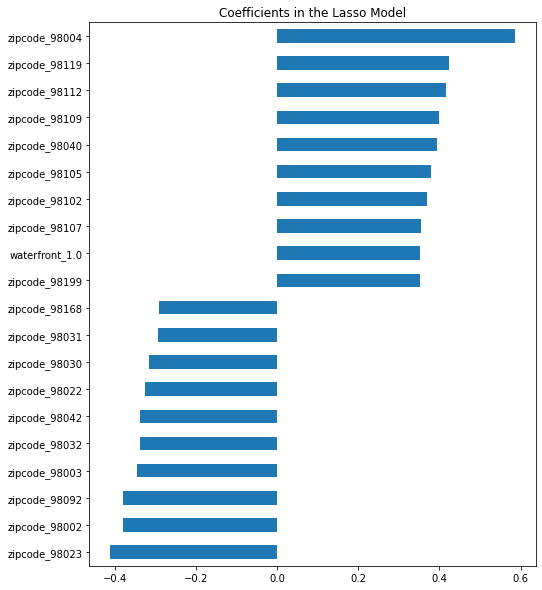

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model");

In [149]:
predictions_lasso = lasso.predict(X_test)
predictions_lasso_unscaled = np.exp(predictions_lasso)

residuals = test_actual - predictions_lasso_unscaled

In [150]:
plt.scatter(predictions_lasso_unscaled, residuals)

# our residuals show some heteroskedasticity
# but our model's Durbin-Watson score falls between 1 and 2, which is still acceptable
# Just BARELY - at 1.983

In [151]:
mae = round(mean_absolute_error(test_actual, predictions_lasso_unscaled), 2)
mae

62924.99

In [152]:
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_lasso_unscaled)), 2)
rmse

88468.61

In [153]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_lasso_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [154]:
models['Models'].append('Lasso')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

### Ridge Regression

Unlike Lasso,  Ridge does not seek to reduce coefficients. Like Lasso, it will penalize coefficients that the model overemphasizes.

In [155]:
parameters = {'alpha':[1, 0.1, 0.001, 0.0005]}
ridge = Ridge()
grid = GridSearchCV(ridge, parameters, scoring='neg_mean_absolute_error',cv=5)
grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1, 0.1, 0.001, 0.0005]},
             scoring='neg_mean_absolute_error')

In [156]:
print("Best parameters set found on train set: \n")
print(grid.best_params_)
print("\nGrid scores on train set:\n")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))


Best parameters set found on train set: 

{'alpha': 0.0005}

Grid scores on train set:

-0.128 (+/-0.004) for {'alpha': 1}
-0.127 (+/-0.004) for {'alpha': 0.1}
-0.127 (+/-0.004) for {'alpha': 0.001}
-0.127 (+/-0.004) for {'alpha': 0.0005}


In [157]:
ridge = Ridge(alpha = [0.0005])
ridge.fit(X_train_val, y_train_val)
cv_5 = cross_val_score(ridge, X_train_refined, y_train_val, cv=5)
r2 = cv_5.mean()
r2

0.8468737841032807

In [158]:
predictions_ridge = ridge.predict(X_test)
predictions_ridge_unscaled = np.exp(predictions_ridge).flatten()

residuals = test_actual - predictions_ridge_unscaled

In [159]:
plt.scatter(predictions_ridge_unscaled, residuals)

In [160]:
mae = round(mean_absolute_error(test_actual, predictions_ridge_unscaled), 2)
mae

58842.42

In [161]:
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_ridge_unscaled)), 2)
rmse

84718.92

In [162]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_ridge_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [163]:
models['Models'].append('Ridge')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

### Elastic Net Regression

Elastic Net is another regularlized model that uses elements of Lasso in penalizing over-emphasized coefficients, without eliminating any (is actually a combo of Lasso and Ridge, the latter of which penalizes coefficients in a different way from Lasso, but doesn't eliminate coefficients).

In [164]:
parameters = {'alpha':[1, 0.1, 0.001, 0.0005]}
elasticnet = ElasticNet()
grid = GridSearchCV(elasticnet, parameters, scoring='neg_mean_absolute_error',cv=5)
grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1, 0.1, 0.001, 0.0005]},
             scoring='neg_mean_absolute_error')

In [165]:
print("Best parameters set found on train set: \n")
print(grid.best_params_)
print("\nGrid scores on train set:\n")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

Best parameters set found on train set: 

{'alpha': 0.0005}

Grid scores on train set:

-0.363 (+/-0.010) for {'alpha': 1}
-0.283 (+/-0.005) for {'alpha': 0.1}
-0.140 (+/-0.002) for {'alpha': 0.001}
-0.134 (+/-0.003) for {'alpha': 0.0005}


In [166]:
elasticnet = ElasticNet(alpha = [0.0005])
elasticnet.fit(X_train_val, y_train_val)
cv_5 = cross_val_score(elasticnet, X_train_refined, y_train_val, cv=5)
r2 = cv_5.mean()
r2

0.8281648650589941

In [167]:
predictions_elastic = elasticnet.predict(X_test)
predictions_elastic_unscaled = np.exp(predictions_elastic)

In [168]:
coef = pd.Series(elasticnet.coef_, index = X_train_val.columns)

In [169]:
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Elastic Net picked 107 variables and eliminated the other 8 variables


In [170]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

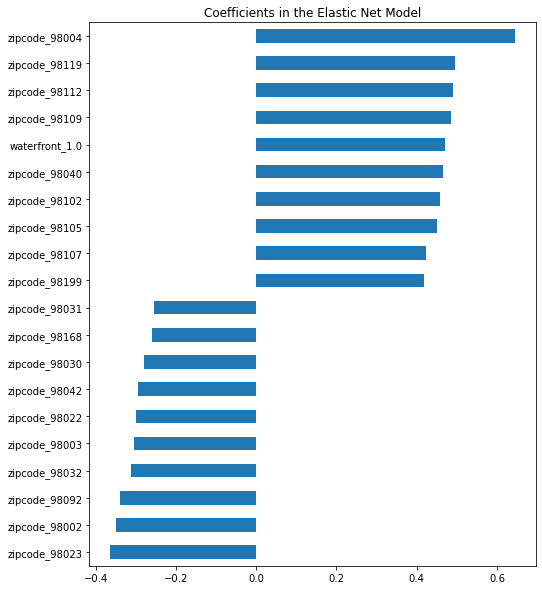

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model");

In [172]:
residuals = test_actual - predictions_elastic_unscaled

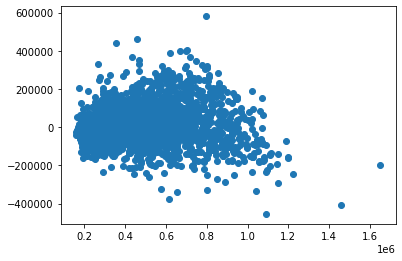

In [173]:
plt.scatter(test_predictions_unscaled, residuals)

# our residuals show some heteroskedasticity
# but our model's Durbin-Watson score falls between 1 and 2, which is still acceptable
# Just BARELY - at 1.983

In [174]:
mae = round(mean_absolute_error(test_actual, predictions_elastic_unscaled), 2)
mae

61536.13

In [175]:
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_elastic_unscaled)), 2)
rmse

86665.27

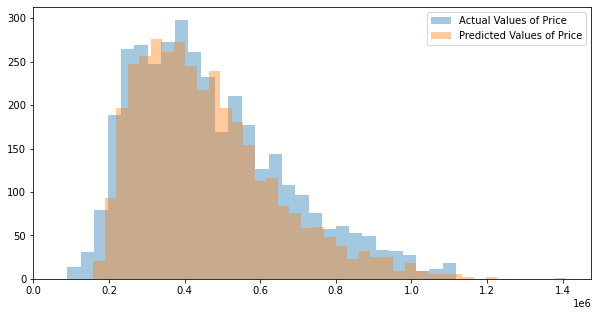

In [176]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_elastic_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [177]:
models['Models'].append('Elastic Net')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

## K-Nearest Neighbors Model

K-Nearest Neighbors is more commonly used for classification. Its basic premise is to determine "what is this like" in making a prediction, by looking at other things that are close in value/type. We can pick how many neighbors it assesses to make a classification. As we will see, it doesn't work very well for this type of application (or, I've not tuned the hyperparameters properly and/or don't know how to use it well).

In [178]:
mae_val = [] #to store rmse values for different k

for K in range(20):
    K = K+1
    
    # set up the KNN regressor
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_val, y_train_val)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = mean_absolute_error(y_test,pred) #calculate rmse
    mae_val.append(error) #store mae values
    print('MAE value for k= ' , K , 'is:', error)

MAE value for k=  1 is: 0.23055782833856858
MAE value for k=  2 is: 0.20639973438020875
MAE value for k=  3 is: 0.19803999701122793
MAE value for k=  4 is: 0.19421575161228494
MAE value for k=  5 is: 0.19265036000580588
MAE value for k=  6 is: 0.1905005448198478
MAE value for k=  7 is: 0.19110827737420166
MAE value for k=  8 is: 0.1904042908576979
MAE value for k=  9 is: 0.19063710223719743
MAE value for k=  10 is: 0.19186113877253735
MAE value for k=  11 is: 0.19239765939817555
MAE value for k=  12 is: 0.1935985035414744
MAE value for k=  13 is: 0.19417332875809495
MAE value for k=  14 is: 0.1949062813678875
MAE value for k=  15 is: 0.196013855552092
MAE value for k=  16 is: 0.1965240247507322
MAE value for k=  17 is: 0.1966885852941186
MAE value for k=  18 is: 0.1978520842368731
MAE value for k=  19 is: 0.19849777160872226
MAE value for k=  20 is: 0.1999919592390992


In [179]:
index_min = np.argmin(mae_val) + 1

In [180]:
model = neighbors.KNeighborsRegressor(n_neighbors = index_min)
model.fit(X_train_val, y_train_val)  #fit the model
pred_knn = model.predict(X_test) #make prediction on test set
pred_knn = np.exp(pred_knn)

In [181]:
scores = cross_val_score(model, X_train_val, y_train_val, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
r2 = np.mean(scores)
r2

0.6472026210289821

In [182]:
mae = round(mean_absolute_error(test_actual, pred_knn), 2)
mae

85140.04

In [183]:
rmse = round(np.sqrt(mean_squared_error(test_actual, pred_knn)), 2)
rmse

119431.28

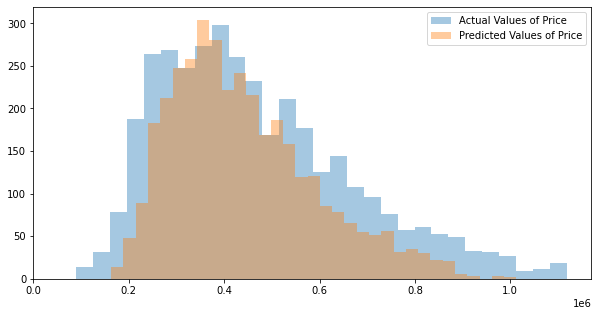

In [184]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(pred_knn, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [185]:
models['Models'].append('KNN')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

## Support Vector Regression

Support vector regression is a form of regression that allows us to define the acceptable error in our model and then finds the line that best fits that data, according to our specifications. This is really useful with something like housing price predictions, where we are ok with our prediction being within a certain dollar amount. SVR will attempt to get all of the predictions within that dollar amount when possible. This will result in a fit line that is different than a linear regression would have produced, but should result in a lower absolute error, which is a reasonable scoring metric for housing price predictions.

We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our SVM! Here are the parameters we are trying out:

* kernel: linear is parametric, and rbf is non-parametric. One of these should perform better. Our data is not totally normal, so it might be rbf.
* epsilon: This value is how much error we're ok with accepting without assigning a penalty to the model
* C: The error that we will accept from a point outside our epsilon

Our C and epsilon need to be in scale with our output variable, which is our log-transformed price.


In [186]:
param_grid = [
    {'kernel' : ['linear', 'rbf'], 'C' : [1, 3, 5], 'epsilon' : [.1, .5, 1]} ]

Running this GridSearch took about 90 minutes, so we commented it out after running the first time

In [187]:
#svr = SVR()
#grid = GridSearchCV(svr, param_grid, scoring='neg_mean_absolute_error', cv=5)
#grid.fit(X_train_val, y_train_val)

The following cannot produce results with the above commented out, but results have been replicated in the markdown following.

In [188]:
'''
print("Best parameters set found on train set: \n")
print(grid.best_params_)
print("\nGrid scores on train set:\n")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
y_true, y_pred = test_actual, np.exp(grid.predict(X_test))
'''

'\nprint("Best parameters set found on train set: \n")\nprint(grid.best_params_)\nprint("\nGrid scores on train set:\n")\nmeans = grid.cv_results_[\'mean_test_score\']\nstds = grid.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, grid.cv_results_[\'params\']):\n    print("%0.3f (+/-%0.03f) for %r"\n              % (mean, std * 2, params))\ny_true, y_pred = test_actual, np.exp(grid.predict(X_test))\n'

Best parameters set found on train set: 

{'C': 3, 'epsilon': 0.1, 'kernel': 'linear'}

Grid scores on train set:

    *-0.120 (+/-0.003) for {'C': 0.1, 'epsilon': 0.1, 'kernel': 'linear'}
    *-0.130 (+/-0.004) for {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
    *-0.156 (+/-0.006) for {'C': 0.1, 'epsilon': 0.5, 'kernel': 'linear'}
    *-0.217 (+/-0.003) for {'C': 0.1, 'epsilon': 0.5, 'kernel': 'rbf'}
    *-0.288 (+/-0.016) for {'C': 0.1, 'epsilon': 1, 'kernel': 'linear'}
    *-0.334 (+/-0.008) for {'C': 0.1, 'epsilon': 1, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 0.1, 'epsilon': 3, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 0.1, 'epsilon': 3, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 0.1, 'epsilon': 5, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 0.1, 'epsilon': 5, 'kernel': 'rbf'}
    *-0.119 (+/-0.003) for {'C': 0.5, 'epsilon': 0.1, 'kernel': 'linear'}
    *-0.121 (+/-0.005) for {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}
    *-0.160 (+/-0.009) for {'C': 0.5, 'epsilon': 0.5, 'kernel': 'linear'}
    *-0.195 (+/-0.004) for {'C': 0.5, 'epsilon': 0.5, 'kernel': 'rbf'}
    *-0.288 (+/-0.016) for {'C': 0.5, 'epsilon': 1, 'kernel': 'linear'}
    *-0.333 (+/-0.008) for {'C': 0.5, 'epsilon': 1, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 0.5, 'epsilon': 3, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 0.5, 'epsilon': 3, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 0.5, 'epsilon': 5, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 0.5, 'epsilon': 5, 'kernel': 'rbf'}
    *-0.119 (+/-0.003) for {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}
    *-0.122 (+/-0.005) for {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
    *-0.163 (+/-0.008) for {'C': 1, 'epsilon': 0.5, 'kernel': 'linear'}
    *-0.193 (+/-0.004) for {'C': 1, 'epsilon': 0.5, 'kernel': 'rbf'}
    *-0.288 (+/-0.016) for {'C': 1, 'epsilon': 1, 'kernel': 'linear'}
    *-0.333 (+/-0.008) for {'C': 1, 'epsilon': 1, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 1, 'epsilon': 3, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 1, 'epsilon': 3, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 1, 'epsilon': 5, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 1, 'epsilon': 5, 'kernel': 'rbf'}
    *-0.119 (+/-0.003) for {'C': 3, 'epsilon': 0.1, 'kernel': 'linear'}
    *-0.126 (+/-0.004) for {'C': 3, 'epsilon': 0.1, 'kernel': 'rbf'}
    *-0.165 (+/-0.006) for {'C': 3, 'epsilon': 0.5, 'kernel': 'linear'}
    *-0.193 (+/-0.004) for {'C': 3, 'epsilon': 0.5, 'kernel': 'rbf'}
    *-0.288 (+/-0.016) for {'C': 3, 'epsilon': 1, 'kernel': 'linear'}
    *-0.333 (+/-0.008) for {'C': 3, 'epsilon': 1, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 3, 'epsilon': 3, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 3, 'epsilon': 3, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 3, 'epsilon': 5, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 3, 'epsilon': 5, 'kernel': 'rbf'}
    *-0.119 (+/-0.003) for {'C': 5, 'epsilon': 0.1, 'kernel': 'linear'}
    *-0.128 (+/-0.004) for {'C': 5, 'epsilon': 0.1, 'kernel': 'rbf'}
    *-0.166 (+/-0.005) for {'C': 5, 'epsilon': 0.5, 'kernel': 'linear'}
    *-0.193 (+/-0.004) for {'C': 5, 'epsilon': 0.5, 'kernel': 'rbf'}
    *-0.288 (+/-0.016) for {'C': 5, 'epsilon': 1, 'kernel': 'linear'}
    *-0.333 (+/-0.008) for {'C': 5, 'epsilon': 1, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 5, 'epsilon': 3, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 5, 'epsilon': 3, 'kernel': 'rbf'}
    *-0.450 (+/-0.011) for {'C': 5, 'epsilon': 5, 'kernel': 'linear'}
    *-0.450 (+/-0.011) for {'C': 5, 'epsilon': 5, 'kernel': 'rbf'}

In [189]:
params = {'kernel' : 'linear', 'C' : 3, 'epsilon' : .1}
svr = SVR(**params)

svr.fit(X_train_val, y_train_val)

#cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
# commented out because it takes forever to run and doing a simple cv-5

cv_5 = cross_val_score(svr, X_train_val, y_train_val, cv=5)
r2 = cv_5.mean()
r2

0.8466652930442619

In [190]:
predictions_SVR = svr.predict(X_test)
predictions_SVR_unscaled = np.exp(predictions_SVR)

residuals = test_actual - predictions_SVR_unscaled

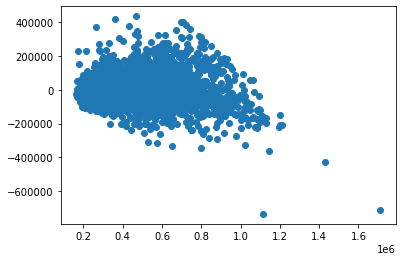

In [191]:
plt.scatter(predictions_SVR_unscaled, residuals)

In [192]:
mae = round(mean_absolute_error(test_actual, predictions_SVR_unscaled), 2)
mae

58577.72

In [193]:
rmse = round(np.sqrt(mean_squared_error(test_actual, predictions_SVR_unscaled)), 2)
rmse

84465.4

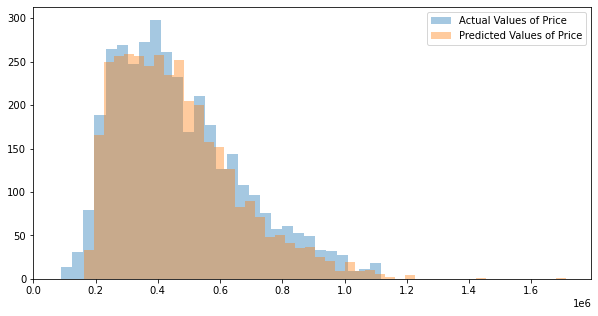

In [194]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(predictions_SVR_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [195]:
models['Models'].append('SVR')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

## Redo Data for Decision-Based Regressors

### Redo Categoricals

In [196]:
df_categoricals

price  yr_built  month_sold  zipcode  waterfront  renovated  \
0      222876.0      1955          10    98178         0.0        0.0   
1      539691.0      1951          12    98125         0.0        1.0   
2      180339.0      1933           2    98028         0.0        0.0   
3      605898.0      1965          12    98136         0.0        0.0   
4      510962.0      1987           2    98074         0.0        0.0   
...         ...       ...         ...      ...         ...        ...   
18057  362715.0      2009           5    98103         0.0        0.0   
18058  400754.0      2014           2    98146         0.0        0.0   
18059  404881.0      2009           6    98144         0.0        0.0   
18060  401006.0      2004           1    98027         0.0        0.0   
18061  326430.0      2008          10    98144         0.0        0.0   

       basement comparative_sf        year_block  
0           0.0              2  (1953.0, 1956.0]  
1           1.0              3  (1949.0, 1953.0]  
2           0.0              1  (1928.0, 1940.0]  
3           1.0              3  (1962.0, 1966.0]  
4           0.0              2  (1986.0, 1989.0]  
...         ...            ...               ...  
18057       0.0              2  (2008.0, 2012.0]  
18058       0.0              3  (2012.0, 2015.0]  
18059       0.0              2  (2008.0, 2012.0]  
18060       0.0              2  (2002.0, 2004.0]  
18061       0.0              2  (2006.0, 2008.0]  

[18062 rows x 9 columns]

In [197]:
# we're going back and getting our categoricals data frame to re-configure these categorials for gradient boosting
df_boost = df_categoricals

In [198]:
df_boost

price  yr_built  month_sold  zipcode  waterfront  renovated  \
0      222876.0      1955          10    98178         0.0        0.0   
1      539691.0      1951          12    98125         0.0        1.0   
2      180339.0      1933           2    98028         0.0        0.0   
3      605898.0      1965          12    98136         0.0        0.0   
4      510962.0      1987           2    98074         0.0        0.0   
...         ...       ...         ...      ...         ...        ...   
18057  362715.0      2009           5    98103         0.0        0.0   
18058  400754.0      2014           2    98146         0.0        0.0   
18059  404881.0      2009           6    98144         0.0        0.0   
18060  401006.0      2004           1    98027         0.0        0.0   
18061  326430.0      2008          10    98144         0.0        0.0   

       basement comparative_sf        year_block  
0           0.0              2  (1953.0, 1956.0]  
1           1.0              3  (1949.0, 1953.0]  
2           0.0              1  (1928.0, 1940.0]  
3           1.0              3  (1962.0, 1966.0]  
4           0.0              2  (1986.0, 1989.0]  
...         ...            ...               ...  
18057       0.0              2  (2008.0, 2012.0]  
18058       0.0              3  (2012.0, 2015.0]  
18059       0.0              2  (2008.0, 2012.0]  
18060       0.0              2  (2002.0, 2004.0]  
18061       0.0              2  (2006.0, 2008.0]  

[18062 rows x 9 columns]

In [199]:
# reducing the granularity of our age group. We want whole numbers here so round to nearest whole number, always up.
df_boost['age_group'] = np.ceil((2015 - df_boost['yr_built'])/4)

In [200]:
# reducing the granularity of our latitude category by rounding to the nearest .1
#df_boost['lat_round'] = round(df_boost['lat'], 1)

In [201]:
df_boost

price  yr_built  month_sold  zipcode  waterfront  renovated  \
0      222876.0      1955          10    98178         0.0        0.0   
1      539691.0      1951          12    98125         0.0        1.0   
2      180339.0      1933           2    98028         0.0        0.0   
3      605898.0      1965          12    98136         0.0        0.0   
4      510962.0      1987           2    98074         0.0        0.0   
...         ...       ...         ...      ...         ...        ...   
18057  362715.0      2009           5    98103         0.0        0.0   
18058  400754.0      2014           2    98146         0.0        0.0   
18059  404881.0      2009           6    98144         0.0        0.0   
18060  401006.0      2004           1    98027         0.0        0.0   
18061  326430.0      2008          10    98144         0.0        0.0   

       basement comparative_sf        year_block  age_group  
0           0.0              2  (1953.0, 1956.0]       15.0  
1           1.0              3  (1949.0, 1953.0]       16.0  
2           0.0              1  (1928.0, 1940.0]       21.0  
3           1.0              3  (1962.0, 1966.0]       13.0  
4           0.0              2  (1986.0, 1989.0]        7.0  
...         ...            ...               ...        ...  
18057       0.0              2  (2008.0, 2012.0]        2.0  
18058       0.0              3  (2012.0, 2015.0]        1.0  
18059       0.0              2  (2008.0, 2012.0]        2.0  
18060       0.0              2  (2002.0, 2004.0]        3.0  
18061       0.0              2  (2006.0, 2008.0]        2.0  

[18062 rows x 10 columns]

In [202]:
categorical = ['zipcode', 'waterfront', 'renovated', 'basement', 'comparative_sf', 'month_sold', 'age_group'] #, 'lat_round'

# making our boost-ready categorical data frame using the columns we need
df_boost_processed = df_boost[categorical]

# tagging all of these things as categoricals so they are considered properly instead of ordinal/numerical
for item in categorical:
    df_boost_processed[item] = df_boost_processed[item].astype('category')


In [203]:
df_boost_processed

zipcode waterfront renovated basement comparative_sf month_sold  \
0       98178        0.0       0.0      0.0              2         10   
1       98125        0.0       1.0      1.0              3         12   
2       98028        0.0       0.0      0.0              1          2   
3       98136        0.0       0.0      1.0              3         12   
4       98074        0.0       0.0      0.0              2          2   
...       ...        ...       ...      ...            ...        ...   
18057   98103        0.0       0.0      0.0              2          5   
18058   98146        0.0       0.0      0.0              3          2   
18059   98144        0.0       0.0      0.0              2          6   
18060   98027        0.0       0.0      0.0              2          1   
18061   98144        0.0       0.0      0.0              2         10   

      age_group  
0          15.0  
1          16.0  
2          21.0  
3          13.0  
4           7.0  
...         ...  
18057       2.0  
18058       1.0  
18059       2.0  
18060       3.0  
18061       2.0  

[18062 rows x 7 columns]

### Remake Holdout

In [204]:
# dividing our re-processed categoricals in the same manner as the original set

x_train_boost_preprocessing, x_test_boost_preprocessing = train_test_split(df_boost_processed, test_size=0.2, random_state=randomstate)

In [205]:
x_train_boost_preprocessing.reset_index(inplace=True)
x_train_boost_preprocessing.drop('index', axis=1, inplace=True)

x_test_boost_preprocessing.reset_index(inplace=True)
x_test_boost_preprocessing.drop('index', axis=1, inplace=True)

In [206]:
# making our final boost_processed ready data frame by concatenating our target price, continuous variables, and boost-ready
# categorical variables

X_train_val = pd.concat([transformed_scaled_continuous, x_train_boost_preprocessing], axis=1)
X_test = pd.concat([holdout_scaled, x_test_boost_preprocessing], axis=1)


In [207]:
# last check that our data types are correct - all should be numerical or categories, and even the categories should be in
# numerical format
X_train_val.dtypes

sqft_living        float64
sqft_lot           float64
floors             float64
bedrooms           float64
bathrooms          float64
condition          float64
grade              float64
zipcode           category
waterfront        category
renovated         category
basement          category
comparative_sf    category
month_sold        category
age_group         category
dtype: object

## Gradient Boosting Regressor

This model is entirely different than linear regression. Gradient boosting uses decision trees to learn about outcomes, with trees being added to the model one at a time and existing trees in the model are not changed. Each successive tree tries to improve upon the predictions of the first one, with the weights of the various decision points being updated each time. Gradient boosting uses the residuals to improve its next tree prediction. Overall much more opaque of a process than linear regression.

To work with a boosted regressor, we're going to roll back some of our one-hot encoding and bring those elements back to categories. Gradient boosting does not benefit from one-hot encoding. It DOES require our categoricals to be numerical, so we will ensure that they are not strings. We also don't need to standardize our continuous features with this model. Let's check out what we need to roll back.

We're going to roll back zipcode into a single column categorical. We'll use age blocks still, but in-column. We're still going to use month as a categorical.

### Redo Categoricals

In [224]:
df_categoricals

price  yr_built  month_sold  zipcode  waterfront  renovated  \
0      222876.0      1955          10    98178         0.0        0.0   
1      539691.0      1951          12    98125         0.0        1.0   
2      180339.0      1933           2    98028         0.0        0.0   
3      605898.0      1965          12    98136         0.0        0.0   
4      510962.0      1987           2    98074         0.0        0.0   
...         ...       ...         ...      ...         ...        ...   
21592  362715.0      2009           5    98103         0.0        0.0   
21593  400754.0      2014           2    98146         0.0        0.0   
21594  404881.0      2009           6    98144         0.0        0.0   
21595  401006.0      2004           1    98027         0.0        0.0   
21596  326430.0      2008          10    98144         0.0        0.0   

       basement comparative_sf        year_block  age_group  
0           0.0              2  (1953.0, 1956.0]       15.0  
1           1.0              3  (1949.0, 1953.0]       16.0  
2           0.0              1  (1928.0, 1940.0]       21.0  
3           1.0              3  (1962.0, 1966.0]       13.0  
4           0.0              2  (1986.0, 1989.0]        7.0  
...         ...            ...               ...        ...  
21592       0.0              2  (2008.0, 2012.0]        2.0  
21593       0.0              3  (2012.0, 2015.0]        1.0  
21594       0.0              2  (2008.0, 2012.0]        2.0  
21595       0.0              2  (2002.0, 2004.0]        3.0  
21596       0.0              2  (2006.0, 2008.0]        2.0  

[18062 rows x 10 columns]

In [225]:
# we're going back and getting our categoricals data frame to re-configure these categorials for gradient boosting
df_boost = df_categoricals

In [226]:
df_boost

price  yr_built  month_sold  zipcode  waterfront  renovated  \
0      222876.0      1955          10    98178         0.0        0.0   
1      539691.0      1951          12    98125         0.0        1.0   
2      180339.0      1933           2    98028         0.0        0.0   
3      605898.0      1965          12    98136         0.0        0.0   
4      510962.0      1987           2    98074         0.0        0.0   
...         ...       ...         ...      ...         ...        ...   
21592  362715.0      2009           5    98103         0.0        0.0   
21593  400754.0      2014           2    98146         0.0        0.0   
21594  404881.0      2009           6    98144         0.0        0.0   
21595  401006.0      2004           1    98027         0.0        0.0   
21596  326430.0      2008          10    98144         0.0        0.0   

       basement comparative_sf        year_block  age_group  
0           0.0              2  (1953.0, 1956.0]       15.0  
1           1.0              3  (1949.0, 1953.0]       16.0  
2           0.0              1  (1928.0, 1940.0]       21.0  
3           1.0              3  (1962.0, 1966.0]       13.0  
4           0.0              2  (1986.0, 1989.0]        7.0  
...         ...            ...               ...        ...  
21592       0.0              2  (2008.0, 2012.0]        2.0  
21593       0.0              3  (2012.0, 2015.0]        1.0  
21594       0.0              2  (2008.0, 2012.0]        2.0  
21595       0.0              2  (2002.0, 2004.0]        3.0  
21596       0.0              2  (2006.0, 2008.0]        2.0  

[18062 rows x 10 columns]

In [227]:
# reducing the granularity of our age group. We want whole numbers here so round to nearest whole number, always up.
df_boost['age_group'] = np.ceil((2015 - df_boost['yr_built'])/4)

In [228]:
# reducing the granularity of our latitude category by rounding to the nearest .1
#df_boost['lat_round'] = round(df_boost['lat'], 1)

In [229]:
df_boost

price  yr_built  month_sold  zipcode  waterfront  renovated  \
0      222876.0      1955          10    98178         0.0        0.0   
1      539691.0      1951          12    98125         0.0        1.0   
2      180339.0      1933           2    98028         0.0        0.0   
3      605898.0      1965          12    98136         0.0        0.0   
4      510962.0      1987           2    98074         0.0        0.0   
...         ...       ...         ...      ...         ...        ...   
21592  362715.0      2009           5    98103         0.0        0.0   
21593  400754.0      2014           2    98146         0.0        0.0   
21594  404881.0      2009           6    98144         0.0        0.0   
21595  401006.0      2004           1    98027         0.0        0.0   
21596  326430.0      2008          10    98144         0.0        0.0   

       basement comparative_sf        year_block  age_group  
0           0.0              2  (1953.0, 1956.0]       15.0  
1           1.0              3  (1949.0, 1953.0]       16.0  
2           0.0              1  (1928.0, 1940.0]       21.0  
3           1.0              3  (1962.0, 1966.0]       13.0  
4           0.0              2  (1986.0, 1989.0]        7.0  
...         ...            ...               ...        ...  
21592       0.0              2  (2008.0, 2012.0]        2.0  
21593       0.0              3  (2012.0, 2015.0]        1.0  
21594       0.0              2  (2008.0, 2012.0]        2.0  
21595       0.0              2  (2002.0, 2004.0]        3.0  
21596       0.0              2  (2006.0, 2008.0]        2.0  

[18062 rows x 10 columns]

In [230]:
categorical = ['zipcode', 'waterfront', 'renovated', 'basement', 'comparative_sf', 'month_sold', 'age_group'] #, 'lat_round'

# making our boost-ready categorical data frame using the columns we need
df_boost_processed = df_boost[categorical]

# tagging all of these things as categoricals so they are considered properly instead of ordinal/numerical
for item in categorical:
    df_boost_processed[item] = df_boost_processed[item].astype('category')


In [231]:
df_boost_processed

zipcode waterfront renovated basement comparative_sf month_sold  \
0       98178        0.0       0.0      0.0              2         10   
1       98125        0.0       1.0      1.0              3         12   
2       98028        0.0       0.0      0.0              1          2   
3       98136        0.0       0.0      1.0              3         12   
4       98074        0.0       0.0      0.0              2          2   
...       ...        ...       ...      ...            ...        ...   
21592   98103        0.0       0.0      0.0              2          5   
21593   98146        0.0       0.0      0.0              3          2   
21594   98144        0.0       0.0      0.0              2          6   
21595   98027        0.0       0.0      0.0              2          1   
21596   98144        0.0       0.0      0.0              2         10   

      age_group  
0          15.0  
1          16.0  
2          21.0  
3          13.0  
4           7.0  
...         ...  
21592       2.0  
21593       1.0  
21594       2.0  
21595       3.0  
21596       2.0  

[18062 rows x 7 columns]

### Remake Holdout

In [232]:
# dividing our re-processed categoricals in the same manner as the original set

x_train_boost_preprocessing, x_test_boost_preprocessing = train_test_split(df_boost_processed, test_size=0.2, random_state=randomstate)

In [233]:
x_train_boost_preprocessing.reset_index(inplace=True)
x_train_boost_preprocessing.drop('index', axis=1, inplace=True)

x_test_boost_preprocessing.reset_index(inplace=True)
x_test_boost_preprocessing.drop('index', axis=1, inplace=True)

In [234]:
# making our final boost_processed ready data frame by concatenating our target price, continuous variables, and boost-ready
# categorical variables

X_train_val = pd.concat([y_train_val, transformed_scaled_continuous, x_train_boost_preprocessing], axis=1)
X_test = pd.concat([y_test, holdout_scaled, x_test_boost_preprocessing], axis=1)


In [235]:
# last check that our data types are correct - all should be numerical or categories, and even the categories should be in
# numerical format
X_train_val.dtypes

price              float64
sqft_living        float64
sqft_lot           float64
floors             float64
bedrooms           float64
bathrooms          float64
condition          float64
grade              float64
zipcode           category
waterfront        category
renovated         category
basement          category
comparative_sf    category
month_sold        category
age_group         category
dtype: object

Gradient Boosting performs best with optimal parameter tuning. We're going to use sklearn's GridSearchCV to find the optimal hyperparameters to use with our gradient booster! Here are the parameters we are trying out:

* Loss: Loss function to be optimized. We are using lad for all of these, which is least absolute deviation
* n_estimators: Number of boosts to perform. Gradient boosting is, according to sklearn, pretty robust to over-fitting so more is usually better
* max_depth: This determines how many tree nodes the estimator looks at before making a prediction. We don't know what is best here, but I read with high-cardinality variables that 4-8 is usually good, so we are trying everything from 3-8 to see what works the best
* learning_rate: Tuning this setting alters how much the model corrects after it runs a boost. .1 is a common rate and we will test a lower and higher rate as well.

In [208]:
param_grid = [
    {'loss': ['lad'], 'n_estimators' : [250, 500],'max_depth' : [3, 4, 5, 6, 7, 8], 'learning_rate': [.05, .1, .3]}] # 

Running this GridSearch took about 90 minutes, so we commented it out

In [209]:
#model = GradientBoostingRegressor()
#grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
#grid.fit(X_train_val, y_train_val)

In [ ]:
# creating our train/validation sets and our test sets

x_train_cont, x_test_cont, y_train_val, y_test = train_test_split(x_continuous, y, test_size=0.2, random_state=randomstate)
x_train_cat, x_test_cat, y_train_val, y_test = train_test_split(x_categorical, y, test_size=0.2, random_state=randomstate)

The following cannot produce results with the above commented out, but results have been replicated in the markdown following.

In [210]:
#print("Best parameters set found on train set: \n")
#print(grid.best_params_)
#print("\nGrid scores on train set:\n")
#means = grid.cv_results_['mean_test_score']
#stds = grid.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#              % (mean, std * 2, params))
#y_true, y_pred = test_actual, np.exp(grid.predict(X_test))

Best parameters set found on train set: 

{'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 500}

Grid scores on train set:

    *-66840.120 (+/-1619.859) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 250}
    *-62664.947 (+/-2133.751) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 500}
    *-62374.456 (+/-1229.272) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 250}
    *-59640.226 (+/-1162.829) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 500}
    *-59865.205 (+/-970.467) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 250}
    *-57976.535 (+/-700.847) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 500}
    *-58247.526 (+/-1246.676) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 250}
    *-57503.606 (+/-1123.625) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 500}
    *-57789.270 (+/-2015.145) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 250}
    *-57059.973 (+/-1836.378) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 500}
    *-57376.748 (+/-1550.273) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 250}
    *-56932.683 (+/-1813.476) for {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 500}
    *-62553.238 (+/-1591.178) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 250}
    *-59918.017 (+/-1060.959) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 500}
    *-59436.297 (+/-885.120) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 250}
    *-58370.928 (+/-1248.473) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 500}
    *-58107.360 (+/-1576.668) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 250}
    *-57537.077 (+/-1074.531) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 500}
    *-57761.874 (+/-1123.443) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 250}
    *-57482.741 (+/-1816.020) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 500}
    *-57442.457 (+/-1966.396) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 250}
    *-57167.007 (+/-1483.537) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 500}
    *-57684.695 (+/-1458.799) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 250}
    *-57257.558 (+/-1229.135) for {'learning_rate': 0.1, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 500}
    *-59406.260 (+/-200.394) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 250}
    *-59317.330 (+/-1132.891) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 3, 'n_estimators': 500}
    *-58407.874 (+/-1212.328) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 250}
    *-58532.393 (+/-1337.937) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 4, 'n_estimators': 500}
    *-58209.084 (+/-478.089) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 250}
    *-58261.074 (+/-576.375) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 5, 'n_estimators': 500}
    *-57762.180 (+/-1812.929) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 250}
    *-57889.671 (+/-1840.939) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 6, 'n_estimators': 500}
    *-58400.892 (+/-2428.807) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 250}
    *-58574.829 (+/-1144.900) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 7, 'n_estimators': 500}
    *-59126.455 (+/-2238.013) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 250}
    *-58816.255 (+/-1367.941) for {'learning_rate': 0.3, 'loss': 'lad', 'max_depth': 8, 'n_estimators': 500}

Having found the optimal n_estimators, max_depth and learning_rate with our GridSearchCV, we run our regressor on the train_val set with the chosen options.

In [211]:
params = {'loss': 'lad', 'n_estimators': 500, 'max_depth': 8, 'learning_rate': .05}  
model = GradientBoostingRegressor(**params)

model.fit(X_train_val, y_train_val)

cv_5 = cross_val_score(model, X_train_val, y_train_val, cv=5)
r2 = cv_5.mean()
r2

0.833974297442942

In [212]:
# apply our model to our test set and get predicted values
gradient_boosted_preds = model.predict(X_test)

# reverse log transform our predicted values
gradient_predictions_unscaled = np.exp(gradient_boosted_preds)
gradient_predictions_unscaled = gradient_predictions_unscaled.flatten().astype(int)

residuals = test_actual - gradient_predictions_unscaled


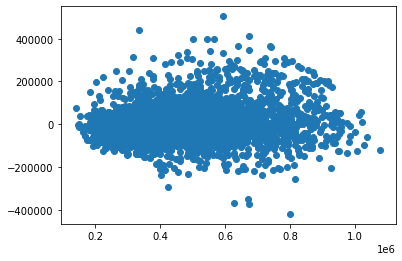

In [213]:
plt.scatter(gradient_predictions_unscaled, residuals)

In [214]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, gradient_predictions_unscaled), 2)
mae

57192.68

In [215]:
rmse = round(np.sqrt(mean_squared_error(test_actual, gradient_predictions_unscaled)), 2)
rmse

13811.24

In [209]:
x_test_boost_preprocessing

zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 1              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609              0              0              1              0   
3610              0              0              0              0   
3611              0              0              0              0   
3612              0              0              0              0   

      zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0                 0              0              0              0   
1                 0              0              1              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609              0              0              0              0   
3610              0              0              0              0   
3611              0              0              0              0   
3612              0              0              0              0   

      zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609              0              0              0              0   
3610              0              0              0              0   
3611              0              0              0              0   
3612              0              0              0              0   

      zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609              0              0              0              0   
3610              0              0              0              0   
3611              0              0              0              0   
3612              0              0              0              0   

      zipcode_98029  zipcode_98030  zipcode_98031  zipcode_98032  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609              0              0              0              0   
3610              0              0              0              0   
3611              0              0              0         

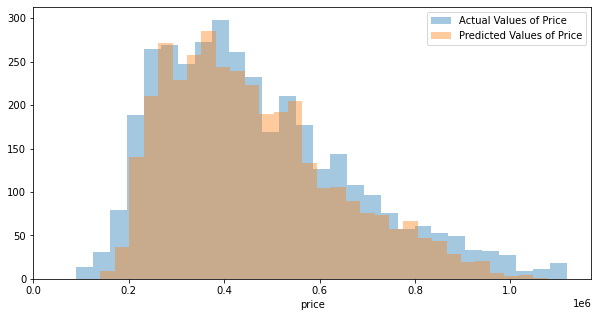

In [216]:
plt.figure(figsize=(10,5))
sns.distplot(test_actual, hist=True, kde=False)
sns.distplot(gradient_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [212]:
X_test

price  sqft_living  sqft_lot    floors  bedrooms  bathrooms  \
0     13.104672     0.294428  2.539509 -0.873997  0.783158   0.320998   
1     13.245837     0.180980  0.033496 -0.873997  0.783158  -0.394151   
2     13.628154     0.549686 -0.263828  0.043497  0.783158  -1.466875   
3     12.181385    -1.180396 -0.317629 -0.873997 -0.355831  -0.394151   
4     13.239456    -0.528070 -1.542036  0.960990 -0.355831   1.751296   
...         ...          ...       ...       ...       ...        ...   
3608  12.822514    -0.769147  0.989462 -0.873997 -0.355831  -0.751726   
3609  13.488263    -0.754966  0.630975 -0.873997 -1.494819  -1.466875   
3610  12.998920    -0.598975  0.092960  0.043497  0.783158  -1.466875   
3611  12.595818    -1.194577  0.180175 -0.873997 -1.494819  -1.466875   
3612  13.648348    -0.428803 -1.329096  0.960990 -0.355831  -0.394151   

      condition     grade  zipcode_98002  zipcode_98003  zipcode_98004  \
0     -0.630748  0.549761              0              0              0   
1     -0.630748  0.549761              0              0              0   
2      0.903800 -0.475736              0              0              0   
3      0.903800 -0.475736              1              0              0   
4     -0.630748  0.549761              0              0              0   
...         ...       ...            ...            ...            ...   
3608   0.903800 -0.475736              0              0              0   
3609  -0.630748 -1.501233              0              0              1   
3610  -0.630748 -0.475736              0              0              0   
3611  -0.630748 -0.475736              0              0              0   
3612  -0.630748 -0.475736              0              0              0   

      zipcode_98005  zipcode_98006  zipcode_98007  zipcode_98008  \
0                 0              0              0              0   
1                 0              0              0              1   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609              0              0              0              0   
3610              0              0              0              0   
3611              0              0              0              0   
3612              0              0              0              0   

      zipcode_98010  zipcode_98011  zipcode_98014  zipcode_98019  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609              0              0              0              0   
3610              0              0              0              0   
3611              0              0              0              0   
3612              0              0              0              0   

      zipcode_98022  zipcode_98023  zipcode_98024  zipcode_98027  \
0                 0              0              0              0   
1                 0              0              0              0   
2                 0              0              0              0   
3                 0              0              0              0   
4                 0              0              0              0   
...             ...            ...            ...            ...   
3608              0              0              0              0   
3609              0              0              0              0  

In [ ]:
# our gradient boosting ready data frame

boost_processed

In [218]:
X_train_val

price  sqft_living  sqft_lot    floors  bedrooms  bathrooms  \
0      13.171782    -0.244450 -1.743650  3.713471 -0.355831   1.393722   
1      13.323724     1.046022  0.330819 -0.873997  0.783158   1.036147   
2      12.888495    -0.315355 -0.893871  0.960990 -0.355831   0.678572   
3      12.612001    -0.754966 -0.631943  0.960990 -0.355831   0.320998   
4      12.465104     0.507143  1.491797 -0.873997  1.922147  -0.036577   
...          ...          ...       ...       ...       ...        ...   
14444  12.664718     0.847488  0.299388 -0.873997 -0.355831  -0.394151   
14445  11.963338    -0.981862  0.713093 -0.873997 -1.494819  -0.394151   
14446  12.684212    -0.145183 -0.773526  0.960990  0.783158   0.320998   
14447  13.597258     2.478303  3.112353  0.960990  0.783158   2.824020   
14448  12.824030     0.351152  0.071440  0.960990 -0.355831   0.678572   

       condition     grade  test_interaction zipcode waterfront renovated  \
0      -0.630748  0.549761         -0.346761   98107        0.0       0.0   
1      -0.630748  0.549761         -0.346761   98144        0.0       0.0   
2      -0.630748 -0.475736          0.300070   98053        0.0       0.0   
3      -0.630748 -0.475736          0.300070   98019        0.0       0.0   
4       0.903800  0.549761          0.496874   98032        0.0       0.0   
...          ...       ...               ...     ...        ...       ...   
14444   0.903800 -0.475736         -0.429970   98056        0.0       0.0   
14445  -0.630748 -0.475736          0.300070   98038        0.0       0.0   
14446   0.903800  0.549761          0.496874   98031        0.0       0.0   
14447  -0.630748  1.575259         -0.993592   98006        0.0       0.0   
14448  -0.630748  0.549761         -0.346761   98074        0.0       0.0   

      basement comparative_sf month_sold age_group  
0          0.0              3          4       3.0  
1          1.0              2          1      17.0  
2          0.0              2         10       2.0  
3          0.0              2          4       7.0  
4          1.0              3         10      14.0  
...        ...            ...        ...       ...  
14444      1.0              3         10      15.0  
14445      0.0              1          2       8.0  
14446      0.0              2          9       3.0  
14447      1.0              2          9       1.0  
14448      0.0              2          5       7.0  

[14449 rows x 16 columns]

In [217]:
models['Models'].append('Gradient Boosting')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [ ]:
# prepare boost regression data set, same as preparing for other regression styles

X = boost_processed.drop('price', axis=1)
y = boost_processed['price']

## K-Nearest Neighbors Model

K-Nearest Neighbors is more commonly used for classification. Its basic premise is to determine "what is this like" in making a prediction, by looking at other things that are close in value/type. We can pick how many neighbors it assesses to make a classification. As we will see, it doesn't work very well for this type of application (or, I've not tuned the hyperparameters properly and/or don't know how to use it well).

In [207]:
X_train_val

price  sqft_living  sqft_lot    floors  bedrooms  bathrooms  \
0      222876.0    -0.244450 -1.743650  3.713471 -0.355831   1.393722   
1      539691.0     1.046022  0.330819 -0.873997  0.783158   1.036147   
2      180339.0    -0.315355 -0.893871  0.960990 -0.355831   0.678572   
3      605898.0    -0.754966 -0.631943  0.960990 -0.355831   0.320998   
4      510962.0     0.507143  1.491797 -0.873997  1.922147  -0.036577   
...         ...          ...       ...       ...       ...        ...   
21592  362715.0          NaN       NaN       NaN       NaN        NaN   
21593  400754.0          NaN       NaN       NaN       NaN        NaN   
21594  404881.0          NaN       NaN       NaN       NaN        NaN   
21595  401006.0          NaN       NaN       NaN       NaN        NaN   
21596  326430.0          NaN       NaN       NaN       NaN        NaN   

       condition     grade  test_interaction  zipcode_98002  zipcode_98003  \
0      -0.630748  0.549761         -0.346761            0.0            0.0   
1      -0.630748  0.549761         -0.346761            0.0            0.0   
2      -0.630748 -0.475736          0.300070            0.0            0.0   
3      -0.630748 -0.475736          0.300070            0.0            0.0   
4       0.903800  0.549761          0.496874            0.0            0.0   
...          ...       ...               ...            ...            ...   
21592        NaN       NaN               NaN            NaN            NaN   
21593        NaN       NaN               NaN            NaN            NaN   
21594        NaN       NaN               NaN            NaN            NaN   
21595        NaN       NaN               NaN            NaN            NaN   
21596        NaN       NaN               NaN            NaN            NaN   

       zipcode_98004  zipcode_98005  zipcode_98006  zipcode_98007  \
0                0.0            0.0            0.0            0.0   
1                0.0            0.0            0.0            0.0   
2                0.0            0.0            0.0            0.0   
3                0.0            0.0            0.0            0.0   
4                0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
21592            NaN            NaN            NaN            NaN   
21593            NaN            NaN            NaN            NaN   
21594            NaN            NaN            NaN            NaN   
21595            NaN            NaN            NaN            NaN   
21596            NaN            NaN            NaN            NaN   

       zipcode_98008  zipcode_98010  zipcode_98011  zipcode_98014  \
0                0.0            0.0            0.0            0.0   
1                0.0            0.0            0.0            0.0   
2                0.0            0.0            0.0            0.0   
3                0.0            0.0            0.0            0.0   
4                0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
21592            NaN            NaN            NaN            NaN   
21593            NaN            NaN            NaN            NaN   
21594            NaN            NaN            NaN            NaN   
21595            NaN            NaN            NaN            NaN   
21596            NaN            NaN            NaN            NaN   

       zipcode_98019  zipcode_98022  zipcode_98023  zipcode_98024  \
0                0.0            0.0            0.0            0.0   
1                0.0            0.0            0.0            0.0   
2                0.0            0.0            0.0            0.0   
3                1.0            0.0            0.0            0.0   
4                0.0            0.0            0.0            0.0   
...              ...            ...            ...            ...   
21592            NaN            NaN            NaN     

In [218]:
mae_val = [] #to store rmse values for different k

for K in range(20):
    K = K+1
    
    # set up the KNN regressor
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_val, y_train_val)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = mean_absolute_error(y_test,pred) #calculate rmse
    mae_val.append(error) #store mae values
    print('MAE value for k= ' , K , 'is:', error)

MAE value for k=  1 is: 0.1964671542891487
MAE value for k=  2 is: 0.17670005106932696
MAE value for k=  3 is: 0.16956420744701672
MAE value for k=  4 is: 0.16599409370639825
MAE value for k=  5 is: 0.16526941918362315
MAE value for k=  6 is: 0.165265584795782
MAE value for k=  7 is: 0.1663199823957905
MAE value for k=  8 is: 0.16705320835279505
MAE value for k=  9 is: 0.1679927534478731
MAE value for k=  10 is: 0.16956922458538984
MAE value for k=  11 is: 0.1706588081858083
MAE value for k=  12 is: 0.1715426626525698
MAE value for k=  13 is: 0.1729716912359588
MAE value for k=  14 is: 0.17393669833923686
MAE value for k=  15 is: 0.1746834609240813
MAE value for k=  16 is: 0.17523665211272318
MAE value for k=  17 is: 0.17574949810692478
MAE value for k=  18 is: 0.17713794393279575
MAE value for k=  19 is: 0.17786691080004785
MAE value for k=  20 is: 0.1785811645918795


In [ ]:
# creating our train/validation sets and our test sets, same as always

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)

# get our actual prices reverse log transformed
test_actual = y_test

In [219]:
index_min = np.argmin(mae_val) + 1

In [220]:
model = neighbors.KNeighborsRegressor(n_neighbors = index_min)
model.fit(X_train_val, y_train_val)  #fit the model
pred_knn = model.predict(X_test) #make prediction on test set
pred_knn = np.exp(pred_knn).flatten().astype(int)

In [221]:
scores = cross_val_score(model, X_train_val, y_train_val, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
r2 = np.mean(scores)
r2

0.7049890109941511

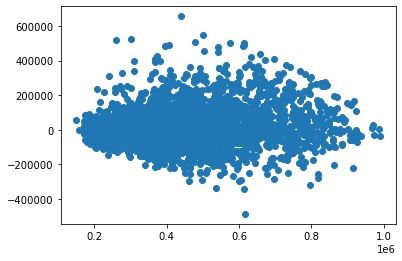

In [222]:
residuals = test_actual - pred_knn

plt.scatter(pred_knn, residuals)

In [223]:
mae = round(mean_absolute_error(test_actual, pred_knn), 2)
mae

74903.01

In [224]:
rmse = round(np.sqrt(mean_squared_error(test_actual, pred_knn)), 2)
rmse

13290.8

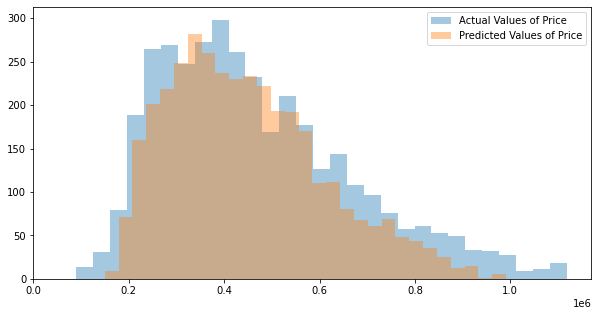

In [225]:
plt.figure(figsize=(10,5))
sns.distplot(np.exp(y_test), hist=True, kde=False)
sns.distplot(pred_knn, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [242]:
test_actual

0       491232
1       565709
2       829147
3       195122
4       562112
         ...  
3608    370464
3609    720905
3610    441936
3611    295320
3612    846062
Name: price, Length: 3613, dtype: int32

In [226]:
models['Models'].append('KNN')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

In [247]:
gradient_predictions_unscaled

array([492360, 565685, 830104, ..., 443913, 295845, 847408])

In [248]:
test_actual

0       491232
1       565709
2       829147
3       195122
4       562112
         ...  
3608    370464
3609    720905
3610    441936
3611    295320
3612    846062
Name: price, Length: 3613, dtype: int32

## Random Forest Regressor

In [227]:
param_grid = [
    {'bootstrap': [True, False], 'n_estimators' : [100, 250, 500],'max_depth' : [5, 10, 20, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10]}] # 

Grid Search for optimal parameters. Took several hours to run, so commented out after storing results.

In [228]:
'''
model = RandomForestRegressor()
grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)
grid.fit(X_train_val, y_train_val)

'''

"\nmodel = RandomForestRegressor()\ngrid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5)\ngrid.fit(X_train_val, y_train_val)\n\n"

In [229]:
'''
print("Best parameters set found on train set: \n")
print(grid.best_params_)
print("\nGrid scores on train set:\n")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
y_true, y_pred = test_actual, np.exp(grid.predict(X_test))
'''

'\nprint("Best parameters set found on train set: \n")\nprint(grid.best_params_)\nprint("\nGrid scores on train set:\n")\nmeans = grid.cv_results_[\'mean_test_score\']\nstds = grid.cv_results_[\'std_test_score\']\nfor mean, std, params in zip(means, stds, grid.cv_results_[\'params\']):\n    print("%0.3f (+/-%0.03f) for %r"\n              % (mean, std * 2, params))\ny_true, y_pred = test_actual, np.exp(grid.predict(X_test))\n'

Best parameters set found on train set: 

{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}

Grid scores on train set:

-111270.360 (+/-2943.016) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
-111289.131 (+/-2556.734) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}
-111224.722 (+/-2679.890) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
-111283.816 (+/-2866.479) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
-111349.179 (+/-2658.378) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 250}
-111175.618 (+/-2881.753) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
-111230.092 (+/-2986.651) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
......
-91654.274 (+/-2019.948) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
-91407.873 (+/-2143.925) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}
-91354.544 (+/-2304.075) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 500}

In [230]:
params = {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}  
model = RandomForestRegressor(**params)

model.fit(X_train_val, y_train_val)

cv_5 = cross_val_score(model, X_train_val, y_train_val, cv=5)
r2 = cv_5.mean()
r2

0.7915186156460633

In [231]:
# apply our model to our test set and get predicted values
forest_predictions = model.predict(X_test)

# reverse log transform our predicted values
forest_predictions_unscaled = np.exp(forest_predictions)
forest_predictions_unscaled = forest_predictions_unscaled.flatten().astype(int)

residuals = test_actual - forest_predictions_unscaled

In [232]:
plt.scatter(forest_predictions_unscaled, residuals)

In [233]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(test_actual, forest_predictions_unscaled), 2)
mae

64838.87

In [234]:
rmse = round(np.sqrt(mean_squared_error(test_actual, forest_predictions_unscaled)), 2)
rmse

14128.37

In [235]:
plt.figure(figsize=(10,5))
sns.distplot(test_actual, hist=True, kde=False)
sns.distplot(forest_predictions_unscaled, hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [236]:
models['Models'].append('Random Forest')
models['r2'].append(r2)
models['mae'].append(mae)
models['rmse'].append(rmse)

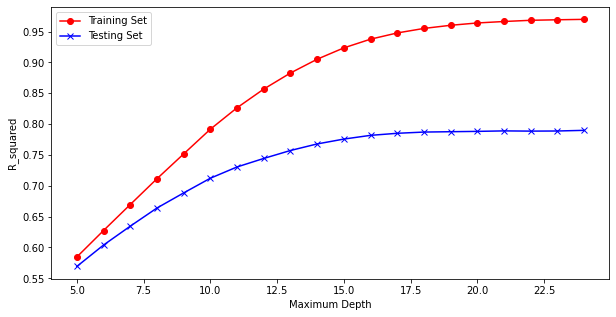

In [237]:
from sklearn.model_selection import validation_curve
def ValidationCurve(estimator, predictors, target, param_name, hyperparam):
    
    train_score, test_score = validation_curve(estimator, predictors, target, param_name, np.arange(5,25), cv=5, scoring='r2')
    Rsqaured_train = train_score.mean(axis=1)
    Rsquared_test= test_score.mean(axis=1)
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(5,25), Rsqaured_train, color='r', linestyle='-', marker='o', label='Training Set')
    plt.plot(np.arange(5,25), Rsquared_test, color='b', linestyle='-', marker='x', label='Testing Set')
    plt.legend(labels=['Training Set', 'Testing Set'])
    plt.xlabel(hyperparam)
    plt.ylabel('R_squared')
    
ValidationCurve(RandomForestRegressor(), X_train_val, y_train_val, 'max_depth', 'Maximum Depth')

# Visualizations with Geopandas

We're going to use the Geopandas library and publicly available GIS maps to visualize the importance of location as a feature.

In [238]:
# reading in our downloaded shape files for king county, downloaded from the king county public GIS site

# we're loading this in as a geopandas data frame, which will read similar to a pandas data frame, but is different!

king_county_surrounding = gpd.read_file('gis/Zipcodes_for_King_County_and_Surrounding_Area_(Shorelines)___zipcode_shore_area.shp')

In [239]:
# check out our data

king_county_surrounding

OBJECTID    ZIP ZIPCODE COUNTY  ZIP_TYPE     Shape_Leng    Shape_Area  \
0           1  98031   98031    033  Standard  117508.231410  2.280129e+08   
1           2  98032   98032    033  Standard  166737.665152  4.826754e+08   
2           3  98033   98033    033  Standard  101363.832386  2.566747e+08   
3           4  98034   98034    033  Standard   98550.460072  2.725072e+08   
4           5  98030   98030    033  Standard   94351.274949  2.000954e+08   
..        ...    ...     ...    ...       ...            ...           ...   
199       200  98402   98402    053  Standard   30734.175856  2.612224e+07   
200       201  98403   98403    053  Standard   23495.033353  2.890938e+07   
201       202  98404   98404    053  Standard   61572.153248  2.160645e+08   
202       203  98405   98405    053  Standard   50261.100128  1.193118e+08   
203       204  98406   98406    053  Standard   74118.971224  1.088373e+08   

                                              geometry  
0    POLYGON ((-122.21842 47.43750, -122.21935 47.4...  
1    MULTIPOLYGON (((-122.24187 47.44122, -122.2411...  
2    POLYGON ((-122.20571 47.65170, -122.20511 47.6...  
3    POLYGON ((-122.17551 47.73706, -122.17554 47.7...  
4    POLYGON ((-122.16746 47.38549, -122.16746 47.3...  
..                                                 ...  
199  POLYGON ((-122.44279 47.26479, -122.44272 47.2...  
200  POLYGON ((-122.44382 47.26617, -122.44434 47.2...  
201  POLYGON ((-122.38900 47.23495, -122.38932 47.2...  
202  POLYGON ((-122.44092 47.23639, -122.44944 47.2...  
203  MULTIPOLYGON (((-122.52125 47.27121, -122.5191...  

[204 rows x 8 columns]

In [240]:
# what type is all of this data?

king_county_surrounding.dtypes

# As a geopandas object, it has this data type "geometry" where it describes the shapes and coordinates

OBJECTID         int64
ZIP              int64
ZIPCODE         object
COUNTY          object
ZIP_TYPE        object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

In [241]:
# This particular GIS map is king county and surrounding, but we want ONLY king county, so we filter out the other counties

king_county = king_county_surrounding[(king_county_surrounding['COUNTY'] == '033')]

In [242]:
# Ready to work with this data frame

king_county

OBJECTID    ZIP ZIPCODE COUNTY  ZIP_TYPE     Shape_Leng    Shape_Area  \
0           1  98031   98031    033  Standard  117508.231410  2.280129e+08   
1           2  98032   98032    033  Standard  166737.665152  4.826754e+08   
2           3  98033   98033    033  Standard  101363.832386  2.566747e+08   
3           4  98034   98034    033  Standard   98550.460072  2.725072e+08   
4           5  98030   98030    033  Standard   94351.274949  2.000954e+08   
..        ...    ...     ...    ...       ...            ...           ...   
124       125  98288   98288    033    PO Box  484750.182616  8.748980e+09   
127       128  98188   98188    033  Standard   94574.310332  2.187023e+08   
128       129  98195   98195    033  Standard   23454.900804  2.170139e+07   
137       138  98354   98354    033  Standard   13089.520224  8.506824e+06   
187       188  98422   98422    033  Standard    9173.558049  1.574725e+06   

                                              geometry  
0    POLYGON ((-122.21842 47.43750, -122.21935 47.4...  
1    MULTIPOLYGON (((-122.24187 47.44122, -122.2411...  
2    POLYGON ((-122.20571 47.65170, -122.20511 47.6...  
3    POLYGON ((-122.17551 47.73706, -122.17554 47.7...  
4    POLYGON ((-122.16746 47.38549, -122.16746 47.3...  
..                                                 ...  
124  POLYGON ((-121.11918 47.77994, -121.11918 47.7...  
127  POLYGON ((-122.24187 47.44122, -122.24363 47.4...  
128  POLYGON ((-122.29028 47.65501, -122.29032 47.6...  
137  POLYGON ((-122.31230 47.26090, -122.31385 47.2...  
187  MULTIPOLYGON (((-122.33147 47.26071, -122.3304...  

[85 rows x 8 columns]

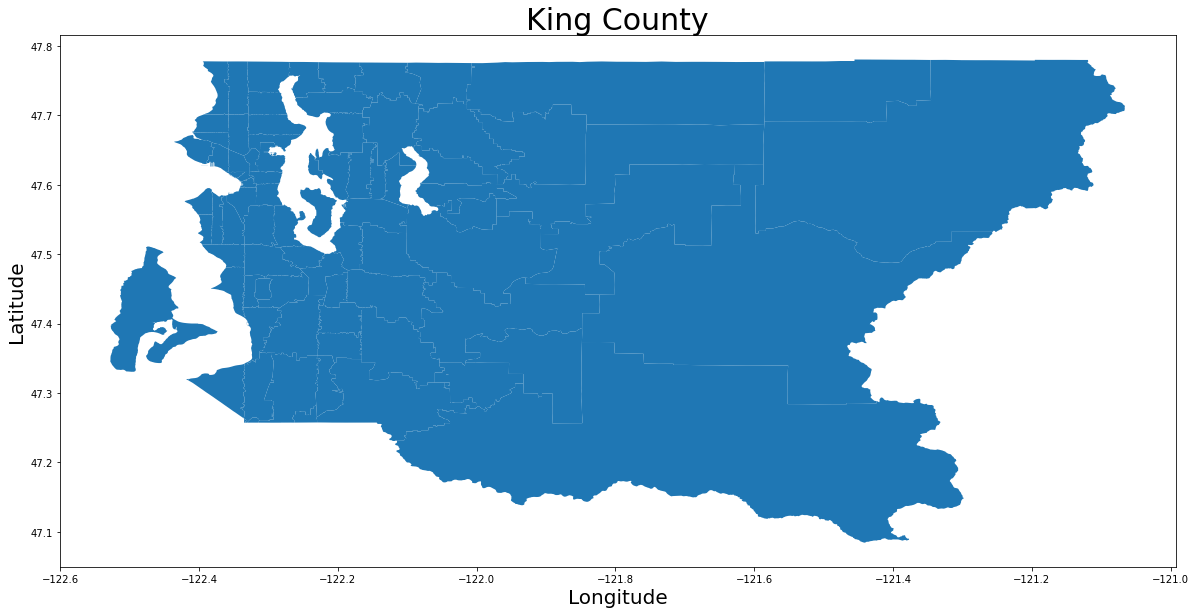

In [243]:
# the heart of a geopandas data frame is visualization, and it is perfectly integrated to do that in a few lines. Here is King County

fig, ax = plt.subplots(figsize = (20,40))
king_county.plot(ax=ax)
ax.set_title('King County',fontdict = {'fontsize': 30})
ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20});

In [244]:
# Our map looks squat and ugly. We are going to figure out how to fix that. First let's check what kind of projection the data
# frame is using

king_county.crs

{'init': 'epsg:4326'}

In [245]:
# We are changing our data into a mercator projection which is the standard world map-style projection that elongates latitude
# and will make the map look more the way we are used to

# Project the data into Mercator Projection epsg=3395
king_county_projected = king_county.to_crs({'init': 'epsg:3395'})

# See the geometry column of the projected countries
king_county_projected['geometry'][:5] 

0    POLYGON ((-13605292.603 5982293.790, -13605395...
1    MULTIPOLYGON (((-13607902.666 5982902.872, -13...
2    POLYGON ((-13603877.542 6017509.230, -13603810...
3    POLYGON ((-13600515.564 6031584.218, -13600518...
4    POLYGON ((-13599619.856 5973763.925, -13599619...
Name: geometry, dtype: geometry

In [246]:
# We're making a new dataframe which is a groupby of our original data grouped by zipcode then sorted by median value
zipsorted = pd.DataFrame(df.groupby('zipcode')['price'].median().sort_values(ascending=True))

# renaming our price column to median
zipsorted.rename(columns={'price':'median'}, inplace=True)

In [247]:
# merging our median home value onto the king county geopandas data frame, on zip code
merged = king_county_projected.set_index('ZIP').join(zipsorted)
merged.head()

OBJECTID ZIPCODE COUNTY  ZIP_TYPE     Shape_Leng    Shape_Area  \
ZIP                                                                     
98031         1   98031    033  Standard  117508.231410  2.280129e+08   
98032         2   98032    033  Standard  166737.665152  4.826754e+08   
98033         3   98033    033  Standard  101363.832386  2.566747e+08   
98034         4   98034    033  Standard   98550.460072  2.725072e+08   
98030         5   98030    033  Standard   94351.274949  2.000954e+08   

                                                geometry    median  
ZIP                                                                 
98031  POLYGON ((-13605292.603 5982293.790, -13605395...  284127.0  
98032  MULTIPOLYGON (((-13607902.666 5982902.872, -13...  249782.0  
98033  POLYGON ((-13603877.542 6017509.230, -13603810...  625868.0  
98034  POLYGON ((-13600515.564 6031584.218, -13600518...  441856.5  
98030  POLYGON ((-13599619.856 5973763.925, -13599619...  281320.0

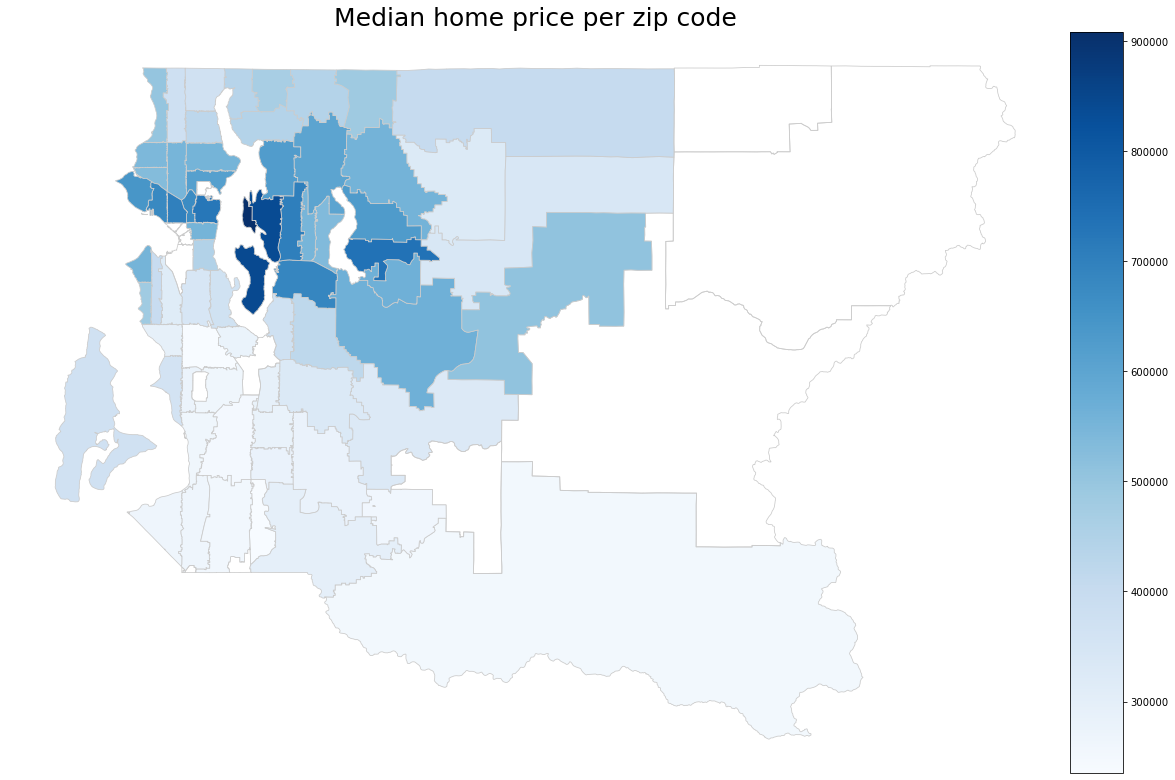

In [248]:
# Making a choropleth which is a geo heat map 

# set the range for the choropleth
vmin, vmax = 120, 220

# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(20,40))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax.set_axis_off()
ax.set_title('Median home price per zip code', fontdict={'fontsize': '25', 'fontweight' : '3'})

# create map
merged.plot(column='median', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax);

Now we're going to build a different type of map, which will have all of our sales plotted in a scatter overlaid on our king county zip code map. We'll use the latitidue and longitude coordinates in our original data frame to do this.

In [271]:
test_actual

0       491232
1       565709
2       829147
3       195122
4       562112
         ...  
3608    370464
3609    720905
3610    441936
3611    295320
3612    846062
Name: price, Length: 3613, dtype: int32

In [272]:
forest_predictions_unscaled

array([491229, 565722, 829106, ..., 441921, 295314, 846299])

In [249]:
crs = {'init': 'epsg:4326'} # initiating my coordinate system
geometry = [Point(x,y) 
           for x,y in zip(df.long,df.lat)] # creating points
geo_df = gpd.GeoDataFrame(df, # the dataframe
                          crs = crs, # coordinate system that the data is using - lat/long uses the crs we initiated
                          geometry = geometry) # geometric points

# Project the coordinates into Mercator Projection epsg=3395 which is what we made our King County map into (otherwise
# our data points would not line up with our map properly)
geo_df_p = geo_df.to_crs({'init': 'epsg:3395'})

In [250]:
# looking at our data to get our quantiles for price

geo_df_p.describe()

id      bedrooms    bathrooms   sqft_living      sqft_lot  \
count  1.806200e+04  18062.000000  18062.00000  18062.000000  18062.000000   
mean   4.735003e+09      3.308161      2.02263   1901.261544   7228.137139   
std    2.863707e+09      0.876859      0.69819    706.020836   3530.445961   
min    1.000102e+06      1.000000      0.50000    370.000000    520.000000   
25%    2.310050e+09      3.000000      1.50000   1370.000000   4800.000000   
50%    4.051105e+09      3.000000      2.00000   1800.000000   7157.500000   
75%    7.504000e+09      4.000000      2.50000   2340.000000   9198.750000   
max    9.900000e+09      9.000000      7.50000   4230.000000  19141.000000   

             floors    waterfront          view     condition         grade  \
count  18062.000000  18062.000000  18062.000000  18062.000000  18062.000000   
mean       1.473674      0.001495      0.070147      3.410475      7.464013   
std        0.543151      0.038635      0.255402      0.649572      0.971612   
min        1.000000      0.000000      0.000000      1.000000      3.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.000000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      1.000000      5.000000     11.000000   

         sqft_above      basement      yr_built     renovated       zipcode  \
count  18062.000000  18062.000000  18062.000000  18062.000000  18062.000000   
mean    1640.374986      0.377644   1969.983778      0.029731  98081.762872   
std      670.268336      0.484811     29.901344      0.169849     54.103819   
min      370.000000      0.000000   1900.000000      0.000000  98001.000000   
25%     1150.000000      0.000000   1950.000000      0.000000  98033.000000   
50%     1470.000000      0.000000   1971.000000      0.000000  98074.000000   
75%     1990.000000      1.000000   1997.000000      0.000000  98119.000000   
max     4230.000000      1.000000   2015.000000      1.000000  98199.000000   

                lat          long  sqft_living15    sqft_lot15    month_sold  \
count  18062.000000  18062.000000   18062.000000  18062.000000  18062.000000   
mean      47.560722   -122.231807    1862.627837   7214.170634      6.568819   
std        0.138561      0.125505     575.113159   3874.048397      3.124282   
min       47.177500   -122.512000     460.000000    651.000000      1.000000   
25%       47.473825   -122.337000    1440.000000   4939.250000      4.000000   
50%       47.570900   -122.268000    1750.000000   7200.000000      6.000000   
75%       47.680500   -122.152000    2190.000000   8891.500000      9.000000   
max       47.777600   -121.821000    4950.000000  89595.000000     12.000000   

        time_series         price  
count  18062.000000  1.806200e+04  
mean       6.518658  4.681236e+05  
std        3.713474  2.039377e+05  
min        0.000000  7.858800e+04  
25%        3.000000  3.105840e+05  
50%        7.000000  4.279380e+05  
75%       10.000000  5.890928e+05  
max       12.000000  1.127743e+06

In [251]:
# dividing our data into four quantiles

first = geo_df_p[geo_df_p['price'] < 194000]

second = geo_df_p[(geo_df_p['price'] >= 194000) & (geo_df['price'] < 310000)]

third = geo_df_p[(geo_df_p['price'] >= 310000) & (geo_df['price'] < 369950)]

fourth = geo_df_p[(geo_df_p['price'] >= 369950) & (geo_df['price'] < 429900)]

fifth = geo_df_p[(geo_df_p['price'] >= 429900) & (geo_df['price'] < 511950)]

sixth = geo_df_p[(geo_df_p['price'] >= 511950) & (geo_df['price'] < 594000)]

seventh = geo_df_p[(geo_df_p['price'] >= 594000) & (geo_df['price'] < 902000)]

eighth = geo_df_p[geo_df_p['price'] >= 902000]

In [252]:
# plotting our quantiles on our map with increasing color depth for price

fig, ax = plt.subplots(figsize = (20,40))
ax.set_aspect(2)
king_county_projected.plot(ax=ax, alpha = 0.8, color = 'grey')

first.plot(ax = ax , markersize = 1, color = '#FFFFFF',marker = 'o',label = '<= 194k')
second.plot(ax = ax , markersize = 1, color = '#FFFFCC',marker = 'o',label = '194k to 310k')
third.plot(ax = ax , markersize = 1, color = '#FFFF00',marker = 'o',label = '310k to 370k')
fourth.plot(ax = ax , markersize = 1, color = '#FFB266',marker = 'o',label = '370k to 430k')
fifth.plot(ax = ax , markersize = 1, color = '#FF8000',marker = 'o',label = '430k to 512k')
sixth.plot(ax = ax , markersize = 1, color = '#FF0000',marker = 'o',label = '512k to 594k')
seventh.plot(ax = ax , markersize = 1, color = '#990000',marker = 'o',label = '594k to 902k')
eighth.plot(ax = ax , markersize = 1, color = '#000000',marker = 'o',label = '>= 902k')


plt.legend(prop = {'size':20} )


lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=20)
for handle in lgnd.legendHandles:
    handle.set_sizes([80.0])

ax.set_title('Houses in King County, WA', fontdict = {'fontsize':
                20})

ax.set_axis_off()

After seeing this particular visualization, we went back and included latitude as a predictor in our model, independent of zip code.

# Comps "Model"

Realtors have, traditionally, used a more grassroots method for predicting sales prices - the comps model. "Comps" are comparative properties, which are located in a nearby geographical area and have similar feature stats. With comps, a realtor looks for other similar houses in the area of the house being listed, and selects a price appropriately. It's a very literal application of K-nearest neighbors where the 2-dimensional grid is the latitude and longitude, and a neighbor is defined as the points having the closest physical feature similarities. We are going to build a comps "model" and see how our regression model compares. I use "model" in quotes because this isn't a model in machine learning terms. It requires the entire dataset to produce an answer, rather than a regression model which is a mathematical expression that we can save and utilize independently. It is essentially a "realtor simulator" which simulates the behavior of a realtor looking for comps. However for the purposes of our research, this is a Comps Model.

## Data Prep

In [253]:
# our data set for a comps model looks a lot simpler, and requires no feature scaling

df_comps = df[['lat', 'long', 'price', 'sqft_living', 'sqft_lot', 'bedrooms', 'condition', 'grade']]
df_comps['price'] = df['price']
df_comps

lat     long     price  sqft_living  sqft_lot  bedrooms  condition  \
0      47.5112 -122.257  222876.0         1180      5650         3          3   
1      47.7210 -122.319  539691.0         2570      7242         3          3   
2      47.7379 -122.233  180339.0          770     10000         2          3   
3      47.5208 -122.393  605898.0         1960      5000         4          5   
4      47.6168 -122.045  510962.0         1680      8080         3          3   
...        ...      ...       ...          ...       ...       ...        ...   
18057  47.6993 -122.346  362715.0         1530      1131         3          3   
18058  47.5107 -122.362  400754.0         2310      5813         4          3   
18059  47.5944 -122.299  404881.0         1020      1350         2          3   
18060  47.5345 -122.069  401006.0         1600      2388         3          3   
18061  47.5941 -122.299  326430.0         1020      1076         2          3   

       grade  
0          7  
1          7  
2          6  
3          7  
4          8  
...      ...  
18057      8  
18058      8  
18059      7  
18060      8  
18061      7  

[18062 rows x 8 columns]

In [254]:
# our descriptors can help us figure out the appropriate range to use when seeking a comp for each of these features

df_comps.describe()

lat          long         price   sqft_living      sqft_lot  \
count  18062.000000  18062.000000  1.806200e+04  18062.000000  18062.000000   
mean      47.560722   -122.231807  4.681236e+05   1901.261544   7228.137139   
std        0.138561      0.125505  2.039377e+05    706.020836   3530.445961   
min       47.177500   -122.512000  7.858800e+04    370.000000    520.000000   
25%       47.473825   -122.337000  3.105840e+05   1370.000000   4800.000000   
50%       47.570900   -122.268000  4.279380e+05   1800.000000   7157.500000   
75%       47.680500   -122.152000  5.890928e+05   2340.000000   9198.750000   
max       47.777600   -121.821000  1.127743e+06   4230.000000  19141.000000   

           bedrooms     condition         grade  
count  18062.000000  18062.000000  18062.000000  
mean       3.308161      3.410475      7.464013  
std        0.876859      0.649572      0.971612  
min        1.000000      1.000000      3.000000  
25%        3.000000      3.000000      7.000000  
50%        3.000000      3.000000      7.000000  
75%        4.000000      4.000000      8.000000  
max        9.000000      5.000000     11.000000

In [255]:
# We want both latitude and longitude together in order to locate the exact location of a property.
# We make a new column in our data frame that groups this coordinate location together
# We also prepare our data column of predictions and populate it with NaN

dataset = list(zip(df_comps['lat'],df_comps['long']))
df_comps['coordinates'] = dataset
#df_comps['comps_est'] = np.NaN
df_comps.reset_index(inplace=True, drop=True)
df_comps

lat     long     price  sqft_living  sqft_lot  bedrooms  condition  \
0      47.5112 -122.257  222876.0         1180      5650         3          3   
1      47.7210 -122.319  539691.0         2570      7242         3          3   
2      47.7379 -122.233  180339.0          770     10000         2          3   
3      47.5208 -122.393  605898.0         1960      5000         4          5   
4      47.6168 -122.045  510962.0         1680      8080         3          3   
...        ...      ...       ...          ...       ...       ...        ...   
18057  47.6993 -122.346  362715.0         1530      1131         3          3   
18058  47.5107 -122.362  400754.0         2310      5813         4          3   
18059  47.5944 -122.299  404881.0         1020      1350         2          3   
18060  47.5345 -122.069  401006.0         1600      2388         3          3   
18061  47.5941 -122.299  326430.0         1020      1076         2          3   

       grade          coordinates  
0          7  (47.5112, -122.257)  
1          7   (47.721, -122.319)  
2          6  (47.7379, -122.233)  
3          7  (47.5208, -122.393)  
4          8  (47.6168, -122.045)  
...      ...                  ...  
18057      8  (47.6993, -122.346)  
18058      8  (47.5107, -122.362)  
18059      7  (47.5944, -122.299)  
18060      8  (47.5345, -122.069)  
18061      7  (47.5941, -122.299)  

[18062 rows x 9 columns]

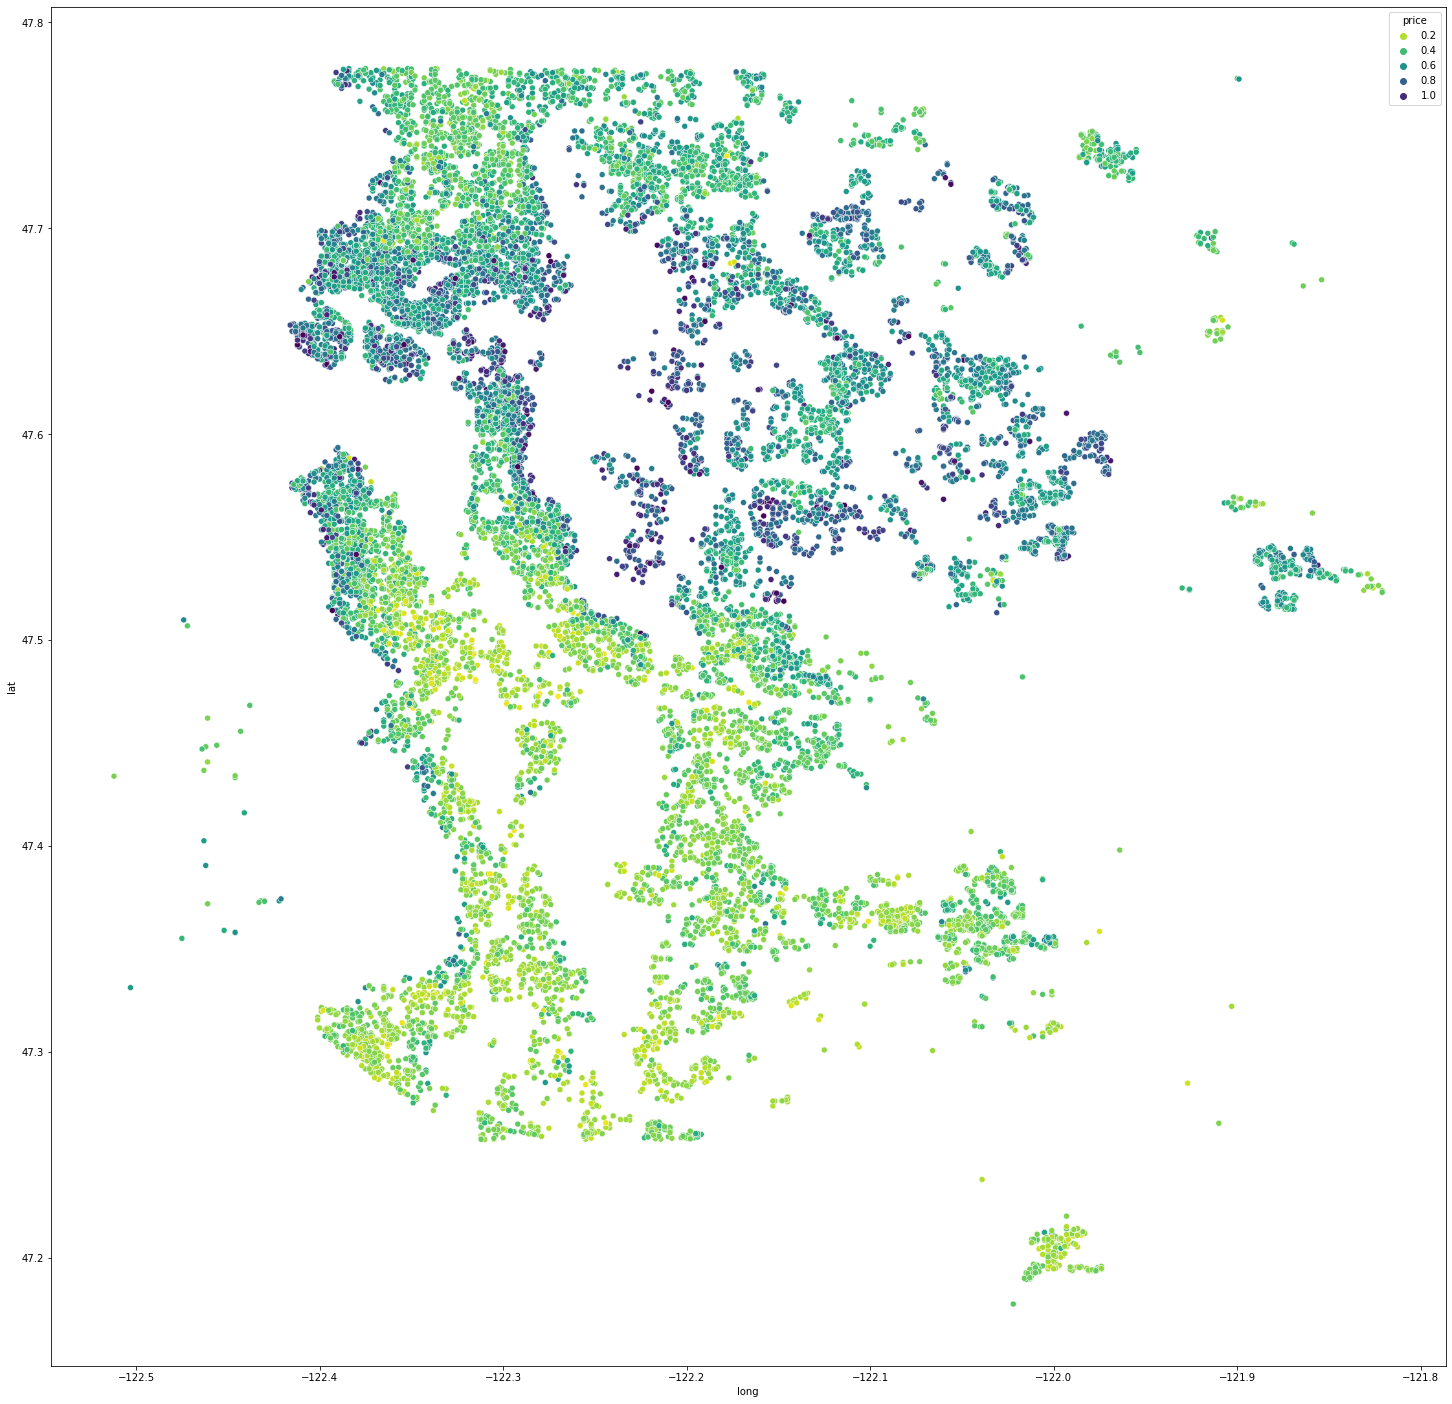

In [256]:
# A fun visual to see how using lat/long and comps makes a k-nearest neighbors problem.
# When we plot the latitude and longitude, we end up with a map of king county home sales!

plt.figure(figsize=(25,25))

sns.scatterplot(data=df_comps, x="long", y="lat", hue="price", palette="viridis_r");

Generate comps

* Generate a sq footage % range
* Generate a lot size % range
* Decide if +/- 1 bedroom is acceptable
* Decide if +/- 1 condition is acceptable


* For KNN:
    * For each entry:
    * establish comp requirements
    * create comp dataframe
    * determine neighborhood inclusion zone using within reasonable lat/long
    * create check dataframe which only includes entries within the inclusion zone
    * make sure there are at least x entries available. If not, increase inclusion zone.
    * calculate euclidian distance against all entries in inclusion zone
    * store euclidian distance to dataframe column for local zone
    * accept top x entries by euclidian distance


## Comps Functions

In [257]:
def inclusion_zone(base_property, housing_set):
    lat = base_property['lat']
    long = base_property['long']
    eligible_zone = housing_set.loc[(housing_set['lat'] >= (lat-latrange)) & 
                                        (housing_set['lat'] <= (lat+latrange))&
                                      (housing_set['long'] >= (long-longrange)) & 
                                       (housing_set['long'] <= (long+longrange))]
    return eligible_zone

def find_comps(base_property, housing_set, bedrooms, condition, grade):
    eligible_zone = inclusion_zone(base_property, housing_set)
    sqft = base_property['sqft_living']
    lot = base_property['sqft_lot']
    
    eligible_homes = eligible_zone.loc[(eligible_zone['sqft_living'] >= (sqft*(1-sqftrange))) & 
                                   (eligible_zone['sqft_living'] <= (sqft*(1+sqftrange))) &
                                  (eligible_zone['sqft_lot'] >= (lot*(1-lotrange))) & 
                                   (eligible_zone['sqft_lot'] <= (lot*(1+lotrange))) &
                                  (eligible_zone['bedrooms'] >= (bedrooms-(1+bedmod))) & 
                                   (eligible_zone['bedrooms'] <= (bedrooms+(1+bedmod))) &
                                  (eligible_zone['condition'] >= (condition-(1+condmod))) & 
                                   (eligible_zone['condition'] <= (condition + (1+condmod))) & 
                                       (eligible_zone['grade'] >= (grade-(1+grademod))) & 
                                       (eligible_zone['grade'] <= (grade + (1+grademod)))]
    return eligible_homes


from math import sqrt
 
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

def comp_value(base_property, housing_set):
    bedrooms = base_property['bedrooms']
    condition = base_property['condition']
    grade = base_property['grade']
    start_coordinates = base_property['coordinates']
    eligible_homes = find_comps(base_property, housing_set, bedrooms, condition, grade)
    if eligible_homes.shape[0] >= 11:
        eligible_homes['distance'] = eligible_homes['coordinates'].apply(lambda x: euclidean_distance(start_coordinates, x))
        eligible_homes = eligible_homes.sort_values('distance', ascending=True)
        current_index = base_property.name
        comps = eligible_homes.iloc[:6]
        sq_footage = comps['sqft_living'].sum()
        total_price = comps['price'].sum()
        pr_sqft = total_price/sq_footage
        comp_value = base_property['sqft_living'] * pr_sqft
        comp_value = round(comp_value, 0)      
        return comp_value
    else:
        return np.nan
    

## Comps Model

In [258]:
X = df_comps.drop('price', axis=1)
y = df_comps['price']

compsfinder, getcomps, y_train, actual = train_test_split(X, y, test_size=0.2, random_state=randomstate)

In [259]:
compsfinder['price'] = y_train
getcomps['actual'] = actual

In [260]:
getcomps

lat     long  sqft_living  sqft_lot  bedrooms  condition  grade  \
14503  47.7520 -122.144         2110     16200         4          3      8   
11206  47.6274 -122.094         2030      7350         4          3      8   
6169   47.5917 -122.290         2290      6300         4          4      7   
3977   47.3249 -122.207         1070      6110         3          4      7   
17210  47.6783 -122.366         1530      1786         3          3      8   
...        ...      ...          ...       ...       ...        ...    ...   
3587   47.4948 -122.134         1360     10726         3          4      7   
11598  47.6238 -122.191         1370      9460         2          3      6   
10027  47.7079 -122.358         1480      7560         4          3      7   
8661   47.7414 -122.295         1060      7868         2          3      7   
9976   47.6447 -122.327         1600      2538         3          3      7   

               coordinates    actual  
14503   (47.752, -122.144)  491232.0  
11206  (47.6274, -122.094)  565710.0  
6169    (47.5917, -122.29)  829148.0  
3977   (47.3249, -122.207)  195123.0  
17210  (47.6783, -122.366)  562112.0  
...                    ...       ...  
3587   (47.4948, -122.134)  370465.0  
11598  (47.6238, -122.191)  720905.0  
10027  (47.7079, -122.358)  441936.0  
8661   (47.7414, -122.295)  295321.0  
9976   (47.6447, -122.327)  846062.0  

[3613 rows x 9 columns]

How can we figure out what parameters give us the best comps results? We want to use something similar to GridSearchCV, but we haven't written a custom estimator. To do this, we will use sklearn's ParameterGrid. It puts together parameter combinations for us to use in whatever custom fashion we wish.

In [261]:
from sklearn.model_selection import ParameterGrid

param_grid = {'latrange': [.005, .01], 'longrange': [.005, .01], 'sqftrange': [.025, .05], 'lotrange': [.1, .2], 'bedmod': [.25], 'condmod': [.5, 1], 'grademod': [.5, 1, 1.5], }

combos = list(ParameterGrid(param_grid))

len(combos)

96

We're going to apply our 54 different parameter combinations to our testing dataframe. Afterward we'll check which parameters gave us the best results, and use those parameters for our final "comps model". Unfortunately, we don't have cv for this task. That's bad news for us.

Testing our parameters took a couple of hours, so after running it once, I comment it out and store the results.

In [262]:
'''
comps_scores = {}

for i in range(len(combos)):
    parameters = combos[i]
    getcomps[i] = None
    latrange = .02
    longrange = .02
    sqftrange = .1
    lotrange = .5
    bedmod = 0
    condmod = 0
    grademod = 1
    while getcomps.isna().sum()[i] != 0:
        getcomps.loc[getcomps[i].isna(), i] = getcomps.loc[getcomps[i].isna()].apply(lambda x: comp_value(x, compsfinder), axis=1)
        latrange += combos[i]['latrange']
        longrange += combos[i]['longrange']
        sqftrange += combos[i]['sqftrange']
        lotrange += combos[i]['lotrange']
        bedmod += combos[i]['bedmod']
        condmod += combos[i]['condmod']
        grademod += combos[i]['grademod']
    key = str(combos[i])
    value = round(mean_absolute_error(getcomps['actual'], getcomps[i]), 2)
    comps_scores[key] = value
    print(i+1, value, parameters)
'''

"\ncomps_scores = {}\n\nfor i in range(len(combos)):\n    parameters = combos[i]\n    getcomps[i] = None\n    latrange = .02\n    longrange = .02\n    sqftrange = .1\n    lotrange = .5\n    bedmod = 0\n    condmod = 0\n    grademod = 1\n    while getcomps.isna().sum()[i] != 0:\n        getcomps.loc[getcomps[i].isna(), i] = getcomps.loc[getcomps[i].isna()].apply(lambda x: comp_value(x, compsfinder), axis=1)\n        latrange += combos[i]['latrange']\n        longrange += combos[i]['longrange']\n        sqftrange += combos[i]['sqftrange']\n        lotrange += combos[i]['lotrange']\n        bedmod += combos[i]['bedmod']\n        condmod += combos[i]['condmod']\n        grademod += combos[i]['grademod']\n    key = str(combos[i])\n    value = round(mean_absolute_error(getcomps['actual'], getcomps[i]), 2)\n    comps_scores[key] = value\n    print(i+1, value, parameters)\n"

1 120176.49 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
2 118470.94 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
3 120092.22 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
4 119308.61 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
5 125567.83 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
6 125818.76 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
7 125678.26 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
8 126838.63 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
9 124148.03 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
10 123145.39 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
11 123884.52 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
12 123974.23 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
13 130806.52 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
14 130229.15 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
15 130912.94 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
16 131376.29 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
17 109069.36 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
18 109410.56 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
19 109501.47 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
20 109628.37 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
21 113711.81 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
22 112078.32 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
23 114349.97 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
24 112635.79 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
25 112416.4 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
26 111906.24 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
27 113546.95 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
28 111855.1 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
29 115435.05 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
30 114966.29 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
31 115853.64 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
32 115724.15 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
33 103109.21 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
34 105918.24 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
35 103308.97 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
36 106624.58 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
37 106770.74 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
38 108781.33 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
39 107146.03 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
40 109315.67 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
41 104331.4 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
42 107826.18 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
43 105042.17 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
44 108565.07 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
45 108125.17 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
46 110442.01 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
47 108365.6 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
48 111155.63 {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
49 120177.97 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
50 118484.18 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
51 120098.53 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
52 119321.76 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
53 125568.8 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
54 125822.89 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
55 125679.46 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
56 126842.73 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
57 124146.01 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
58 123145.33 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
59 123887.17 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
60 123974.17 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
61 130803.34 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
62 130232.94 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
63 130910.0 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
64 131384.24 {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
65 109067.73 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
66 109557.09 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
67 109569.0 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
68 109577.98 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
69 113897.47 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
70 112456.21 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
71 114595.74 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
72 113084.43 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
73 112575.32 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
74 112204.46 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
75 113676.87 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
76 112159.97 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
77 115689.08 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
78 115554.46 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
79 116208.53 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
80 116353.97 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
81 103123.19 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
82 105915.06 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
83 103389.54 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
84 106626.86 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
85 106836.31 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
86 108882.75 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
87 107222.31 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
88 109326.32 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}
89 104428.36 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025}
90 107945.19 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.05}
91 105094.56 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.025}
92 108595.39 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.005, 'lotrange': 0.2, 'sqftrange': 0.05}
93 108237.1 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.025}
94 110556.68 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.1, 'sqftrange': 0.05}
95 108496.59 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.025}
96 111199.52 {'bedmod': 0.25, 'condmod': 1, 'grademod': 1.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}

In [263]:
# picked out the best scoring combination

#key_min = min(comps_scores.keys(), key=(lambda k: comps_scores[k]))
#key_max = max(comps_scores.keys(), key=(lambda k: comps_scores[k]))
#print('Best: '+key_min, '\nWorst: '+key_max)

    Best: {'bedmod': 0.25, 'condmod': 0.5, 'grademod': 1.5, 'latrange': 0.005, 'longrange': 0.005, 'lotrange': 0.1, 'sqftrange': 0.025} 
    Worst: {'bedmod': 0.25, 'condmod': 1, 'grademod': 0.5, 'latrange': 0.01, 'longrange': 0.01, 'lotrange': 0.2, 'sqftrange': 0.05}

In [264]:
compsfinder

lat     long  sqft_living  sqft_lot  bedrooms  condition  grade  \
12380  47.6692 -122.392         1730      1074         3          3      8   
7068   47.5882 -122.290         2640      8400         4          3      8   
9483   47.6964 -122.024         1680      4075         3          3      7   
13205  47.7372 -121.981         1370      5000         3          3      7   
126    47.3887 -122.286         2260     12500         5          4      8   
...        ...      ...          ...       ...       ...        ...    ...   
15159  47.4973 -122.177         2500      8289         3          4      7   
10213  47.3438 -122.037         1210      9750         2          3      7   
16253  47.3940 -122.183         1800      4500         4          4      8   
17352  47.5442 -122.116         3650     18223         4          3      9   
4762   47.6191 -122.043         2150      7484         3          3      8   

               coordinates     price  
12380  (47.6692, -122.392)  525330.0  
7068    (47.5882, -122.29)  611533.0  
9483   (47.6964, -122.024)  395733.0  
13205  (47.7372, -121.981)  300139.0  
126    (47.3887, -122.286)  259135.0  
...                    ...       ...  
15159  (47.4973, -122.177)  316386.0  
10213  (47.3438, -122.037)  156896.0  
16253   (47.394, -122.183)  322614.0  
17352  (47.5442, -122.116)  803922.0  
4762   (47.6191, -122.043)  371027.0  

[14449 rows x 9 columns]

In [265]:
getcomps['comps_est'] = np.NaN

latrange = .02
longrange = .02
sqftrange = .1
lotrange = .5
bedmod = 0
condmod = 0
grademod = 1

while getcomps.isna().sum()['comps_est'] != 0:
    getcomps.loc[getcomps.comps_est.isna(), 'comps_est'] = getcomps.loc[getcomps.comps_est.isna()].apply(lambda x: comp_value(x, compsfinder), axis=1)
    latrange += .005
    longrange += .005
    sqftrange += .025
    lotrange += .1
    bedmod += .25
    condmod += .5
    grademod += 1.5


In [266]:
comps_predictions = getcomps[['actual', 'comps_est']]
comps_predictions

actual  comps_est
14503  491232.0   463886.0
11206  565710.0   593227.0
6169   829148.0   756941.0
3977   195123.0   163464.0
17210  562112.0   535386.0
...         ...        ...
3587   370465.0   311107.0
11598  720905.0   837303.0
10027  441936.0   405792.0
8661   295321.0   316588.0
9976   846062.0   667531.0

[3613 rows x 2 columns]

In [267]:
# Calculate our mean absolute error

mae = round(mean_absolute_error(getcomps['actual'], getcomps['comps_est']), 2)
mae

60250.09

In [268]:
rmse = round(np.sqrt(mean_squared_error(getcomps['actual'], getcomps['comps_est'])), 2)
rmse

87148.02

In [269]:
plt.figure(figsize=(10,5))
sns.distplot(getcomps['actual'], hist=True, kde=False)
sns.distplot(getcomps['comps_est'], hist=True, kde=False)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [270]:
models['Models'].append('Realtor Simulator')
models['r2'].append(None)
models['mae'].append(mae)
models['rmse'].append(rmse)

It would seem that our "realtor simulator" performs worse than our regression model, but not by a lot.

# Model Selection

We ran several different types of models, and logged the r^squared and mean absolute error for each model type. Which model performed the best for us?

In [271]:
model_types = pd.DataFrame(models)

In [272]:
model_types = model_types.sort_values('mae', ascending=True).reset_index()
model_types.drop('index',axis=1, inplace=True)

In [273]:
model_types

Models        r2       mae       rmse
0        Gradient Boosting  0.833974  57192.68   13811.24
1                      SVR  0.846665  58577.72   84465.40
2           LAD Regression  0.845314  58831.36   14507.51
3                    RFECV  0.850510  58842.36   13416.20
4                 Basic LR  0.847246  58842.39   13383.61
5                    Ridge  0.846874  58842.42   84718.92
6       Forw-Back Selector  0.847129  58933.09   84940.65
7   Permutation Importance  0.847397  59077.17   14203.78
8        Realtor Simulator       NaN  60250.09   87148.02
9              Elastic Net  0.828165  61536.13   86665.27
10                   Lasso  0.814809  62924.99   88468.61
11           Random Forest  0.791519  64838.87   14128.37
12                     KNN  0.704989  74903.01   13290.80
13                     KNN  0.647203  85140.04  119431.28

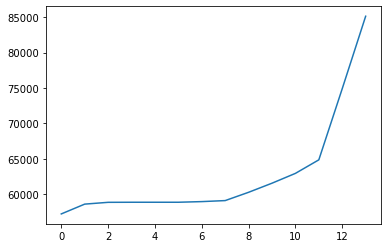

In [274]:
plt.plot(model_types['mae'])

## TO DO make this nice

In [ ]:
break

# Final Model

Now that we've chosen a favorite regression for this problem (Ridge), we want to be able to actually use the model to predict new data. Our steps are as follows:

* Build a model using our ENTIRE dataset for deployment
* Write our own standardization functions that we can apply to incoming new data
* Prepare a more intuitive GUI for predicting on new data

## Train model on entire data set

### Re-merge Continuous

In [456]:
x_test_cont

sqft_living  sqft_lot  floors  bedrooms  bathrooms  condition  grade
0            2110     16200     1.0         4       2.25          3      8
1            2030      7350     1.0         4       1.75          3      8
2            2290      6300     1.5         4       1.00          4      7
3            1070      6110     1.0         3       1.75          4      7
4            1530      1786     2.0         3       3.25          3      8
...           ...       ...     ...       ...        ...        ...    ...
3608         1360     10726     1.0         3       1.50          4      7
3609         1370      9460     1.0         2       1.00          3      6
3610         1480      7560     1.5         4       1.00          3      7
3611         1060      7868     1.0         2       1.00          3      7
3612         1600      2538     2.0         3       1.75          3      7

[3613 rows x 7 columns]

In [457]:
x_train_cont

sqft_living  sqft_lot  floors  bedrooms  bathrooms  condition  grade
0             1730      1074     3.5         3       3.00          3      8
1             2640      8400     1.0         4       2.75          3      8
2             1680      4075     2.0         3       2.50          3      7
3             1370      5000     2.0         3       2.25          3      7
4             2260     12500     1.0         5       2.00          4      8
...            ...       ...     ...       ...        ...        ...    ...
14444         2500      8289     1.0         3       1.75          4      7
14445         1210      9750     1.0         2       1.75          3      7
14446         1800      4500     2.0         4       2.25          4      8
14447         3650     18223     2.0         4       4.00          3      9
14448         2150      7484     2.0         3       2.50          3      8

[14449 rows x 7 columns]

In [458]:
X_all_continuous = x_test_cont.append(x_train_cont)
X_all_continuous.reset_index(inplace=True)
X_all_continuous.drop('index', axis=1, inplace=True)

## Write standardization function to apply to new data

While forming our model, we used the sklearn StandardScaler. But how do we scale brand new features that we are trying to predict from? In order to do so, we need to write a standardization function for each of our features, that we can then save and apply to our new prediction data.

In [459]:
standardization_coeffs = {}

for item in X_all_continuous:
    standardization_coeffs[item+'_mean'] = X_all_continuous[item].mean()
    standardization_coeffs[item+'_std'] = X_all_continuous[item].std()

print(standardization_coeffs)

{'sqft_living_mean': 1901.2615435721405, 'sqft_living_std': 706.0208356159178, 'sqft_lot_mean': 7228.137138744325, 'sqft_lot_std': 3530.445960653942, 'floors_mean': 1.473674011737349, 'floors_std': 0.5431511040089493, 'bedrooms_mean': 3.30816077953715, 'bedrooms_std': 0.8768591455829121, 'bathrooms_mean': 2.0226303842320896, 'bathrooms_std': 0.6981901877398363, 'condition_mean': 3.41047503045067, 'condition_std': 0.6495724882470049, 'grade_mean': 7.464012844646218, 'grade_std': 0.9716115644197678}


### TO DO apply standardization to continuous frame here before merge

### Save Standardization coefficients to file

In [461]:
# save standardization coefficients to file so I can use these later
with open('standardization_coeffs.csv','w', newline="") as f:
    w = csv.writer(f)
    w.writerows(standardization_coeffs.items())

### Re-merge train and holdout

In [468]:
x_categorical

zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              0              0              0              0   
18061              0              0              0              0   

       zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              0              0              0              0   
18061              0              0              0              0   

       zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              0              0              0              0   
18061              0              0              0              0   

       zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              1   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              0              0              1              0   
18061              0              0              0              0   

       zipcode_98029  zipcode_98030  zipcode_98031  zipcode_98032  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
1

In [469]:
X_all_categoricals = x_test_cat.append(x_train_cat)
X_all_categoricals.reset_index(inplace=True)
X_all_categoricals.drop('index', axis=1, inplace=True)

In [470]:
X_final = pd.concat([X_all_continuous, X_all_categoricals], axis=1)

In [471]:
X_final

sqft_living  sqft_lot  floors  bedrooms  bathrooms  condition  grade  \
0             2110     16200     1.0         4       2.25          3      8   
1             2030      7350     1.0         4       1.75          3      8   
2             2290      6300     1.5         4       1.00          4      7   
3             1070      6110     1.0         3       1.75          4      7   
4             1530      1786     2.0         3       3.25          3      8   
...            ...       ...     ...       ...        ...        ...    ...   
18057         2500      8289     1.0         3       1.75          4      7   
18058         1210      9750     1.0         2       1.75          3      7   
18059         1800      4500     2.0         4       2.25          4      8   
18060         3650     18223     2.0         4       4.00          3      9   
18061         2150      7484     2.0         3       2.50          3      8   

       zipcode_98002  zipcode_98003  zipcode_98004  zipcode_98005  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  1              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              0              0              0              0   
18061              0              0              0              0   

       zipcode_98006  zipcode_98007  zipcode_98008  zipcode_98010  \
0                  0              0              0              0   
1                  0              0              1              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              1              0              0              0   
18061              0              0              0              0   

       zipcode_98011  zipcode_98014  zipcode_98019  zipcode_98022  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              0              0              0              0   
18059              0              0              0              0   
18060              0              0              0              0   
18061              0              0              0              0   

       zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0                  0              0              0              0   
1                  0              0              0              0   
2                  0              0              0              0   
3                  0              0              0              0   
4                  0              0              0              0   
...              ...            ...            ...            ...   
18057              0              0              0              0   
18058              

In [472]:
y_final = y_test.append(y_train_val)
y_final.reset_index(inplace=True)
y_final.drop('index', axis=1, inplace=True)

### TO DO save scaler to file

In [424]:
# Using sklearn RFECV to perform integrated CV while picking the number of features
# picks the number of features itself

model = LinearRegression()
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
final_model = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error')
final_model.fit(X_final, y_final)

RFECV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=1),
      estimator=LinearRegression(), scoring='neg_mean_absolute_error')

In [425]:
#final_model = Ridge(alpha = [0.1])
#final_model.fit(X, y)

### Save model to file

In [426]:
#from joblib import dump
#dump(final_model, 'final_model.joblib') 

### Other modeling things we need to save

lat_bins and year_bins
features columns

# Making New Predictions

    sqft_living - number
    sqft_lot - number
    floors - number
    bedrooms - number
    bathrooms - number
    condition - pick from range
    grade - pick from range
    comparative_sf - pick from range
    zipcode - number
    month - number
    age_group - enter year built
    lat_round - enter address for lookup
    waterfront - yes/no
    renovated - yes/no
    basement - yes/no

## Set up empty/default predictive data frame

In [359]:
predictors_train = sm.add_constant(X_final)
model = sm.OLS(y_final, predictors_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     2199.
Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:46:18   Log-Likelihood:                -5310.4
No. Observations:               18062   AIC:                         1.064e+04
Df Residuals:                   18054   BIC:                         1.070e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9616      0.002   5363.910      0.000      12.957      12.966
sqft_living     0.1940      0.004     43.192      0.000       0.185       0.203
sqft_lot       -0.0838      0.003    -29.740      0.000      -0.089      -0.078
floors         -0.0233      0.003     -7.100      0.000      -0.030      -0.017
bedrooms       -0.0210      0.003     -6.570      0.000      -0.027      -0.015
bathrooms      -0.0232      0.004     -6.037      0.000      -0.031      -0.016
condition       0.0659      0.003     25.914      0.000       0.061       0.071
grade           0.1811      0.004     50.256      0.000       0.174       0.188
==============================================================================
Omnibus:                       22.001   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.278
Skew:                          -0.067   Prob(JB):                     2.40e-05
Kurtosis:                       2.897   Cond. No.                         3.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [427]:
# Get the columns that we use from our final model
columns = X_train_val.columns

## Predictive Functions

In [466]:
# Function to standardize new data according to the mean and std deviation that we saved for each column

def standardize_continuous(key, value):
    """Standardize a value according to saved mean and standard deviation saved values"""
    transformed = (np.log(value) - standardization_coeffs[key+'_mean']) / standardization_coeffs[key+'_std']

    return transformed

In [446]:
def predict_from_one(continuous, dichotomous, high_card_cat, binned):
    """Takes in a series of dictionaries with predictive variables. Pre-processes the variables
    to conform with model predictors. Runs model on submitted predictors and returns a prediction."""
    
    # create an empty dictionary to store our predictor parameters
    test_parameters = {}
    
    # create our predictor data frame full of 0s
    test_frame = pd.DataFrame(0, index=range(1), columns=columns)

    # standardize and store our continuous variables in our predictor dictionary
    for item in continuous:
        test_parameters[item] = standardize_continuous(item, continuous[item])
    
    # for our categoricals, not all are used in our model. For each categorical that we would create with our entered data,
    # we check first and see if it's in our model at all. If the column is there, it stores
    # the predictor in our predictor dictionary as a 1, otherwise it is ignored.
    
    # This code first checks if the column we want is in our data frame. If the column is there, it stores
    # this predictor in our predictor dictionary as a 1
    for item in high_card_cat:
        if item+'_'+str(high_card_cat[item]) in test_frame.columns:
            test_parameters[item+'_'+str(high_card_cat[item])] = 1
        
    # This code first checks if the column we want is in our data frame. If the column is there, it stores
    # this predictor in our predictor dictionary as a 1
    for item in dichotomous:
        if dichotomous[item]:
            test_parameters[item+'_1.0']=1

    # function to find lower and upper bin bounds for our age blocks
    def age_block_finder(year, bins):
        for i in range(len(bins)):
            if year > bins[i] and year < bins[i+1]:
                lower_year, upper_year = bins[i], bins[i+1]
            else: continue
        return lower_year, upper_year


    # find the lower and upper bounds for age block and lat block
    lower_year, upper_year = age_block_finder(year_built, year_bins) # lower and upper bounds for our age block

    # This code first checks if the column we want is in our data frame. If the column is there, it stores
    # this predictor in our predictor dictionary as a 1
    if 'year_block_('+str(lower_year)+', '+str(upper_year)+']' in test_frame.columns:
        test_parameters['year_block_('+str(lower_year)+', '+str(upper_year)+']'] = 1
      
    # enter all of our predictors into our predictor data frame
    for item in test_parameters:
        value = test_parameters[item]
        test_frame[item] = value
    
    # send the predictor data frame to the model and get a prediction
    predicted_price = int(np.exp(final_model.predict(test_frame)))    
    
    # return the prediction
    return predicted_price

In [447]:
def prepare_line(x):
    sqft_living = x['sqft_living']
    sqft_lot = x['sqft_lot']
    floors = x['floors']
    bedrooms = x['bedrooms']
    bathrooms = x['bathrooms']
    zipcode = x['zipcode']
    month = x['month_sold']
    condition = x['condition']
    grade = x['grade']
    comparative_sf = x['comparative_sf']
    year_built = x['year_built']
    waterfront = x['waterfront']
    renovated = x['renovated']
    basement = x['basement']

    continuous = {'sqft_living':sqft_living, 'sqft_lot':sqft_lot, 'floors':floors, 'bedrooms':bedrooms, 'bathrooms':bathrooms, 'condition':condition, 'grade':grade}
    dichotomous = {'waterfront':waterfront, 'renovated':renovated, 'basement':basement}
    high_card_cat = {'zipcode': zipcode, 'month_sold':month, 'comparative_sf':comparative_sf}
    binned = {'year_built':year_built}
    
    predicted_price = predict_from_one(continuous, dichotomous, high_card_cat, binned)
 
    return predicted_price

In [448]:
def predict_from_dataframe(new_data):
    predictions = []
    actuals = []
    actuals = new_data.apply(lambda x: get_actual(x), axis=1)
    predictions = new_data.apply(lambda x: prepare_line(x), axis=1)
    new_predictions = pd.DataFrame()
    new_predictions['actual'] = actuals
    new_predictions['predictions'] = predictions
    return new_predictions

In [449]:
def get_actual(line):
    actual = line['actual']
    return actual

## Enter Predictors

### Future Work - GUI

This section could be a GUI, where a realtor can enter these various details into a user-friendly interface and have the details converted to proper format for our predictor behind the scenes.

We're not going to create this GUI here, so some of our data will be pre-processed when entered into our predictive matrix.

## Predict one independent entry

In [450]:
sqft_living = 1960
sqft_lot = 5000
floors = 2
bedrooms = 2.5
bathrooms = 4
zipcode = 98136
month = 12

# The description here is: Overall property condition
# The choices here are: Poor, Okay, Average, Good, Excellent
# provide examples to indicate that this variable indicates property repair/maintenance level, not quality of materials
# GUI: checkbox, check only one
condition = 3

# The description here is: Quality of property materials
# The choices here are: Low Quality, Below Average Quality, Average/Builder Grade, Above Average Quality, Very High Quality
# Give examples within each category so they can make a best guess. Ex. Low Quality - Linoleum >20 yrs old, Laminate counters
# ex. continued - Very High Quality - crown moulding, solid slab granite. 
# provide examples to allow proper selection of grade
# GUI: checkbox, check only one
grade = 5

# subjective variable - how does this home's square footage relate in size to its neighbors?
# smaller, average or larger
# GUI: checkbox, check only one
comparative_sf = 2

# provide year built
year_built = 1965

# provide address here for lookup, use lookup service to get latitude. We are not doing that here
# for time expediency reasons. we're just directly entering a latitude
# GUI: enter an address
lat_round = round(47.5208, 3)

# these are binary flags, put 1/0
#GUI: Checkbox, check to include
waterfront = 0
renovated = 1
basement = 0

# Storing all of our variables to process them to populate our data frame

continuous = {'sqft_living':sqft_living, 'sqft_lot':sqft_lot, 'floors':floors, 'bedrooms':bedrooms, 'bathrooms':bathrooms, 'condition':condition, 'grade':grade}
dichotomous = {'waterfront':waterfront, 'renovated':renovated, 'basement':basement}
high_card_cat = {'zipcode': zipcode, 'month_sold':month, 'comparative_sf':comparative_sf}
binned = {'year_built':year_built}

In [445]:
predicted_price = predict_from_one(continuous, dichotomous, high_card_cat, binned)

ValueError: X has a different shape than during fitting.

In [325]:
continuous.values()

dict_values([1960, 5000, 2, 2.5, 4, 3, 5])

In [ ]:
predicted_price

## Load and predict from csv

I used the sales lookup tool at https://info.kingcounty.gov/assessor/esales/Residential.aspx to get a sample of properties from King County sold in June of 2015.

In [ ]:
# load and look at our king county housing data
new_data = pd.read_csv('newhousedata.csv')
new_data

In [ ]:
compsfinder = df_comps

new_data['comps_est'] = np.NaN
dataset = list(zip(new_data['lat'],new_data['long']))
new_data['coordinates'] = dataset

latrange = .02
longrange = .02
sqftrange = .1
lotrange = .5
bedmod = 0
condmod = 0
grademod = 1

while new_data.isna().sum()['comps_est'] != 0:
    new_data.loc[new_data.comps_est.isna(), 'comps_est'] = new_data.loc[new_data.comps_est.isna()].apply(lambda x: comp_value(x, compsfinder), axis=1)
    latrange += .005
    longrange += .005
    sqftrange += .025
    lotrange += .1
    bedmod += .25
    condmod += .5
    grademod += 1.5

In [ ]:
stuff = predict_from_dataframe(new_data)
stuff['predictions'] = round(stuff['predictions']*(1+monthly_appreciation), 0)
stuff['comps_est'] = round(new_data['comps_est']*(1+monthly_appreciation), 0)
stuff

In [ ]:
x_stuff = stuff['actual']
y_stuff = (stuff['predictions'] - stuff['actual'])

plt.scatter(x_stuff, y_stuff)

In [ ]:
# Calculate our mean absolute error for regression

mae = round(mean_absolute_error(stuff['actual'], stuff['predictions']), 2)
mae

In [ ]:
# calculate our rmse for regression

rmse = round(np.sqrt(mean_squared_error(stuff['actual'], stuff['predictions'])), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(stuff['predictions'], hist=True, kde=False, bins=20)
sns.distplot(stuff['actual'], hist=True, kde=False, bins=20)
plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
plt.xlim(0,);

In [ ]:
x_stuff = stuff['actual']
y_stuff = (stuff['comps_est'] - stuff['actual'])

plt.scatter(x_stuff, y_stuff)

In [ ]:
# Calculate our mean absolute error for realtor simulator

mae = round(mean_absolute_error(stuff['actual'], stuff['comps_est']), 2)
mae

In [ ]:
# calculate our rmse for realtor simulator

rmse = round(np.sqrt(mean_squared_error(stuff['actual'], stuff['comps_est'])), 2)
rmse

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(stuff['comps_est'], hist=True, kde=False, bins=20)
sns.distplot(stuff['actual'], hist=True, kde=False, bins=20)
plt.legend(labels=['Actual Values of Price', 'Comps Prediction'])
plt.xlim(0,);

# Explanation of Attempts - Feature Engineering/Selection

A lot of efforts were made to retain granularity while decreasing model complexity, but generally, keeping categoricals one-hot encoded as granularly as possible resulted in the best performance.

These are things I tried that did not improve the model:

* Month ranked on mean sales price, then expressed with polynomial relationship with price (one-hot encoded all 12 was better)
* Month binned into 4 quarters (one-hot encoded all 12 was better)
* Zip code as ordinal, ranked based on median home value per zip code (one-hot encoded all 70 was better)
* Zip code in bins (ex 7, 10 bins)
* Zip code, ranked as ordinal, then expressed with polynomial relationship with price (one-hot encoded all 70 was better)
* sqft_living expressed as polynomial relationship with price (ineffective)
* feature engineered "location" attempting to correlate with zip code based on housing quality using condition and grade (did not correlate). Needed more neighborhood quality metrics.
* ranking property based on its relationship to the sqft_15 categories by ranking it either smaller, medium or higher than neighbors, hypothetically penalizes being the biggest house in the neighborhood. Made this but feature selectors generally eliminated.
* Age of house, rather than bins of year built, as ordinal with relationship to price (high-cardinality one-hot encoded bins was better)
* Latitude relationship with Price as polynomial relationship. Although relationship was clear on scatter, addition of feature was not meaningful.

# TO DO

Other:

* Add statistical evaluations to selected model
* determine ranges and confidence level for predictions


# Conclusions

# Recommendations

# Future Work

King County GIS offers maps for tons of metrics that can help us more granularly determine neighborhood quality and price, including average household income which should be a strong predictor.

However we want a tool that a realtor can use to price, or a homebuyer can use to budget, so we need predictors that can be effectively rated by a realtor or understood by a buyer.

School district is one of these and is understood anecdotally to impact house prices. King County has GIS maps available for both school district and actual school locations.

We can get actual school district assignments by first utilizing King County's plot lookup tool with our lat/longs, and entering this address into GreatSchools.org with web scraper, getting back school name and rating for elementary, middle, high. We can test if overall school district and individual school levels have a unique effect on property price, and determine which metric there is most appropriate to use. This is information that a realtor has or a buyer can provide as desirable, on at least the district level.

We can also study other metrics used by the value predictor on Redfin to make our own predictions. Walkability is a metric to study, and this can be determined using those same GIS maps. King County has them available for all public services and public parks.

In [ ]:
break

# Deprecated/Unused

This section represents code written for the project that was not used, but that I wish to retain for reference purposes

## Month/Price as polynomial feature

In [ ]:
# we're using the mean house value for a month to determine the month's sort

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
monthsorted = pd.DataFrame(df_bins.groupby('month_sold')['price'].mean().sort_values(ascending=True))
monthsorted

# set the entries per segment into which to bin our variable
entries = 1

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
monthsorted['rank'] = np.divmod(np.arange(len(monthsorted)),entries)[0]+1

# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df_bins['monthsorted'] = df_bins['month_sold'].apply(lambda x: make_group(x, monthsorted, 'rank'))

In [ ]:
df_bins

In [ ]:
y = df_target_log
x = df_bins['monthsorted']

In [ ]:
y = np.array(y)
x = np.array(x)
x = x.reshape(-1, 1)

In [ ]:
y = y[x[:,0].argsort()]
x = x[x[:, 0].argsort()]

In [ ]:
plt.figure(figsize=(16, 8))

linreg = LinearRegression()
linreg.fit(x, y)

poly2 = PolynomialFeatures(degree=2)
x_poly2 = poly2.fit_transform(x)
poly_reg2 = LinearRegression()
poly_reg2.fit(x_poly2, y)

poly3 = PolynomialFeatures(degree=3)
x_poly3 = poly3.fit_transform(x)
poly_reg3 = LinearRegression()
poly_reg3.fit(x_poly3, y)

pred = linreg.predict(x)
pred2 = poly_reg2.predict(x_poly2)
pred3 = poly_reg3.predict(x_poly3)

plt.scatter(x, y)
plt.yscale('log')
plt.title("Train data")
plt.plot(x, pred, c='red', label='Linear regression line')
plt.plot(x, pred2, c='yellow', label='Polynomial regression line 2')
plt.plot(x, pred3, c='#a3cfa3', label='Polynomial regression line 3');

I see no reason to express this with a polynomial relationship. We will proceed with our plan to bin the months into four quarters.

## Month binned into 4 quarters

In [ ]:
# group our dataframe by month with average price
monthranks = pd.DataFrame(df_categoricals.groupby('month_sold')['price'].mean())

# set the entries per segment into which to bin our variable
entries = 3

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
monthranks['quarter'] = np.divmod(np.arange(len(monthranks)),entries)[0]+1

# make a new column on our dataframe. Look up each month entry's segment, and append to the column.
df_categoricals['quarter'] = df_categoricals['month_sold'].apply(lambda x: make_group(x, monthranks, 'quarter'))

## Zip code binning

In [ ]:
# we're using the median house value for a zip code to determine the zip code's sort

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df_bins.groupby('zipcode')['price'].median().sort_values(ascending=True))
zipsorted

# set the entries per segment into which to bin our variable
entries = 1

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)),entries)[0]+1


zipsorted
# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df_bins['zip_group'] = df_bins['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

## Zip Code/price as polynomial feature

I am very confident that Zip Code's relationship with price is best expressed via a polynomial. Our steps to doing this are as follows:
* rank our individual zip codes by median home price and sort from low to high
* Assign a rank number of 1-70 to the zips
* Apply zip code ranks to data by zip code
* Log transform the zip code ranks
* Test different polynomial degrees on the zip code/price relationship

In [ ]:
# we're using the median house value for a zip code to determine the zip code's sort

# group our dataframe by zipcode on median home price, sorted ascending. We want to bin like-medians together.
zipsorted = pd.DataFrame(df_bins.groupby('zipcode')['price'].median().sort_values(ascending=True))
zipsorted

# set the entries per segment into which to bin our variable
#entries = 1

# divide our dataframe into groups with entries per group as specified above,
# and assign this number to a new column
zipsorted['rank'] = np.divmod(np.arange(len(zipsorted)),1)[0]+1


zipsorted
# make a new column on our dataframe. Look up each zip entry's group, and append to the column.
df_bins['zip_group'] = df_bins['zipcode'].apply(lambda x: make_group(x, zipsorted, 'rank'))

In [ ]:
# we're dropping our price column; we don't need to do that from a programming standpoint,
# but we'll able to use this zipsorted table as our zipcode lookup for our rank numbers,
# so it's helpful if it's tidy.
# to that end we will re-sort the index by zip code so we have a clean lookup table for later
#zipsorted.drop('price', axis=1, inplace=True)
#zipsorted.sort_index(inplace=True, ascending=True)
#zipsorted

In [ ]:
zip_group = np.log(df_bins['zip_group'].astype(int))
zip_group = np.array(zip_group)
zip_group = zip_group.reshape(-1, 1)

target = np.array(df_target_log)

In [ ]:
target = target[zip_group[:,0].argsort()]
zip_group = zip_group[zip_group[:, 0].argsort()]

In [ ]:
plt.figure(figsize=(16, 8))

linreg = LinearRegression()
linreg.fit(zip_group, target)

poly2 = PolynomialFeatures(degree=2)
x_poly2 = poly2.fit_transform(zip_group)
poly_reg2 = LinearRegression()
poly_reg2.fit(x_poly2, target)

poly3 = PolynomialFeatures(degree=3)
x_poly3 = poly3.fit_transform(zip_group)
poly_reg3 = LinearRegression()
poly_reg3.fit(x_poly3, target)

poly10 = PolynomialFeatures(degree=10)
x_poly10 = poly10.fit_transform(zip_group)
poly_reg10 = LinearRegression()
poly_reg10.fit(x_poly10, target)

pred = linreg.predict(zip_group)
pred2 = poly_reg2.predict(x_poly2)
pred3 = poly_reg3.predict(x_poly3)
pred10 = poly_reg10.predict(x_poly10)

plt.scatter(zip_group, target)
plt.yscale('log')
plt.title("Train data")
plt.plot(zip_group, pred, c='red', label='Linear regression line')
plt.plot(zip_group, pred2, c='yellow', label='Polynomial regression line 2')
plt.plot(zip_group, pred3, c='green', label='Polynomial regression line 3')
plt.plot(zip_group, pred10, c='black', label='Polynomial regression line 10')
;


In [ ]:
print(linreg.score(x, y), poly_reg2.score(x_poly2, y), poly_reg3.score(x_poly3, y), poly_reg10.score(x_poly10, y))

We have a HUGE increase in R2 by using a polynomial relationship, and our 3rd degree relationship looks to fit our data very well without overfitting.

However in practice - we obtained a better score on our model by one-hot encoding our 70 zip codes, rather than using this polynomial relationship.

#### Zip

In [ ]:
df_zip = df_bins['zip_group']
df_zip
plt.hist(df_zip)

In [ ]:
df_zip = np.array(df_zip)
df_zip = df_zip.reshape(-1,1)

In [ ]:
poly3 = PolynomialFeatures(degree=3)
df_zip3 = poly3.fit_transform(df_zip)

In [ ]:
zip_poly = pd.DataFrame(df_zip3)
zip_poly

In [ ]:
zip_poly.drop(0, axis=1, inplace=True)

In [ ]:
zip_poly.rename(columns={0:'zip_intercept',1:"zip_1", 2:'zip_2', 3:'zip_3'}, inplace=True)

In [ ]:
scaler = StandardScaler()
zip_poly[['zip_1', 'zip_2', 'zip_3']] = scaler.fit_transform(zip_poly[['zip_1', 'zip_2', 'zip_3']])

In [ ]:
zip_poly

## sqft_living /price as polynomial feature

In [ ]:
df_polynomial = df[polynomial]
df_polynomial

Our Sqft-living relationship to price does not look linear. I wonder if it would be better expressed as a polynomial relationship.

In [ ]:

this = df_continuous_standardized['sqft_living']
this

that = df_target_log
that

In [ ]:
this = np.array(this)
this = this.reshape(-1, 1)
that = np.array(y)
that = that.reshape(-1, 1)

In [ ]:
that = that[this[:,0].argsort()]
this = this[this[:, 0].argsort()]

In [ ]:
plt.figure(figsize=(16, 8))

linreg = LinearRegression()
linreg.fit(this, that)

poly2 = PolynomialFeatures(degree=2)
x_poly2 = poly2.fit_transform(this)
poly_reg2 = LinearRegression()
poly_reg2.fit(x_poly2, that)

poly3 = PolynomialFeatures(degree=3)
x_poly3 = poly3.fit_transform(this)
poly_reg3 = LinearRegression()
poly_reg3.fit(x_poly3, that)


poly10 = PolynomialFeatures(degree=10)
x_poly10 = poly10.fit_transform(this)
poly_reg10 = LinearRegression()
poly_reg10.fit(x_poly10, that)


pred = linreg.predict(this)
pred2 = poly_reg2.predict(x_poly2)
pred3 = poly_reg3.predict(x_poly3)
pred10 = poly_reg10.predict(x_poly10)

plt.scatter(this, that)
plt.yscale('log')
plt.title("Train data")
plt.scatter(this, pred, c='red', label='Linear regression line')
plt.scatter(this, pred2, c='yellow', label='Polynomial regression line 2')
plt.scatter(this, pred3, c='green', label='Polynomial regression line 3')
plt.scatter(this, pred10, c='black', label='Polynomial regression line 10')
;

In [ ]:
print(linreg.score(this, that), poly_reg2.score(x_poly2, that), poly_reg3.score(x_poly3, that), poly_reg10.score(x_poly10, that))

We don't have enough of an improvement when moving to a 2nd degree polynomial to change our sqft_living to a polynomial relationship.

#### Sqft_living

In [ ]:
df_sqft = df['sqft_living']
df_sqft
plt.hist(df_sqft)

In [ ]:
#df_sqft = np.log(df_sqft)
#plt.hist(df_sqft)

In [ ]:
df_sqft = np.array(df_sqft)
df_sqft = df_sqft.reshape(-1,1)

In [ ]:
poly2 = PolynomialFeatures(degree=2)
sqft2 = poly2.fit_transform(df_sqft)

In [ ]:
sqft_poly = pd.DataFrame(sqft2)
sqft_poly

In [ ]:
sqft_poly.drop(0, axis=1, inplace=True)

In [ ]:
sqft_poly.rename(columns={0:'sqft_intercept',1:"sqft_1", 2:'sqft_2'}, inplace=True)

In [ ]:
scaler = StandardScaler()
sqft_poly[['sqft_1', 'sqft_2']] = scaler.fit_transform(sqft_poly[['sqft_1', 'sqft_2']])

In [ ]:
sqft_poly

## Latitude/price as polynomial feature

In [ ]:
#x = df_continuous_log['sqft_living']
x = df['lat']
y = df_target_log

In [ ]:
x = np.array(x)
x = x.reshape(-1, 1)
y = np.array(y)
y = y.reshape(-1, 1)

In [ ]:
y = y[x[:,0].argsort()]
x = x[x[:, 0].argsort()]

In [ ]:
plt.figure(figsize=(16, 8))

linreg = LinearRegression()
linreg.fit(x, y)

poly2 = PolynomialFeatures(degree=2)
x_poly2 = poly2.fit_transform(x)
poly_reg2 = LinearRegression()
poly_reg2.fit(x_poly2, y)

poly3 = PolynomialFeatures(degree=3)
x_poly3 = poly3.fit_transform(x)
poly_reg3 = LinearRegression()
poly_reg3.fit(x_poly3, y)


poly5 = PolynomialFeatures(degree=5)
x_poly5 = poly10.fit_transform(x)
poly_reg5 = LinearRegression()
poly_reg5.fit(x_poly10, y)


pred = linreg.predict(x)
pred2 = poly_reg2.predict(x_poly2)
pred3 = poly_reg3.predict(x_poly3)
pred5 = poly_reg5.predict(x_poly10)

plt.scatter(x, y)
plt.yscale('log')
plt.title("Train data")
plt.scatter(x, pred, c='red', label='Linear regression line')
plt.scatter(x, pred2, c='yellow', label='Polynomial regression line 2')
plt.scatter(x, pred3, c='green', label='Polynomial regression line 3')
plt.scatter(x, pred5, c='black', label='Polynomial regression line 5')
;

In [ ]:
print(linreg.score(x, y), poly_reg2.score(x_poly2, y), poly_reg3.score(x_poly3, y), poly_reg5.score(x_poly5, y))

We can use our latitude as a predictor as a 4th degree polynomial.

In [ ]:
df_lat = df['lat']
df_lat


In [ ]:
df_lat = np.array(df_lat)
df_lat = df_lat.reshape(-1,1)

In [ ]:
poly = PolynomialFeatures(degree=4)
latitude = poly.fit_transform(df_lat)

In [ ]:
lat_poly = pd.DataFrame(latitude)
lat_poly

In [ ]:
lat_poly.drop(0, axis=1, inplace=True)

In [ ]:
lat_poly.rename(columns={1:"lat_1", 2:'lat_2', 3:'lat_3', 4:'lat_4'}, inplace=True)

In [ ]:
scaler = StandardScaler()
lat_poly[['lat_1', 'lat_2', 'lat_3', 'lat_4']] = scaler.fit_transform(lat_poly[['lat_1', 'lat_2', 'lat_3', 'lat_4']])

In [ ]:
lat_poly

## Polynomial learning stuff

In [ ]:
# creating our train/validation sets and our test sets

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

# get our actual prices reverse log transformed
test_actual = np.exp(y_test)

In [ ]:
X_train_poly = X_train_val['sqft_living']
X_train_poly = X_train_poly.values.reshape(-1, 1)
y_train_poly = y_train_val

X_test_poly = X_test['sqft_living']
X_test_poly = X_test_poly.values.reshape(-1, 1)
y_test_poly = y_test

In [ ]:


# fit multiple polynomial features
degrees = [1, 2, 3, 6]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train_poly), len(degrees)))
y_test_pred = np.zeros((len(X_test_poly), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_poly, y_train_poly)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = np.exp(model.predict(X_train_poly))
    y_test_pred[:, i] = np.exp(model.predict(X_test_poly))

In [ ]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train_poly, np.exp(y_train_poly))
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train_poly, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test_poly, np.exp(y_test_poly))
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test_poly, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# compare r2 for train and test sets (for all polynomial fits)
print("Mean absolute error: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(mean_absolute_error(np.exp(y_train_poly), y_train_pred[:, i]), 2)
    test_r2 = round(mean_absolute_error(np.exp(y_test_poly), y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

In [ ]:
df_bins

In [ ]:
X_now = df_bins['zip_group'].astype(int)
X_now = np.log(X_now)
X_now

In [ ]:
# creating our train/validation sets and our test sets

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_now, y, test_size=0.2)

# get our actual prices reverse log transformed
test_actual = np.exp(y_test)

In [ ]:
X_train_poly = np.array(X_train_poly)
X_train_poly = X_train_poly.reshape(-1, 1)
X_test_poly = np.array(X_test_poly)
X_test_poly = X_test_poly.reshape(-1, 1)

In [ ]:
# fit multiple polynomial features
degrees = [1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred = np.zeros((len(X_train_poly), len(degrees)))
y_test_pred = np.zeros((len(X_test_poly), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_poly, y_train_poly)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = np.exp(model.predict(X_train_poly))
    y_test_pred[:, i] = np.exp(model.predict(X_test_poly))

In [ ]:
# visualise train and test predictions
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train_poly, np.exp(y_train_poly))
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train_poly, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
# test data
plt.subplot(122)
plt.scatter(X_test_poly, np.exp(y_test_poly))
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test_poly, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# compare r2 for train and test sets (for all polynomial fits)
print("Mean absolute error: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(mean_absolute_error(np.exp(y_train_poly), y_train_pred[:, i]), 2)
    test_r2 = round(mean_absolute_error(np.exp(y_test_poly), y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

In [ ]:
polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(X_train_poly)

In [ ]:
x_poly

In [ ]:
stuff = pd.DataFrame(x_poly)
stuff